# Emulators: First example

This example illustrates Bayesian inference on a time series, using [Adaptive Covariance MCMC](http://pints.readthedocs.io/en/latest/mcmc_samplers/adaptive_covariance_mcmc.html) with emulator neural networks .

It follows on from [Sampling: First example](../sampling/first-example.ipynb)

Like in the sampling example, I start by importing pints:

In [1]:
import pints

C:\Users\plagl\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\plagl\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\plagl\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\plagl\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passi

Next, I create a model class using the "Logistic" toy model included in pints:

In [2]:
import pints.toy as toy
model = toy.LogisticModel()

In order to generate some test data, I choose an arbitrary set of "true" parameters:

In [3]:
true_parameters = [0.015, 500]

And a number of time points at which to sample the time series:

In [4]:
import numpy as np
times = np.linspace(0, 1000, 400)

Using these parameters and time points, I generate an example dataset:

In [5]:
org_values = model.simulate(true_parameters, times)

And make it more realistic by adding gaussian noise:

In [6]:
noise = 5
values = org_values + np.random.normal(0, noise, org_values.shape)

Using matplotlib, I look at the noisy time series I just simulated:

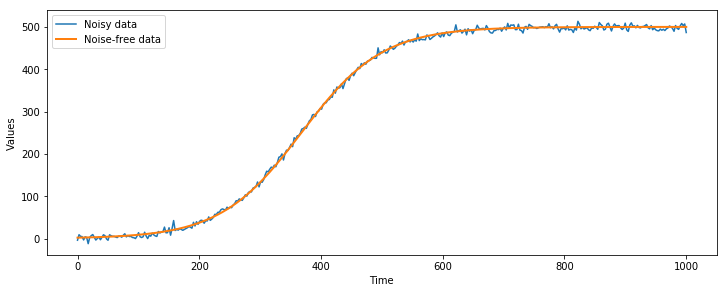

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4.5))
plt.xlabel('Time')
plt.ylabel('Values')
plt.plot(times, values, label='Noisy data')
plt.plot(times, org_values, lw=2, label='Noise-free data')
plt.legend()
plt.show()

Now, I have enough data (a model, a list of times, and a list of values) to formulate a PINTS problem:

In [8]:
problem = pints.SingleOutputProblem(model, times, values)

I now have some toy data, and a model that can be used for forward simulations. To make it into a probabilistic problem, a _noise model_ needs to be added. This can be done using the `GaussianLogLikelihood` function, which assumes independently distributed Gaussian noise over the data, and can calculate log-likelihoods:

In [9]:
#log_likelihood = pints.GaussianLogLikelihood(problem)
log_likelihood = pints.GaussianKnownSigmaLogLikelihood(problem, noise)

This `log_likelihood` represents the _conditional probability_ $p(y|\theta)$, given a set of parameters $\theta$ and a series of $y=$ `values`, it can calculate the probability of finding those values if the real parameters are $\theta$.

This can be used in a Bayesian inference scheme to find the quantity of interest:

$p(\theta|y) = \frac{p(\theta)p(y|\theta)}{p(y)} \propto p(\theta)p(y|\theta)$

To solve this, a _prior_ is defined, indicating an initial guess about what the parameters should be. 
Similarly as using a _log-likelihood_ (the natural logarithm of a likelihood), this is defined by using a _log-prior_. Hence, the above equation simplifies to:

$\log p(\theta|y) \propto \log p(\theta) + \log p(y|\theta)$

In this example, it is assumed that we don't know too much about the prior except lower and upper bounds for each variable: We assume the first model parameter is somewhere on the interval $[0.01, 0.02]$, the second model parameter on $[400, 600]$, and the standard deviation of the noise is somewhere on $[1, 100]$.

In [10]:
# Create bounds for our parameters and get prior
bounds = pints.RectangularBoundaries([0.01, 400], [0.02, 600])
log_prior = pints.UniformLogPrior(bounds)

With this prior, the numerator of Bayes' rule can be defined -- the unnormalised log posterior, $\log \left[ p(y|\theta) p(\theta) \right]$, which is the natural logarithm of the likelihood times the prior:

In [11]:
# Create a posterior log-likelihood (log(likelihood * prior))
log_posterior = pints.LogPosterior(log_likelihood, log_prior)

Finally we create a list of guesses to use as initial positions. We'll run three MCMC chains so we create three initial positions:

In [12]:
xs = [
    np.array(true_parameters) * 0.9,
    np.array(true_parameters) * 1.05,
    np.array(true_parameters) * 1.15,
]

And this gives us everything we need to run an MCMC routine:

In [13]:
chains = pints.mcmc_sample(log_posterior, 3, xs)

Using Haario-Bardenet adaptive covariance MCMC
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Time m:s
0     3      0         0         0          0:00.0
[2.18756701e-03 4.52390818e+02]
-inf


[1.84765379e-02 5.24910447e+02]
-38339.436642827015


[3.62663728e-03 5.72464713e+02]
-inf


1     6      0         0         0          0:00.0
[2.8427467e-02 4.5224673e+02]
-inf


[3.04347170e-02 5.22966003e+02]
-inf


[4.13224357e-03 5.76098617e+02]
-inf


2     9      0         0         0          0:00.0
[1.61544161e-02 4.52182605e+02]
-9741.762981387457
accepted


[3.53442901e-02 5.24193595e+02]
-inf


[2.29034930e-02 5.76615654e+02]
-inf


3     12     0.25      0         0          0:00.0
[1.33282015e-02 4.52210250e+02]
-25945.65799105142


[1.1047500e-02 5.2250436e+02]
-68660.13712912014


[1.04090137e-03 5.75874090e+02]
-inf


[6.77662042e-03 4.51364989e+02]
-inf


[1.13821857e-02 5.24549504e+02]
-55222.61907591883


[4.52356310e-02 5.77116374e

-inf


[2.01834493e-02 5.72373483e+02]
-inf


[9.79448261e-03 4.48212914e+02]
-inf


[-8.39610514e-03  5.20538412e+02]
-inf


[3.46676002e-02 5.69667364e+02]
-inf


[1.22322915e-02 4.53652171e+02]
-49390.09531627334


[1.47251144e-02 5.22374009e+02]
-3169.038003681242
accepted


[2.75852317e-02 5.75939751e+02]
-inf


[1.96712021e-02 4.51878507e+02]
-35555.116913031066


[1.99481931e-02 5.18657008e+02]
-57859.58092904818


[1.65380824e-02 5.66501729e+02]
-36006.60575886468


[2.07904900e-04 4.47404175e+02]
-inf


[8.89441311e-03 5.18645209e+02]
-inf


[1.61347908e-02 5.70062858e+02]
-33077.656063942515


[1.98679758e-02 4.48836647e+02]
-37836.60055935131


[1.31625784e-02 5.23952276e+02]
-12690.947806188657


[1.84197942e-02 5.76643709e+02]
-77788.26565134904


[1.07594303e-02 4.54247003e+02]
-106459.66772465849


[1.85152313e-02 5.25135664e+02]
-39044.94236936648


[1.13437136e-02 5.73910386e+02]
-57805.67050991081


[7.68058479e-03 4.52490800e+02]
-inf


[8.80319532e-03 5.18148456e+02

[2.76153440e-02 5.16639807e+02]
-inf


[1.60850898e-02 5.68560263e+02]
-31404.905694251953


[6.21755348e-03 4.51515866e+02]
-inf


[2.29384763e-02 5.16509598e+02]
-inf


[2.81147548e-02 5.70538025e+02]
-inf


[1.39446289e-02 4.51934324e+02]
-17740.08014229048


[2.73734520e-02 5.20320523e+02]
-inf


[1.99320384e-02 5.71218987e+02]
-103597.96939987168


[1.62629562e-02 4.51416759e+02]
-10250.13664407829


[3.11659720e-02 5.15672547e+02]
-inf


[6.38861124e-03 5.68019185e+02]
-inf


[2.6613066e-03 4.5160437e+02]
-inf


[2.72723739e-02 5.19798458e+02]
-inf


[-7.30433140e-03  5.72090649e+02]
-inf


[1.68525337e-02 4.49457059e+02]
-13033.865978149353


[2.30926429e-02 5.17315069e+02]
-inf


[1.24061903e-02 5.68988561e+02]
-30994.590737874183


[1.92868667e-02 4.55251082e+02]
-31341.25779195681


[1.83138312e-02 5.17370269e+02]
-32209.046101699212


[3.52782244e-02 5.69028705e+02]
-inf


[2.44053780e-02 4.46241268e+02]
-inf


[-6.98484542e-03  5.21227613e+02]
-inf


[1.37828680e-02 5.69349

[1.67030733e-02 4.54561317e+02]
-10967.919872765968


[1.48995128e-02 5.18575074e+02]
-2665.406798274962


[1.37371090e-02 5.66182922e+02]
-17054.700253179017


[1.64122007e-02 4.54428759e+02]
-9832.226285403034


[1.47670303e-02 5.18527983e+02]
-2592.69970774419
accepted


[1.37036629e-02 5.65906833e+02]
-17057.380197581853


[1.58222026e-02 4.54361532e+02]
-8511.898081617872
accepted


[1.47356601e-02 5.18581749e+02]
-2601.467784395453


[1.42813690e-02 5.65821286e+02]
-16437.92683268217


[1.61135056e-02 4.54580442e+02]
-8924.827500296678


[1.46016384e-02 5.18677199e+02]
-2694.86291218909


[1.38637806e-02 5.66225201e+02]
-16742.255545694556


[1.56660374e-02 4.54338488e+02]
-8423.502068574668
accepted


[1.42993884e-02 5.18329148e+02]
-3315.086811525006


[1.43744075e-02 5.66018176e+02]
-16689.699187761533


220   663    0.0317    0.0226    0.0317     0:00.6
[1.58008137e-02 4.54430527e+02]
-8470.195454379455


[1.48951357e-02 5.18552973e+02]
-2658.08490742185


[1.39282541e-02 5.6

[1.43103700e-02 5.62441095e+02]
-14969.073929147498


[1.55999396e-02 4.54617638e+02]
-8326.962422897679
accepted


[1.47881400e-02 5.18385093e+02]
-2575.567368924998
accepted


[1.43693383e-02 5.61086981e+02]
-14463.234112767268
accepted


280   843    0.0961    0.0925    0.125      0:00.7
[1.55873074e-02 4.54548030e+02]
-8351.062564428965


[1.47907971e-02 5.18376676e+02]
-2574.9181648985264
accepted


[1.43306862e-02 5.61773093e+02]
-14705.14424482375


[1.55655793e-02 4.54648256e+02]
-8322.229976296008
accepted


[1.47891850e-02 5.18359291e+02]
-2572.199119647619
accepted


[1.44522518e-02 5.60380131e+02]
-14304.622396807597
accepted


[1.55632131e-02 4.54555533e+02]
-8353.347417540637


[1.47797017e-02 5.18391946e+02]
-2575.183816467621


[1.43666432e-02 5.62133063e+02]
-14913.425377771735


[1.55651940e-02 4.54611242e+02]
-8334.498859266752


[1.47976474e-02 5.18360994e+02]
-2574.2806701827976


[1.42679976e-02 5.62709708e+02]
-15040.815220345692


[1.55311427e-02 4.54646973e+02]

[1.52275858e-02 4.91157153e+02]
-1468.8466823220735


[1.52634923e-02 4.94089085e+02]
-1402.7166072973544


[1.57480528e-02 5.33391706e+02]
-9892.183717516558


[1.54798443e-02 4.61265990e+02]
-6334.525537107692


[1.50590830e-02 5.05282124e+02]
-1428.626436265966


[1.58179305e-02 5.31759742e+02]
-9830.33966475145
accepted


[1.47117167e-02 5.33871982e+02]
-5567.0541813029995


[1.49770124e-02 5.09289691e+02]
-1649.0076607268745


[1.56158016e-02 5.35880883e+02]
-9857.934817371308


[1.52656785e-02 4.86320200e+02]
-1801.2436544200207


[1.54686926e-02 4.83801468e+02]
-2199.6808857710375


[1.56009185e-02 5.36226127e+02]
-9882.343873064794


[1.51389883e-02 4.93668917e+02]
-1331.3877251887272


[1.52227336e-02 4.94552644e+02]
-1355.805238480674


[1.55286532e-02 5.37819250e+02]
-9986.214977871598


[1.47478517e-02 5.27947887e+02]
-4224.575990484945


[1.51509034e-02 4.99714872e+02]
-1295.0748986378073
accepted


[1.57335732e-02 5.33537910e+02]
-9840.223191334393


[1.54694334e-02 4.680

[1.50650286e-02 4.89814882e+02]
-1536.237294474638


[1.49640478e-02 5.02807873e+02]
-1290.1630229354707


[1.41769417e-02 5.30064886e+02]
-5281.265135101913


[1.48757858e-02 5.06068939e+02]
-1427.9948311744151


[1.49934492e-02 4.99947495e+02]
-1238.18798845235


[1.40186231e-02 5.24012507e+02]
-5071.737510900285


[1.50142584e-02 4.97711488e+02]
-1238.3392670364117


[1.50604112e-02 4.96115405e+02]
-1257.5595328826832


[1.37827549e-02 5.17075621e+02]
-6051.357756859217


420   1263   0.152019  0.164     0.162      0:01.1
[1.50643002e-02 4.97909829e+02]
-1237.7478405432362


[1.49824926e-02 5.01458013e+02]
-1258.1874267367991


[1.44812867e-02 5.28937264e+02]
-4444.501779615714


[1.49776883e-02 5.03661216e+02]
-1318.0046675828696


[1.49852524e-02 5.02845280e+02]
-1291.9040070412095


[1.49456947e-02 5.28758206e+02]
-4702.098046651028


[1.49388817e-02 5.02096991e+02]
-1276.7979807566574


[1.49564534e-02 5.04794475e+02]
-1360.8488144686908


[1.41846012e-02 5.24298992e+02]
-4383.0


[1.50426279e-02 4.98716329e+02]
-1233.599595292843
accepted


[1.45974788e-02 5.02044027e+02]
-1745.7561900798728
accepted


[1.50097600e-02 4.99147054e+02]
-1233.3775765821638
accepted


[1.50707594e-02 4.98511812e+02]
-1238.5683844102248


[1.46465978e-02 5.05511760e+02]
-1661.528937817989
accepted


[1.50458883e-02 4.98317471e+02]
-1234.0972501032873


[1.50153908e-02 4.99376843e+02]
-1233.9126386709684
accepted


[1.48534121e-02 4.97393171e+02]
-1350.7449138120373
accepted


[1.50218006e-02 4.99517493e+02]
-1234.7695901216837
accepted


[1.50266595e-02 4.98408376e+02]
-1233.0892697437178
accepted


[1.47506525e-02 4.84521194e+02]
-2606.6491749751967


[1.50180833e-02 4.99149655e+02]
-1233.1228343777332
accepted


[1.49930971e-02 4.98263830e+02]
-1237.9081330063393


[1.47990351e-02 4.91198219e+02]
-1763.293183441515


[1.49912632e-02 5.02054484e+02]
-1271.0308639316224


[1.50143579e-02 4.99115695e+02]
-1233.1128045456294
accepted


[1.47258702e-02 5.05352729e+02]
-1527.7076246369



[1.50339949e-02 4.99256747e+02]
-1234.2814010473555


[1.50629763e-02 4.98790586e+02]
-1237.3207383592396
accepted


[1.51080560e-02 4.95012619e+02]
-1286.046958285767


[1.50361061e-02 4.98529076e+02]
-1233.0552916098147
accepted


[1.50625195e-02 4.98796557e+02]
-1237.2319517501703
accepted


[1.48850245e-02 5.00453654e+02]
-1285.1838558183326


[1.50389066e-02 4.98190971e+02]
-1233.950820335052


[1.50576847e-02 4.99908988e+02]
-1244.5460753483649


[1.49938107e-02 4.96439646e+02]
-1263.4021573298778


[1.50378476e-02 4.98278515e+02]
-1233.6245004537448


[1.50772587e-02 4.98304332e+02]
-1240.1172762297642


[1.50774265e-02 4.91643525e+02]
-1418.228918306426


[1.50408595e-02 4.98789312e+02]
-1233.5063124963003
accepted


[1.50430338e-02 4.97928105e+02]
-1235.2989413656796
accepted


[1.50300091e-02 4.96118190e+02]
-1260.170128096954


560   1683   0.173     0.207     0.152      0:01.5
[1.50413056e-02 4.98160367e+02]
-1234.1779684121495
accepted


[1.50068642e-02 4.98084437e+02]
-

[1.50094695e-02 4.98442349e+02]
-1234.100319093433
accepted


[1.50439671e-02 4.98889904e+02]
-1234.0836104547875


[1.49205250e-02 5.02154918e+02]
-1283.635802357696


[1.50374283e-02 4.99596607e+02]
-1236.864227540029


[1.50307694e-02 4.99123490e+02]
-1233.4556296488706
accepted


[1.50743585e-02 4.98502230e+02]
-1239.5389676669554


[1.49982509e-02 4.98282274e+02]
-1236.6752290366883


[1.50384029e-02 4.99079297e+02]
-1233.9999684602055


[1.50624224e-02 4.97270036e+02]
-1241.5882382363257


[1.50194271e-02 4.97988525e+02]
-1235.4712696536938


[1.50380618e-02 4.99807489e+02]
-1238.811058551377


[1.50341082e-02 4.99354679e+02]
-1234.802846580482
accepted


[1.49900411e-02 4.98892889e+02]
-1235.902755969374


[1.50646419e-02 4.99925439e+02]
-1246.9917410810106


[1.50043523e-02 4.97538078e+02]
-1242.0056168168474


[1.49874695e-02 4.99018795e+02]
-1236.2497260642072


[1.50573004e-02 4.99526956e+02]
-1240.4197912734587


[1.50965672e-02 4.98319674e+02]
-1246.8072318963775


[1.5016

[1.49886757e-02 4.98989882e+02]
-1236.0348480067105


[1.50113577e-02 4.99103640e+02]
-1233.2137257219547
accepted


[1.50142779e-02 4.99201619e+02]
-1233.318680537394


[1.49947042e-02 4.99373029e+02]
-1235.2959557555275


[1.50361266e-02 4.98324148e+02]
-1233.428052461538
accepted


[1.50577074e-02 4.97811081e+02]
-1237.1857567646405


700   2103   0.237     0.243     0.151      0:01.9
[1.49974591e-02 5.00391079e+02]
-1241.959206380621


[1.50319752e-02 4.98739430e+02]
-1232.7877534775118
accepted


[1.50307955e-02 4.97457827e+02]
-1239.0611891571602


[1.50141423e-02 4.99912736e+02]
-1237.3108572574517


[1.50409661e-02 4.98534498e+02]
-1233.3876992328533


[1.50245662e-02 4.98955105e+02]
-1232.7597430806009


[1.49822288e-02 4.99243217e+02]
-1237.301636518699


[1.50242238e-02 4.99196267e+02]
-1233.359214412773
accepted


[1.50147872e-02 4.99338286e+02]
-1233.7602916558048
accepted


[1.50271191e-02 4.98867082e+02]
-1232.7030410102186
accepted


[1.49775100e-02 4.99749831e+02]
-123

[1.50626196e-02 4.98980960e+02]
-1238.0216069270539


[1.49984199e-02 4.99826800e+02]
-1236.962453120923


[1.50244908e-02 4.98541920e+02]
-1232.8165771917916
accepted


[1.50347478e-02 4.98566342e+02]
-1232.9525215976944
accepted


[1.50070915e-02 4.99031136e+02]
-1233.4122913858882
accepted


[1.49809674e-02 4.97875022e+02]
-1244.7939185187986


[1.50448708e-02 4.98939442e+02]
-1234.3490494134996


[1.50210306e-02 4.98389813e+02]
-1233.3254136983362
accepted


[1.50399162e-02 4.98643780e+02]
-1233.2836929060938
accepted


[1.50479389e-02 4.98002736e+02]
-1235.2591757952912


[1.50405186e-02 4.98536284e+02]
-1233.3495598819122
accepted


[1.50509978e-02 4.99274229e+02]
-1236.9980621996


[1.50590817e-02 4.98461513e+02]
-1235.8702028607604


[1.50146842e-02 4.98284026e+02]
-1234.2227603886206
accepted


[1.49931462e-02 4.98960704e+02]
-1235.2245696326804
accepted


[1.50477744e-02 4.98086023e+02]
-1234.9138999933552


[1.50223748e-02 4.98427645e+02]
-1233.1468281820112
accepted


[1.50

[1.50067268e-02 4.98985774e+02]
-1233.419585783571
accepted


[1.50246375e-02 4.98897060e+02]
-1232.6843217773085
accepted


[1.50384726e-02 4.99369030e+02]
-1235.4279748178453


[1.50184615e-02 4.98576485e+02]
-1232.9504395053655
accepted


[1.50262440e-02 4.98554997e+02]
-1232.776360355231
accepted


[1.50361554e-02 4.98717524e+02]
-1233.0197446027166
accepted


[1.49696758e-02 4.98681420e+02]
-1242.192670148227


[1.50068345e-02 4.98609440e+02]
-1233.8597436349082
accepted


[1.50270297e-02 4.98843453e+02]
-1232.6784375060777
accepted


[1.50128284e-02 4.99114354e+02]
-1233.165376519262
accepted


[1.50095000e-02 4.97078256e+02]
-1246.9822751832955


[1.50404357e-02 4.98781665e+02]
-1233.4512043886718
accepted


[1.49868386e-02 4.98945148e+02]
-1236.4794797088837


[1.50384786e-02 4.97911226e+02]
-1235.2451419802298
accepted


[1.50520292e-02 4.99345785e+02]
-1237.6958170741682


[1.50593296e-02 4.99118057e+02]
-1237.933537108437


[1.5038391e-02 4.9756833e+02]
-1237.7279281104632



[1.50559719e-02 4.97621775e+02]
-1238.1090461246024


[1.50606183e-02 4.98190143e+02]
-1236.3363261466477


[1.50124365e-02 4.98886676e+02]
-1232.9716224178492
accepted


[1.50340279e-02 4.98733560e+02]
-1232.8921315725204
accepted


[1.50325839e-02 4.98427791e+02]
-1233.073021876364
accepted


[1.49904456e-02 4.99867948e+02]
-1237.974857988644


[1.50092983e-02 5.00104158e+02]
-1238.9239858047663


[1.50332439e-02 4.97309090e+02]
-1240.4907934703763


[1.49730775e-02 4.99973939e+02]
-1241.5006189562584


[1.50686312e-02 4.98478309e+02]
-1237.9723669420932


[1.49846678e-02 5.00252724e+02]
-1241.5545767981919


[1.50357188e-02 4.98673809e+02]
-1232.97435962397
accepted


[1.50246824e-02 4.99826630e+02]
-1237.2267938428995


[1.50804605e-02 4.98170553e+02]
-1241.0264890468068


[1.50549960e-02 4.97775258e+02]
-1237.0587205970216


[1.50260520e-02 4.99972606e+02]
-1238.7285191296628


[1.50243105e-02 4.98366913e+02]
-1233.2674204972313
accepted


[1.50596276e-02 4.98406156e+02]
-1235.964

[1.50295203e-02 4.97855708e+02]
-1235.7086453137724


[1.50797280e-02 4.99539839e+02]
-1248.0586960067405


[1.50120991e-02 4.99321138e+02]
-1233.748759187591
accepted


[1.50139091e-02 4.98775202e+02]
-1232.9247977212626
accepted


[1.50413685e-02 4.98793651e+02]
-1233.5673591236073


[1.50145710e-02 4.98823923e+02]
-1232.8586229559705
accepted


[1.49837806e-02 5.00299879e+02]
-1242.0871496528412


[1.50649896e-02 4.98326826e+02]
-1237.0524550817574


[1.49916743e-02 4.98686667e+02]
-1236.1009460783857


[1.50114058e-02 4.98435366e+02]
-1233.911542057784


[1.50264885e-02 4.97497893e+02]
-1238.9890863386347


[1.49935283e-02 4.99406870e+02]
-1235.5411493327788


[1.49908564e-02 4.98833935e+02]
-1235.8578567666707


[1.50939824e-02 4.97920566e+02]
-1245.6064173372856


[1.50215242e-02 4.98645604e+02]
-1232.7205636084634
accepted


[1.50397460e-02 4.99409507e+02]
-1235.8659534982498


[1.50040679e-02 5.00440983e+02]
-1242.4823853106147


[1.50149365e-02 4.98695379e+02]
-1232.9469085502

-1238.4975977329505


[1.50389009e-02 4.98288601e+02]
-1233.6466388968124
accepted


[1.50559981e-02 4.98756324e+02]
-1235.704397058731


[1.50216434e-02 4.98595314e+02]
-1232.7890212967593
accepted


[1.50269953e-02 4.98968513e+02]
-1232.846748168538
accepted


[1.49903763e-02 4.98129403e+02]
-1239.5671457234107


[1.50247511e-02 4.98106007e+02]
-1234.3769890860044


[1.49731304e-02 5.00009830e+02]
-1241.695836939214


[1.50638053e-02 4.98109521e+02]
-1237.0731016148488


[1.49875856e-02 4.98803967e+02]
-1236.6238466256248


[1.49523732e-02 4.99393088e+02]
-1246.4437903676378


[1.50129715e-02 4.98067265e+02]
-1235.6497687767137


[1.50312812e-02 4.97985607e+02]
-1234.8200740112327


[1.50333285e-02 4.99517643e+02]
-1235.7307230914444


[1.50326591e-02 4.99062842e+02]
-1233.3964831892547
accepted


[1.50151633e-02 4.99845200e+02]
-1236.7861317470495


[1.50329099e-02 4.98866884e+02]
-1232.9609941106828
accepted


[1.50438272e-02 4.98495085e+02]
-1233.6721309475722
accepted


[1.502903

[1.49683228e-02 5.01140194e+02]
-1254.219992400676


[1.50429170e-02 4.97785376e+02]
-1236.1379717246512
accepted


[1.50467605e-02 4.98425959e+02]
-1234.0333326710695


[1.50355506e-02 4.97975600e+02]
-1234.8449703128479
accepted


[1.50240376e-02 4.98633861e+02]
-1232.6874784891613
accepted


[1.50273951e-02 4.98711520e+02]
-1232.6434789374227
accepted


[1.50538144e-02 4.96560595e+02]
-1249.8868749549958


[1.50392661e-02 4.98709172e+02]
-1233.2604179406974
accepted


[1.50302432e-02 4.99048175e+02]
-1233.186679004414


[1.50648908e-02 4.97958317e+02]
-1237.6837696011983
accepted


[1.50421685e-02 4.99461408e+02]
-1236.605164400719


[1.50567381e-02 4.98417086e+02]
-1235.4446620352376


[1.50437480e-02 4.98374587e+02]
-1233.799140841452
accepted


[1.50835322e-02 4.97679247e+02]
-1242.9528753361926


[1.50311741e-02 4.98732463e+02]
-1232.7506389634027
accepted


[1.50450660e-02 5.00359344e+02]
-1247.0480927650663


[1.50814482e-02 4.97756485e+02]
-1242.0969563858828


[1.50476956e-0

[1.50004557e-02 4.99386450e+02]
-1234.6814627255337


[1.50086019e-02 4.99752137e+02]
-1236.0331923450865


[1.50341536e-02 4.99424848e+02]
-1235.2216952710849


[1.50630095e-02 5.00490193e+02]
-1254.900166154936


[1.50077645e-02 4.98318017e+02]
-1234.8715326692416


[1.50556031e-02 4.98507043e+02]
-1235.261768585289


[1.50775277e-02 4.96611858e+02]
-1250.9276210774726


[1.50419523e-02 4.99225243e+02]
-1235.1133059132937


[1.50261617e-02 4.99923705e+02]
-1238.2616756443504


[1.50031867e-02 4.99352742e+02]
-1234.3383184418637
accepted


[1.50545205e-02 4.97237132e+02]
-1241.2240115699515


[1.50081519e-02 5.00124877e+02]
-1239.10616588425


[1.50175231e-02 5.00401032e+02]
-1242.7252015369922


[1.49941450e-02 4.98294478e+02]
-1237.4689810593961


[1.50068133e-02 5.00323610e+02]
-1241.1690569785983


[1.50309028e-02 4.99443717e+02]
-1234.9897471779586


[1.49726577e-02 4.98983971e+02]
-1240.0659982939646


[1.49868748e-02 4.99764618e+02]
-1237.8685831051732


1200  3603   0.263     

[1.50773570e-02 4.97477712e+02]
-1242.4650509829112


[1.50022976e-02 4.98672938e+02]
-1234.285086464184


[1.50044725e-02 4.99409519e+02]
-1234.4310052258581
accepted


[1.50533690e-02 4.98452054e+02]
-1234.8916326200776
accepted


[1.50223636e-02 4.97104484e+02]
-1244.188768869751


[1.50069553e-02 5.00236253e+02]
-1240.2190261197861


[1.50843246e-02 4.97324193e+02]
-1245.0974215265558


[1.50653539e-02 4.98167748e+02]
-1237.2698524024906


[1.50358707e-02 4.98890238e+02]
-1233.2160023111016
accepted


[1.50369111e-02 4.98110148e+02]
-1234.200126190914
accepted


[1.50350548e-02 4.96586331e+02]
-1250.5030868781146


[1.50788698e-02 4.98458756e+02]
-1240.7933318552236


[1.50521893e-02 4.97118647e+02]
-1242.368732683488


[1.50407639e-02 4.97281900e+02]
-1240.4764160835794


[1.50443387e-02 4.98852415e+02]
-1234.0394047629525
accepted


[1.50069440e-02 4.98817744e+02]
-1233.4567841973362
accepted


[1.50495034e-02 4.98597871e+02]
-1234.357991261594


[1.50178166e-02 4.99725727e+02]
-

-1242.5811917824058


[1.49862841e-02 4.98929406e+02]
-1236.627729815975
accepted


[1.50380933e-02 4.97799080e+02]
-1235.9481292489331


[1.50276476e-02 4.98318474e+02]
-1233.3508411894443
accepted


[1.49821821e-02 5.00168295e+02]
-1241.1756672852312


[1.50318079e-02 4.99704388e+02]
-1236.9600627657676


[1.49822138e-02 4.99973318e+02]
-1239.7762442388157


[1.49691355e-02 4.98686140e+02]
-1242.355191769638


[1.49819323e-02 4.98871779e+02]
-1237.78588315376


[1.50277448e-02 4.97449208e+02]
-1239.382567512973


[1.49601614e-02 5.00921866e+02]
-1252.7821819508686


[1.50177689e-02 4.98861271e+02]
-1232.720033611784
accepted


[1.50078515e-02 4.98276542e+02]
-1235.0750885936027


[1.49112160e-02 5.00238713e+02]
-1267.3701644945752


[1.50222014e-02 4.99594115e+02]
-1235.2692924917255


[1.50732112e-02 4.97289945e+02]
-1242.98074504068


[1.49600577e-02 4.99906539e+02]
-1244.567843708483


[1.49738691e-02 4.97996245e+02]
-1246.0420045353328


[1.49761277e-02 4.98582608e+02]
-1240.5996

-1241.802050888772


[1.50138407e-02 4.99995968e+02]
-1238.0357423818452


[1.50286587e-02 4.98180952e+02]
-1233.8714849151252
accepted


[1.50140891e-02 4.99204859e+02]
-1233.3322509962327
accepted


1400  4203   0.258     0.261242  0.278      0:03.7
[1.50397819e-02 4.99939298e+02]
-1240.4755626016536


[1.50583193e-02 4.96455338e+02]
-1251.605687216686


[1.50259052e-02 4.97181583e+02]
-1242.6925119566995


[1.50328894e-02 4.99694438e+02]
-1237.0158845166732


[1.49497647e-02 4.98163176e+02]
-1254.9357901637627


[1.50401992e-02 4.98372131e+02]
-1233.5293635151945
accepted


[1.50301820e-02 4.98451851e+02]
-1232.9798551933334
accepted


[1.50530302e-02 4.97021999e+02]
-1243.5156408584598


[1.50317831e-02 4.98545202e+02]
-1232.8581978705083
accepted


[1.50235151e-02 4.99534946e+02]
-1234.9676422125804


[1.50072088e-02 4.99492448e+02]
-1234.6133950608357


[1.50175132e-02 4.98797184e+02]
-1232.7318590080506
accepted


[1.50261510e-02 4.98556817e+02]
-1232.7739158335635
accepted


[1



[1.50332437e-02 4.99133635e+02]
-1233.6860603873508


[1.50173396e-02 4.97151751e+02]
-1244.3453939810342


[1.50398691e-02 4.97605495e+02]
-1237.407387647506


[1.49755226e-02 5.00988633e+02]
-1251.0776125620198


[1.49986630e-02 4.99331322e+02]
-1234.71220616666
accepted


[1.50057713e-02 4.98210805e+02]
-1235.7625717475953


[1.50419524e-02 4.97638212e+02]
-1237.1642822228337


[1.49759821e-02 5.00057702e+02]
-1241.4155992105295


[1.50324655e-02 4.98091293e+02]
-1234.2415333788256
accepted


[1.50335614e-02 5.00102565e+02]
-1241.1889494071318


[1.50134263e-02 4.99484459e+02]
-1234.4172456243566
accepted


[1.50181161e-02 4.97886182e+02]
-1236.344675956807
accepted


[1.50068863e-02 4.99649675e+02]
-1235.4333582391607


[1.50210016e-02 4.99256234e+02]
-1233.4829703197431
accepted


[1.50330553e-02 4.97405766e+02]
-1239.4578249022268


[1.49820216e-02 4.98939533e+02]
-1237.603619845435


[1.50296815e-02 4.98720807e+02]
-1232.695590998695
accepted


[1.50598773e-02 4.98848968e+02]


[1.51520238e-02 4.99200070e+02]
-1287.6677104471557


[1.50137801e-02 4.99048579e+02]
-1233.0177739363808
accepted


[1.50417122e-02 4.97719633e+02]
-1236.5521851342571


[1.50232244e-02 4.99262048e+02]
-1233.568321727899
accepted


[1.49775904e-02 4.99361145e+02]
-1238.4496987054156


[1.50187387e-02 4.98053221e+02]
-1235.1122621162629


[1.49733568e-02 5.00590267e+02]
-1246.457663395764


[1.50095064e-02 4.98666914e+02]
-1233.431592384042
accepted


[1.5018707e-02 4.9670232e+02]
-1251.0799354015244


[1.50202591e-02 4.98771884e+02]
-1232.6553823719896
accepted


[1.50089381e-02 5.00176017e+02]
-1239.6314119554424


[1.50486223e-02 4.98932779e+02]
-1234.900927287274


[1.50660911e-02 4.99170779e+02]
-1240.0714687637137


[1.49656299e-02 5.00358504e+02]
-1245.8106763796134


[1.50142417e-02 4.98933499e+02]
-1232.885272768815
accepted


[1.50451358e-02 4.97673801e+02]
-1236.9859111983471


[1.50000286e-02 4.99177525e+02]
-1234.2636806132552


[1.49680052e-02 4.98307468e+02]
-1245.343126

[1.50034696e-02 4.98608791e+02]
-1234.2989559182056


[1.50264278e-02 5.00004101e+02]
-1239.0905589704826


[1.50455570e-02 4.98454035e+02]
-1233.8783123728545
accepted


[1.50197964e-02 4.99375956e+02]
-1233.953659194616


[1.50842344e-02 4.98806862e+02]
-1243.8746153576888


[1.50285113e-02 4.98547210e+02]
-1232.7934896407746
accepted


[1.49896093e-02 4.98642279e+02]
-1236.7062223120147


[1.50143348e-02 4.99564886e+02]
-1234.8448828498786
accepted


[1.50095895e-02 4.98138137e+02]
-1235.6410705963306


[1.49718028e-02 5.00117197e+02]
-1242.6539655777442


[1.49824346e-02 5.00078300e+02]
-1240.455568531787


[1.50302182e-02 4.98961334e+02]
-1232.9745050567992
accepted


[1.49585306e-02 4.99587887e+02]
-1244.2240477474425


[1.49962674e-02 4.99786069e+02]
-1236.8789590709434


[1.50188407e-02 4.99537470e+02]
-1234.7700498345077


[1.49977167e-02 5.00378469e+02]
-1241.8129060850295


[1.49832834e-02 4.99521022e+02]
-1237.525860624544


[1.50258977e-02 4.98513772e+02]
-1232.85138309631



[1.50631484e-02 4.97464287e+02]
-1240.0650653795728


[1.50484028e-02 4.98439274e+02]
-1234.213591730964
accepted


[1.50123417e-02 4.99217460e+02]
-1233.4196303673466
accepted


[1.50196992e-02 4.97754237e+02]
-1237.2508161092414


[1.50688324e-02 4.98544229e+02]
-1238.1262543428063


[1.50517172e-02 5.00468555e+02]
-1250.6343449979117


[1.50305414e-02 4.98369808e+02]
-1233.181448475418
accepted


[1.49788161e-02 4.99069356e+02]
-1238.1897741459636


[1.50462775e-02 4.99276662e+02]
-1236.1046083786978


[1.50008864e-02 4.97761604e+02]
-1240.3443092243874


1680  5043   0.255     0.258     0.281      0:04.5
[1.49765188e-02 4.99359050e+02]
-1238.7078530221913


[1.50012077e-02 4.99584618e+02]
-1235.3954670643443


[1.50278339e-02 4.98432629e+02]
-1233.0155319701273
accepted


[1.50372886e-02 4.98702421e+02]
-1233.0939043315536
accepted


[1.50076769e-02 4.99545473e+02]
-1234.84582667698
accepted


[1.49708122e-02 4.99522722e+02]
-1240.3910957806445


[1.49790477e-02 5.00285907e+02]
-

[1.50425851e-02 4.97872707e+02]
-1235.5879089731093
accepted


[1.50675676e-02 4.99018345e+02]
-1239.5541855953547


[1.49938177e-02 4.99787785e+02]
-1237.1228584897706


[1.49826918e-02 4.99550131e+02]
-1237.7221434097364


[1.50443855e-02 4.98316197e+02]
-1233.961591396103


[1.49686706e-02 4.99895529e+02]
-1242.1309097687838


[1.50410852e-02 4.97492582e+02]
-1238.3827983856443


[1.50614378e-02 4.98161821e+02]
-1236.5330003273418


[1.49867643e-02 4.99681318e+02]
-1237.4937967727656


[1.50489184e-02 4.97916806e+02]
-1235.7372476338114
accepted


[1.50356168e-02 4.96470645e+02]
-1252.452316804768


[1.50052329e-02 4.98565372e+02]
-1234.1932141002455


[1.51104691e-02 4.97789025e+02]
-1252.338584027502


[1.50568421e-02 4.97980368e+02]
-1236.3241134243508


[1.50204698e-02 5.00044323e+02]
-1238.9049942527997


[1.50003074e-02 4.99730403e+02]
-1236.2347087345893
accepted


[1.50174494e-02 4.99624832e+02]
-1235.263631075388


[1.50229166e-02 4.98691187e+02]
-1232.648314453214
accepted

accepted


[1.5005017e-02 5.0010801e+02]
-1238.9342589814466


[1.50480945e-02 4.98161336e+02]
-1234.69366996484
accepted


[1.49772012e-02 5.00036592e+02]
-1241.0482959647838


[1.49547194e-02 4.99981780e+02]
-1246.569613560363


[1.50301519e-02 4.97907022e+02]
-1235.3365254659618
accepted


[1.49775341e-02 5.00513052e+02]
-1245.0023586594452


[1.50181813e-02 5.00101057e+02]
-1239.3065706289888


[1.50565455e-02 4.98017205e+02]
-1236.1502483801826


[1.50172136e-02 5.00457474e+02]
-1243.4289753481141


[1.49253300e-02 5.00257906e+02]
-1259.8157253849624


[1.49776693e-02 4.97925058e+02]
-1245.404524432326


[1.49366020e-02 4.98738982e+02]
-1256.5857041886634


[1.50287896e-02 4.98902050e+02]
-1232.802743920107
accepted


[1.50199021e-02 4.97134532e+02]
-1244.1540333949645


[1.50130359e-02 4.99002389e+02]
-1232.9952085481589
accepted


[1.51727260e-02 4.96395753e+02]
-1293.6508217668188


[1.50723020e-02 4.97912007e+02]
-1239.3381227284358


[1.50092817e-02 4.99652781e+02]
-1235.3897

[1.50593418e-02 4.99118249e+02]
-1237.9376216180929


[1.49967744e-02 5.00909453e+02]
-1248.7647543990633


[1.49776592e-02 4.99070240e+02]
-1238.488582707174


[1.50748959e-02 5.00816280e+02]
-1266.2564535102495


[1.49885578e-02 4.99444729e+02]
-1236.3869725174022


[1.50495186e-02 4.97968182e+02]
-1235.5475848415379


[1.50301202e-02 4.98666682e+02]
-1232.7162899154011
accepted


[1.50332329e-02 4.99634009e+02]
-1236.5737969971738


[1.50100435e-02 4.98560530e+02]
-1233.638416357886
accepted


[1.50636065e-02 4.98059775e+02]
-1237.1526289616302


[1.50312898e-02 4.98795864e+02]
-1232.7901030733162
accepted


[1.49784118e-02 4.97142871e+02]
-1255.964462342335


[1.50356990e-02 4.98398303e+02]
-1233.2358859662795


[1.50082753e-02 4.98638567e+02]
-1233.621307638019
accepted


[1.50138002e-02 4.98917352e+02]
-1232.8998266308174
accepted


[1.50083994e-02 4.99249137e+02]
-1233.6859322447333


[1.49719755e-02 4.98977242e+02]
-1240.2902799153514


[1.50389357e-02 4.97855250e+02]
-1235.591


[1.49997761e-02 4.99026889e+02]
-1234.1861020978452


[1.50463337e-02 4.99710647e+02]
-1239.4805016236144


[1.50531851e-02 4.99139231e+02]
-1236.6582434189509


1960  5883   0.256     0.253     0.278      0:05.2
[1.50668242e-02 4.98894983e+02]
-1238.7190490608002


[1.50504696e-02 4.98852562e+02]
-1234.9591475431794


[1.49986885e-02 4.99798114e+02]
-1236.7596053908671


[1.50915359e-02 4.97064583e+02]
-1248.9559136245223


[1.49672851e-02 4.99399472e+02]
-1241.2590223447357


[1.49904046e-02 4.99807522e+02]
-1237.6211686390368


[1.49987323e-02 5.00381672e+02]
-1241.8212564599764


[1.50768894e-02 4.97276527e+02]
-1243.7832047365694


[1.50193195e-02 4.99805371e+02]
-1236.6531496868006


[1.50365658e-02 5.00976071e+02]
-1255.2560817050153


[1.50545261e-02 4.98967474e+02]
-1236.1140672028316


[1.50116367e-02 4.98565370e+02]
-1233.4678731952615
accepted


[1.50016891e-02 4.98785293e+02]
-1234.1281866826694


[1.50649119e-02 4.97642911e+02]
-1239.1289938233108


[1.49974446e-02 4.980

[1.50294798e-02 4.99401741e+02]
-1234.6142912757623


[1.50779355e-02 4.98248766e+02]
-1240.2901407944223


[1.49750181e-02 5.00721223e+02]
-1247.6764685366315


[1.50091426e-02 5.00317769e+02]
-1241.1705548645784


[1.50384245e-02 4.98411357e+02]
-1233.3464825301517
accepted


[1.50609341e-02 4.99464725e+02]
-1240.8681123161612


[1.49797241e-02 5.00368274e+02]
-1243.2592693229687


[1.50346500e-02 4.98319086e+02]
-1233.3936873343225
accepted


[1.50199061e-02 4.99053915e+02]
-1232.8964063042872
accepted


2040  6123   0.253     0.252     0.274      0:05.4
[1.49728686e-02 4.98801671e+02]
-1240.5888402770208


[1.50048870e-02 4.97632788e+02]
-1240.8217095059906


[1.50855006e-02 4.97495432e+02]
-1244.3521924720853


[1.49305210e-02 5.00444245e+02]
-1258.2961828059906


[1.50925830e-02 4.98037285e+02]
-1245.0173431181051


[1.50578844e-02 5.00425156e+02]
-1251.9477479547013


[1.49835077e-02 4.97779683e+02]
-1245.0005726808336


[1.50397362e-02 4.96818968e+02]
-1246.4140126304317


[1.5

[1.50229933e-02 4.97340333e+02]
-1241.0933164396195


[1.50034327e-02 4.99280335e+02]
-1234.1188058832158
accepted


[1.50318791e-02 4.99850394e+02]
-1238.265102624565


[1.50470546e-02 4.98395276e+02]
-1234.0982517671844
accepted


[1.49706455e-02 4.99102127e+02]
-1240.4278018660518


[1.51025102e-02 4.97648220e+02]
-1249.2979348077413


[1.50455782e-02 4.99273158e+02]
-1235.960844428313


[1.50047781e-02 4.99350371e+02]
-1234.2100633947712
accepted


[1.49881071e-02 5.00352523e+02]
-1242.1252474767873


[1.50810912e-02 4.98831208e+02]
-1242.865734032407


[1.49897473e-02 4.98625624e+02]
-1236.740994815974


[1.49825135e-02 4.99543630e+02]
-1237.7375484905124


[1.51049568e-02 4.99623728e+02]
-1261.2796157191117


[1.50720167e-02 4.98421263e+02]
-1238.7720210737884


[1.49470750e-02 4.99263122e+02]
-1248.85687155677


[1.49869011e-02 4.99283923e+02]
-1236.3804364376192


[1.50583979e-02 4.98593549e+02]
-1235.8542920579146


[1.50484844e-02 4.99597366e+02]
-1238.9084708683824


[1.5134

[1.50448292e-02 5.00088944e+02]
-1243.3080010007832


[1.50115533e-02 4.99248929e+02]
-1233.5359731873432


[1.50144355e-02 5.01012098e+02]
-1251.637322740035


[1.50432998e-02 4.98760262e+02]
-1233.7328432400568
accepted


[1.49792838e-02 4.99767021e+02]
-1239.1828035730316


[1.50021684e-02 4.99723869e+02]
-1236.0807285055798
accepted


[1.50383044e-02 4.97933922e+02]
-1235.1114705185128


[1.50349393e-02 4.99356345e+02]
-1234.9058792827916


[1.49758913e-02 4.99919114e+02]
-1240.6072162962662


[1.49309500e-02 4.98790816e+02]
-1259.3844483906119


[1.49693952e-02 4.99657187e+02]
-1241.0702460699133


[1.50074742e-02 4.98610266e+02]
-1233.7823278843075
accepted


[1.50444317e-02 4.98864100e+02]
-1234.0796953749116
accepted


[1.49717326e-02 4.98846749e+02]
-1240.776263302983


[1.50424878e-02 4.99258614e+02]
-1235.3726129896806


[1.50262861e-02 4.97392198e+02]
-1240.1327287899837


[1.50460773e-02 4.98485295e+02]
-1233.9141301965415
accepted


[1.50267771e-02 4.97184169e+02]
-1242.5



[1.50400386e-02 4.99326043e+02]
-1235.391954933527


[1.50042987e-02 4.99010057e+02]
-1233.6600123810308


[1.50906136e-02 4.98273396e+02]
-1244.4329645360851


[1.48953307e-02 4.98769819e+02]
-1284.272916038659


[1.49799628e-02 4.99186922e+02]
-1237.8167108489738


[1.50463903e-02 4.97002141e+02]
-1243.6741509620058


[1.49995969e-02 4.97073097e+02]
-1249.6307248066746


[1.50185683e-02 4.98797223e+02]
-1232.6950650726494
accepted


[1.50193028e-02 4.98580684e+02]
-1232.9019628790322
accepted


[1.50253094e-02 4.99621003e+02]
-1235.6617648120937


[1.50661170e-02 4.97809477e+02]
-1238.4764282232006


[1.50149401e-02 4.99318641e+02]
-1233.6839891416364
accepted


[1.49466030e-02 4.98597741e+02]
-1252.4385716287036


[1.50321737e-02 4.99236742e+02]
-1234.0158962848716


[1.50113037e-02 4.98784178e+02]
-1233.0989889299367
accepted


[1.50542072e-02 4.98319100e+02]
-1235.1100971720628
accepted


[1.50239056e-02 4.98760858e+02]
-1232.6119411315183
accepted


[1.49814093e-02 4.98177076e+

-1254.9218499991541


[1.50270687e-02 4.99928677e+02]
-1238.4106625381103


[1.50634765e-02 4.98132706e+02]
-1236.9635605591268


[1.49961705e-02 4.99566597e+02]
-1235.7694728681695


[1.50042247e-02 4.97705886e+02]
-1240.1869255866814


[1.49495627e-02 5.00482421e+02]
-1251.246232970871


[1.50375283e-02 4.99648178e+02]
-1237.295924582492


[1.50269221e-02 4.97830078e+02]
-1236.0257969246709


[1.50495268e-02 4.99455711e+02]
-1237.9650141360792


[1.50515103e-02 4.99681368e+02]
-1240.3843149191257


2340  7023   0.244     0.252029  0.264      0:06.2
[1.50910513e-02 4.98493048e+02]
-1245.1110373239771


[1.50679104e-02 4.98106151e+02]
-1237.9049774951955


[1.50684241e-02 4.98055772e+02]
-1238.115352566452


[1.50525805e-02 4.97650405e+02]
-1237.6033432677439


[1.50976917e-02 4.97572549e+02]
-1247.7743162354848


[1.50949725e-02 4.98376665e+02]
-1246.3067305316204


[1.49916138e-02 4.98305034e+02]
-1237.9873423042225


[1.50035261e-02 4.98625371e+02]
-1234.2422679991835


[1.50400786e

[1.50088054e-02 4.99741255e+02]
-1235.9573530641662


[1.50374267e-02 4.98296292e+02]
-1233.5558784305451
accepted


[1.50518823e-02 4.98425247e+02]
-1234.6815867219293


[1.49797055e-02 4.99044045e+02]
-1237.9981553624777


[1.49955241e-02 4.97352577e+02]
-1246.6554141636368


[1.50577023e-02 4.98260031e+02]
-1235.7313020968622


[1.50575569e-02 4.99802317e+02]
-1243.2652480380946


[1.50591810e-02 4.99654554e+02]
-1242.1579703986793


[1.50435933e-02 4.97220941e+02]
-1241.1042826572568


[1.50210036e-02 4.99001083e+02]
-1232.7999405149817
accepted


[1.51437912e-02 4.96479241e+02]
-1275.1154339826724


[1.50193169e-02 4.99934483e+02]
-1237.7622550248075


[1.49773274e-02 5.00658816e+02]
-1246.62765472035


[1.50313708e-02 4.98324279e+02]
-1233.319263414602
accepted


[1.50453114e-02 4.98589580e+02]
-1233.8147881715959
accepted


[1.49537874e-02 4.99673903e+02]
-1246.0120564494766


[1.50489087e-02 4.97902684e+02]
-1235.8069319621454


[1.50125452e-02 4.98172314e+02]
-1235.04650457084



[1.50570971e-02 4.99059207e+02]
-1237.088652570271


[1.50242156e-02 4.99681326e+02]
-1236.015124574846


[1.49664102e-02 4.99670216e+02]
-1241.9253812883733


2480  7443   0.243     0.255     0.261      0:06.6
[1.50544817e-02 4.98580509e+02]
-1235.121561895838


[1.50527943e-02 4.99902268e+02]
-1243.0725204209239


[1.49967079e-02 4.99404359e+02]
-1235.131902837549


[1.49857576e-02 4.99404513e+02]
-1236.7830352207611


[1.50351591e-02 4.98020335e+02]
-1234.6019042154348


[1.49889252e-02 4.99820175e+02]
-1237.8803271476743
accepted


[1.50328640e-02 4.97776555e+02]
-1236.163625305019


[1.50338116e-02 4.99868701e+02]
-1238.7198382418349


[1.50529513e-02 5.00321555e+02]
-1248.7173699793454


[1.50040397e-02 4.99406332e+02]
-1234.449748992596
accepted


[1.49843569e-02 5.00656887e+02]
-1245.8203785221729


[1.49715294e-02 5.00766312e+02]
-1248.7420918981536


[1.50410153e-02 4.99965713e+02]
-1241.0109382307423


[1.49804751e-02 5.00063785e+02]
-1240.659241053499


[1.49818775e-02 4.

[1.50584074e-02 4.99125053e+02]
-1237.7504523105174


[1.50138821e-02 4.97535686e+02]
-1240.1890349222715


[1.50359926e-02 4.98872302e+02]
-1233.1921416964367


[1.50658269e-02 4.96963489e+02]
-1245.0981186162148


[1.50029041e-02 4.99119530e+02]
-1233.881019833653
accepted


[1.50709439e-02 4.98858769e+02]
-1239.7185818890323


[1.50509360e-02 4.96253404e+02]
-1255.1711476022895


[1.49528044e-02 4.99710976e+02]
-1246.4323674118496


[1.50309640e-02 4.99276094e+02]
-1234.0922726185331
accepted


[1.50224514e-02 4.99143977e+02]
-1233.140827146369


[1.49502368e-02 5.00754457e+02]
-1253.467635656274


[1.50319632e-02 4.99590312e+02]
-1236.0872790347196


[1.49824762e-02 5.00050120e+02]
-1240.2486485193033


[1.50789477e-02 4.98388075e+02]
-1240.6980395668068


[1.50591508e-02 4.99730115e+02]
-1242.9384141863652


[1.50348004e-02 4.98913811e+02]
-1233.177561651858


[1.49190779e-02 5.00981002e+02]
-1267.644122821567


[1.50664450e-02 4.98071368e+02]
-1237.6713252136406


[1.50417770e-02

-1241.2483144928492


[1.50614522e-02 4.99004072e+02]
-1237.8433846612452
accepted


[1.49894344e-02 4.98754679e+02]
-1236.359180917757


[1.49662869e-02 4.98162014e+02]
-1247.3417296501589


[1.50727887e-02 4.97641288e+02]
-1240.5629795973898


[1.51094229e-02 4.97162468e+02]
-1254.1189484287045


[1.49986917e-02 4.99148923e+02]
-1234.3908275071076


[1.51017707e-02 4.98850227e+02]
-1251.590665652537


[1.50677817e-02 4.97693697e+02]
-1239.329584073433


[1.49534304e-02 4.98363359e+02]
-1251.1107457822839


[1.50207871e-02 4.99224252e+02]
-1233.3643487369447
accepted


[1.50696757e-02 4.99042082e+02]
-1240.3116433253172


[1.50450394e-02 4.98760482e+02]
-1233.9464219711936
accepted


[1.49785792e-02 4.99838951e+02]
-1239.6578722363565


[1.50775494e-02 4.97037885e+02]
-1246.0179206597518


[1.50374238e-02 4.99322077e+02]
-1235.013967305919
accepted


[1.50494888e-02 4.98199777e+02]
-1234.7303356421542


[1.50451685e-02 4.98081998e+02]
-1234.7181276869449
accepted


[1.50903716e-02 4.9



[1.49879116e-02 4.98860828e+02]
-1236.4110606223367


[1.49830321e-02 4.99350231e+02]
-1237.2245991761008


[1.50380215e-02 4.97998343e+02]
-1234.7570302089562


[1.49965239e-02 4.97919933e+02]
-1239.8291881043704


[1.50784837e-02 4.99219765e+02]
-1244.524371734572


[1.50470297e-02 4.98081935e+02]
-1234.864467639536
accepted


[1.50019612e-02 4.98497824e+02]
-1234.9162123013296
accepted


[1.49985751e-02 4.99267500e+02]
-1234.5803531336387


[1.50417768e-02 4.98305657e+02]
-1233.7788725475787
accepted


[1.50122346e-02 4.96988166e+02]
-1247.746284520685


[1.50872013e-02 4.98336589e+02]
-1243.312659454964


[1.49573930e-02 5.00328129e+02]
-1247.7090646066272


[1.49984170e-02 4.98808588e+02]
-1234.5652289707396
accepted


[1.50799378e-02 4.97883172e+02]
-1241.298597848343


[1.51068335e-02 4.97389846e+02]
-1251.904433847462


[1.49854484e-02 4.97541807e+02]
-1247.2758589797304


[1.50416591e-02 4.97538512e+02]
-1237.9787757198603


[1.50551118e-02 4.97502060e+02]
-1238.901903819284

[1.49956915e-02 5.00002194e+02]
-1238.4068940086286


[1.50018363e-02 4.99005092e+02]
-1233.929964783841
accepted


[1.50527971e-02 4.98050019e+02]
-1235.5598266415225


[1.49984584e-02 4.99950018e+02]
-1237.8238839579165


[1.50177201e-02 4.99027025e+02]
-1232.8705822138188
accepted


[1.50555132e-02 4.99428489e+02]
-1239.128089855871


[1.50318742e-02 4.98033481e+02]
-1234.5423538381212
accepted


[1.49897708e-02 4.99685998e+02]
-1237.0755948483786


[1.50008695e-02 4.99369475e+02]
-1234.5909402632021


[1.50500280e-02 4.95321446e+02]
-1275.9737407149296


[1.50265948e-02 4.98790090e+02]
-1232.6369417031453
accepted


[1.50991350e-02 4.98686706e+02]
-1249.336570758904


[1.50275438e-02 4.98053506e+02]
-1234.5413374669904
accepted


[1.50134809e-02 4.99312359e+02]
-1233.6840365629466


[1.50204697e-02 4.98979188e+02]
-1232.7678251743332
accepted


[1.50313186e-02 4.97826888e+02]
-1235.845273609759
accepted


[1.50448155e-02 4.97661797e+02]
-1237.0614190850413


[1.50376209e-02 5.00396

[1.50138554e-02 4.98432280e+02]
-1233.6824586407095


[1.50006830e-02 4.98513806e+02]
-1235.0590980580184


[1.50437845e-02 4.97885490e+02]
-1235.5676868037447


[1.49841304e-02 4.98117358e+02]
-1241.4219419965075


[1.49887360e-02 4.98916231e+02]
-1236.1272001470786


[1.49981084e-02 4.98879886e+02]
-1234.5041167365646
accepted


[1.50207124e-02 4.98718119e+02]
-1232.6713255941424
accepted


[1.5073454e-02 4.9867500e+02]
-1239.7309766026037


[1.50143438e-02 4.98214951e+02]
-1234.605438918469
accepted


[1.50258366e-02 4.98572290e+02]
-1232.7519812402888
accepted


[1.51025507e-02 4.99520687e+02]
-1258.5972317189614


[1.50031233e-02 4.99856419e+02]
-1236.9042552516294


[1.49940182e-02 4.99389551e+02]
-1235.429268918077


[1.50055760e-02 4.99239261e+02]
-1233.8486565096102
accepted


2840  8523   0.243     0.253     0.258      0:07.5
[1.49878539e-02 4.98034017e+02]
-1241.0653775362055


[1.50014120e-02 4.98813133e+02]
-1234.1210158188558


[1.49646005e-02 4.99492150e+02]
-1242.144770

[1.50263871e-02 4.97746458e+02]
-1236.713630592183


[1.50442267e-02 4.99200772e+02]
-1235.335046570837


[1.50342650e-02 4.98674751e+02]
-1232.8883208077696
accepted


[1.50514499e-02 4.99075472e+02]
-1235.9848191298527


[1.50143211e-02 4.97221237e+02]
-1243.944640469692


[1.50432108e-02 4.97449335e+02]
-1238.7868496673111


[1.50347944e-02 5.00887592e+02]
-1253.1639712715687


[1.50077518e-02 4.99143490e+02]
-1233.4986391329044


[1.50473558e-02 4.98275499e+02]
-1234.3275653163348


[1.50170791e-02 4.99046227e+02]
-1232.914061105543
accepted


[1.50334682e-02 4.98784502e+02]
-1232.8954144853046
accepted


[1.50098555e-02 4.98536651e+02]
-1233.729170702388


[1.49743580e-02 5.00286908e+02]
-1243.4152837520369


[1.50424059e-02 4.99077896e+02]
-1234.4981281994942


[1.50103656e-02 4.97800286e+02]
-1238.1242034442116


[1.49636942e-02 5.00137365e+02]
-1244.7091902374586


[1.50279660e-02 4.98611972e+02]
-1232.7095205882197
accepted


[1.50157785e-02 4.98305014e+02]
-1234.0235725283108

[1.50472514e-02 4.98932182e+02]
-1234.6798474767654
accepted


[1.50554579e-02 4.98422902e+02]
-1235.2291338615587


[1.50164015e-02 4.98313438e+02]
-1233.9320807511076


[1.50529872e-02 4.98905919e+02]
-1235.578171258169


[1.50136552e-02 4.98815223e+02]
-1232.914667156377


[1.50545387e-02 4.97534089e+02]
-1238.6059287080939


[1.50091974e-02 4.98373379e+02]
-1234.420846048474
accepted


[1.50206489e-02 4.98237989e+02]
-1233.9535103574533


[1.50088990e-02 4.97211188e+02]
-1245.1901346923917


[1.50264650e-02 4.97967026e+02]
-1235.1053433883524


[1.50437924e-02 4.98859674e+02]
-1233.9855533844632
accepted


[1.49821427e-02 4.98910923e+02]
-1237.6364167061563


[1.50233061e-02 4.98215265e+02]
-1233.905337407913
accepted


2980  8943   0.242     0.255     0.256      0:07.9
[1.50645832e-02 4.97881064e+02]
-1237.9075714935154


[1.49944596e-02 4.98580066e+02]
-1235.926885740714


[1.49840619e-02 4.97974792e+02]
-1242.7539572112657


[1.50300366e-02 4.99122911e+02]
-1233.40373254969
acce

[1.50100272e-02 4.99985331e+02]
-1237.8407569935523


[1.50103864e-02 4.99793014e+02]
-1236.3060576264625


[1.50543554e-02 4.97959100e+02]
-1236.0916995805512


[1.49720910e-02 5.00054272e+02]
-1242.1878168786648


[1.50451145e-02 4.98287996e+02]
-1234.0858520477732
accepted


[1.50026667e-02 4.99745711e+02]
-1236.1867989301422


[1.50023221e-02 4.98067104e+02]
-1237.345096263454


[1.50221492e-02 4.97614325e+02]
-1238.2623640498805


[1.50239295e-02 4.99088557e+02]
-1233.0223465167228
accepted


[1.50284539e-02 4.98985531e+02]
-1232.938424028994
accepted


[1.50505905e-02 4.98082325e+02]
-1235.2016087220823


[1.50358006e-02 4.99335096e+02]
-1234.8868692657113


[1.49818607e-02 5.00453775e+02]
-1243.814951094448


[1.50690731e-02 4.96623225e+02]
-1249.7249052049733


[1.50340330e-02 4.98637036e+02]
-1232.8799638743976
accepted


[1.50305604e-02 4.97762403e+02]
-1236.3517210863163


[1.50530252e-02 4.97820971e+02]
-1236.6040402925685


[1.50154828e-02 4.97760510e+02]
-1237.71463404967

[1.49895424e-02 4.98470829e+02]
-1237.5073519732875


[1.50860132e-02 4.97723177e+02]
-1243.4880644649397


[1.50199968e-02 4.99642246e+02]
-1235.4767098334762
accepted


[1.50191418e-02 4.99209553e+02]
-1233.2965179053278
accepted


[1.50011897e-02 4.98305720e+02]
-1235.9801305070607
accepted


[1.50012865e-02 5.00333273e+02]
-1241.246332013211


[1.50152752e-02 4.98339706e+02]
-1233.917323000752


[1.49880804e-02 4.99102302e+02]
-1236.0753216631017
accepted


[1.50113823e-02 5.01129366e+02]
-1253.359122120828


[1.50130795e-02 4.99077874e+02]
-1233.0912124511954
accepted


[1.49963885e-02 4.99521005e+02]
-1235.5625663031271
accepted


[1.49918905e-02 5.00388549e+02]
-1242.1976240659158


[1.50275365e-02 5.00110139e+02]
-1240.3690997299477


[1.50066411e-02 4.99601219e+02]
-1235.172999522673
accepted


[1.50511091e-02 4.99376525e+02]
-1237.714155110053
accepted


[1.49938240e-02 4.98943409e+02]
-1235.1244809138032


[1.50069096e-02 4.99572361e+02]
-1235.0112129701374
accepted


[1.507

accepted


[1.51103352e-02 4.98130966e+02]
-1252.4414281293289


[1.50654401e-02 4.98171369e+02]
-1237.281922584885


[1.50697941e-02 4.99315609e+02]
-1242.2954745043328


[1.50551939e-02 4.95150763e+02]
-1279.9227521657945


[1.50076057e-02 4.99225753e+02]
-1233.6757085353177
accepted


[1.50891070e-02 4.98842111e+02]
-1245.9544217413147


[1.50461448e-02 4.95912577e+02]
-1262.3157621020894


[1.50074327e-02 4.99237319e+02]
-1233.71458467702
accepted


[1.4968972e-02 4.9871316e+02]
-1242.2740540910563


[1.50239955e-02 4.98692918e+02]
-1232.6361580137363
accepted


[1.50002102e-02 4.98783117e+02]
-1234.341455193162
accepted


[1.50388494e-02 4.97628376e+02]
-1237.22135548985


[1.50210059e-02 4.99484985e+02]
-1234.547574692493


[1.49983508e-02 4.99867861e+02]
-1237.2412382461698


[1.49947564e-02 4.99154096e+02]
-1234.9364215629107
accepted


[1.49424419e-02 5.00455697e+02]
-1253.5114186529752


[1.49967641e-02 4.98553577e+02]
-1235.5890945298122


[1.49988921e-02 4.99802203e+02]
-12

[1.49963034e-02 4.98222173e+02]
-1237.4670841587056


[1.50407307e-02 5.00090571e+02]
-1242.4093870315044


[1.50756350e-02 4.98065533e+02]
-1239.7889372201455


[1.50311616e-02 4.98320687e+02]
-1233.3287229086025
accepted


[1.49899133e-02 4.98583851e+02]
-1236.8777196384979


[1.50332545e-02 4.99094632e+02]
-1233.547731323305
accepted


3260  9783   0.242257  0.252     0.254      0:08.6
[1.50848463e-02 4.98469122e+02]
-1242.7731965799458


[1.49929828e-02 4.98108733e+02]
-1239.07059496708


[1.50151686e-02 5.00426074e+02]
-1242.8369218060454


[1.50500435e-02 4.99397818e+02]
-1237.640665385781


[1.50254354e-02 4.98323183e+02]
-1233.3826210694529
accepted


[1.50544729e-02 4.98615990e+02]
-1235.1591755227703


[1.50072059e-02 4.97573448e+02]
-1240.9951551998836


[1.50396952e-02 4.97598997e+02]
-1237.460955051808


[1.50474932e-02 4.98122398e+02]
-1234.7612152758975
accepted


[1.50152878e-02 4.97859000e+02]
-1236.8974231807204
accepted


[1.50375433e-02 4.97818528e+02]
-1235.8143261


[1.49732835e-02 4.99296247e+02]
-1239.5143334123013


[1.50335478e-02 4.99598639e+02]
-1236.3420051047972
accepted


[1.50698823e-02 4.98774891e+02]
-1239.0607795356116


[1.50695782e-02 4.96544955e+02]
-1250.8837088785347


[1.50745620e-02 4.96890256e+02]
-1247.0649732268691


[1.49593526e-02 4.99949678e+02]
-1244.9605772437385


[1.49709679e-02 4.99447062e+02]
-1240.2396175138122


[1.49961198e-02 5.00364940e+02]
-1241.7227647612901


[1.50079471e-02 4.99607079e+02]
-1235.1596154169688


3340  10023  0.243041  0.25      0.254      0:08.8
[1.49824835e-02 5.00622158e+02]
-1245.589314798018


[1.49850598e-02 5.00816264e+02]
-1247.8012116640393


[1.49885857e-02 4.99029213e+02]
-1236.014805506527
accepted


[1.50581665e-02 4.98515960e+02]
-1235.7276267712693


[1.50398473e-02 5.01047918e+02]
-1257.5521227608788


[1.49734329e-02 4.99675034e+02]
-1240.1027242202767


[1.49582368e-02 5.00539577e+02]
-1249.1874260319364


[1.50530749e-02 5.00853119e+02]
-1257.9302429623967


[1.50284160e-0



[1.49954336e-02 4.98467534e+02]
-1236.2278796571761


[1.50218275e-02 4.99148539e+02]
-1233.142141771562
accepted


[1.50912127e-02 4.97195218e+02]
-1247.835258640038


[1.50248594e-02 4.97878673e+02]
-1235.801567375994
accepted


[1.50070639e-02 4.97937314e+02]
-1237.4996140264998


[1.50701629e-02 5.00124365e+02]
-1251.7844190426092


[1.50489207e-02 4.96804509e+02]
-1246.2873159939243


[1.50119879e-02 5.02710531e+02]
-1292.5003483348733


[1.50294382e-02 4.98823017e+02]
-1232.735194161214
accepted


[1.50642947e-02 4.96918474e+02]
-1245.4664270278822


[1.50391527e-02 5.00306141e+02]
-1244.8684785108023


[1.49957717e-02 4.99447981e+02]
-1235.3756820752567


[1.50085823e-02 4.98250551e+02]
-1235.1146166256167
accepted


[1.49998363e-02 5.00555176e+02]
-1243.8568191469344


[1.51172920e-02 5.00229824e+02]
-1279.1006860794257


[1.49756218e-02 4.98857026e+02]
-1239.5514137848852


[1.49932693e-02 4.98862585e+02]
-1235.338631139793


[1.49823949e-02 4.99186837e+02]
-1237.25418697592

[1.50290340e-02 4.98982598e+02]
-1232.9591081037727
accepted


[1.50405785e-02 5.00032392e+02]
-1241.6836839036646


[1.50731845e-02 4.99921196e+02]
-1250.0944720096636


[1.50481237e-02 4.99546623e+02]
-1238.3965886545495


[1.50119384e-02 4.98822434e+02]
-1233.0231859173002
accepted


[1.50197700e-02 5.00410539e+02]
-1243.077264288477


[1.50135434e-02 4.98977372e+02]
-1232.948013972221
accepted


[1.50200063e-02 4.98217046e+02]
-1234.0962669245712


[1.51188551e-02 4.98058665e+02]
-1256.5094576778772


[1.50338907e-02 4.99463379e+02]
-1235.4349043423688


[1.50157920e-02 4.98999116e+02]
-1232.8801643080872
accepted


[1.50237485e-02 5.00194308e+02]
-1240.8603457966967


[1.50143625e-02 4.96798183e+02]
-1250.3591321037238


[1.49871262e-02 5.00468517e+02]
-1243.4163425916543


[1.50812827e-02 5.00418797e+02]
-1261.5546042436717


[1.50094937e-02 4.98345588e+02]
-1234.510815616295


[1.49922080e-02 4.99673534e+02]
-1236.7015006297204


[1.50263700e-02 4.99235279e+02]
-1233.60051295683

-1233.884543658071
accepted


[1.50082648e-02 4.98993111e+02]
-1233.293304905196
accepted


[1.50024618e-02 4.97820206e+02]
-1239.4233110325313


3540  10623  0.245     0.249647  0.253      0:09.4
[1.50911996e-02 4.96971221e+02]
-1249.6897294374921


[1.49885421e-02 4.99761992e+02]
-1237.6167679563264


[1.4973443e-02 5.0031130e+02]
-1243.7873631237362


[1.49766214e-02 4.99532320e+02]
-1238.959526625871


[1.50368817e-02 4.99748334e+02]
-1238.0626494098162


[1.50654549e-02 4.98693003e+02]
-1237.623098017302


[1.49739683e-02 4.98284351e+02]
-1243.3376641283296


[1.49917411e-02 4.98406688e+02]
-1237.342812648337


[1.50210701e-02 4.99740281e+02]
-1236.2442036549137


[1.50058252e-02 4.99110824e+02]
-1233.598562046507
accepted


[1.50271168e-02 4.98875206e+02]
-1232.7117343409982
accepted


[1.50271463e-02 4.97238269e+02]
-1241.8409157718363


[1.50107156e-02 4.98674275e+02]
-1233.3031855353527
accepted


[1.50401746e-02 4.97806600e+02]
-1235.9249609590431


[1.50202684e-02 4.98647634


[1.50103897e-02 5.01181073e+02]
-1254.1937903694175


[1.50197818e-02 4.97296440e+02]
-1242.0593895528511


[1.50269248e-02 4.97678111e+02]
-1237.2517731253322
accepted


[1.50081898e-02 4.98775452e+02]
-1233.3810456670756
accepted


[1.50040971e-02 4.98658302e+02]
-1234.0754321781942
accepted


[1.50550885e-02 4.98056779e+02]
-1235.8210339083244
accepted


[1.50356768e-02 4.99563727e+02]
-1236.3609097714798


[1.50020565e-02 4.98553641e+02]
-1234.6885613503625


[1.50118980e-02 4.98336626e+02]
-1234.2690029357836
accepted


[1.49974692e-02 4.97408117e+02]
-1245.3462599185182


[1.5008837e-02 4.9798030e+02]
-1236.8632949700284


[1.50092949e-02 4.99029752e+02]
-1233.2427344394075
accepted


[1.49693172e-02 4.98661533e+02]
-1242.422303263621


[1.49991404e-02 4.99520687e+02]
-1235.2846268515016
accepted


[1.50467004e-02 4.98048529e+02]
-1234.9673568343787
accepted


[1.50484657e-02 4.99815858e+02]
-1241.0181252359434


[1.49756007e-02 4.98561927e+02]
-1240.8811093994796


[1.50405099e

[1.50359979e-02 4.99076380e+02]
-1233.7342696146138
accepted


[1.50695984e-02 4.98493749e+02]
-1238.237546050046


[1.50369875e-02 4.99720742e+02]
-1237.8326176922872


[1.50156273e-02 5.01308727e+02]
-1257.3744566135833


[1.50527803e-02 4.98947352e+02]
-1235.690565937004


[1.50439886e-02 4.99485064e+02]
-1237.0965045547046


[1.50528465e-02 4.99686663e+02]
-1240.7674840475493


[1.50122114e-02 4.97636974e+02]
-1239.393659569483


[1.50143516e-02 4.99284629e+02]
-1233.5710915144903
accepted


[1.50069467e-02 4.98793562e+02]
-1233.4835914189414
accepted


[1.50161689e-02 4.98873561e+02]
-1232.7797097118976
accepted


[1.49975005e-02 4.99039662e+02]
-1234.494858969805


3680  11043  0.247     0.247     0.253      0:09.7
[1.50064941e-02 4.98618331e+02]
-1233.8765881593274
accepted


[1.49873999e-02 4.99200779e+02]
-1236.218535386624


[1.49743120e-02 4.98706885e+02]
-1240.541367911819


[1.50102882e-02 4.99525356e+02]
-1234.6672389442074


[1.49946079e-02 4.99373367e+02]
-1235.30951108


[1.50532753e-02 4.98258119e+02]
-1235.068626075836


[1.50291885e-02 4.98831749e+02]
-1232.7338230939374
accepted


[1.50452740e-02 4.98066776e+02]
-1234.7858531809093


[1.49973412e-02 4.99597292e+02]
-1235.7845711710122


[1.49984492e-02 4.99418310e+02]
-1234.981598067551


[1.50243333e-02 4.99016122e+02]
-1232.8644541208769


[1.49408499e-02 5.00938465e+02]
-1258.3651871167638


[1.5032722e-02 4.9744676e+02]
-1239.0559282925415


[1.49977952e-02 4.98784830e+02]
-1234.7092471951516
accepted


[1.50100963e-02 5.00431030e+02]
-1242.5604677886288


[1.50237995e-02 4.97231326e+02]
-1242.320069133427


[1.50216765e-02 4.98397026e+02]
-1233.2707967956642
accepted


[1.50670287e-02 4.98073485e+02]
-1237.7854372417803


[1.50170171e-02 4.99423979e+02]
-1234.1306178204422
accepted


[1.50053622e-02 4.98378203e+02]
-1234.9202350848532


[1.49782268e-02 4.98963975e+02]
-1238.527589145902


[1.50455525e-02 4.99610291e+02]
-1238.4061151397395


[1.49688071e-02 4.98974579e+02]
-1241.2989885666175

[1.49801336e-02 4.98777497e+02]
-1238.5494460093298


[1.50160965e-02 4.97948105e+02]
-1236.1059136115227


[1.50323213e-02 4.99260624e+02]
-1234.1386970441174
accepted


[1.50377484e-02 4.97624354e+02]
-1237.261550432979


[1.50954288e-02 4.97959843e+02]
-1246.0912835881134


[1.50474339e-02 4.99180136e+02]
-1235.7666795457205


3840  11523  0.247     0.247     0.250716   0:10.1
[1.50350471e-02 4.99102254e+02]
-1233.7342605739154
accepted


[1.50019613e-02 4.99020121e+02]
-1233.9176567635936


[1.50004530e-02 4.99930198e+02]
-1237.5644977031513


[1.50175846e-02 5.01107687e+02]
-1253.802467659025


[1.50077003e-02 4.98934396e+02]
-1233.3252692230321


[1.50535123e-02 4.98466637e+02]
-1234.9120150435751


[1.51274500e-02 4.97867324e+02]
-1260.8030392758858


[1.50023411e-02 4.97680987e+02]
-1240.8566144215026


[1.50222070e-02 4.99110798e+02]
-1233.044116452396
accepted


[1.50228403e-02 4.99531001e+02]
-1234.9044887668074
accepted


[1.49980705e-02 4.99727589e+02]
-1236.3850729770763



[1.49942698e-02 4.99220933e+02]
-1235.0734358189131
accepted


[1.50130248e-02 4.99468998e+02]
-1234.3452436846978
accepted


[1.50271680e-02 4.99317314e+02]
-1234.0048035311497


[1.50369625e-02 4.97144359e+02]
-1242.2009151816942


[1.49341749e-02 5.02079914e+02]
-1277.7353048604843


[1.49990075e-02 4.97103941e+02]
-1249.3158449770146


[1.50118502e-02 4.99605895e+02]
-1235.081524249371
accepted


[1.50295210e-02 4.98321867e+02]
-1233.3223116696074
accepted


[1.50339489e-02 4.98483027e+02]
-1233.0146657312255


[1.50069265e-02 5.00157558e+02]
-1239.4133643829423


[1.50505154e-02 4.97855786e+02]
-1236.184427099886
accepted


[1.49940651e-02 4.98612766e+02]
-1235.8785819522961


[1.50311217e-02 5.00464730e+02]
-1245.4859400518176


[1.50701668e-02 4.96234040e+02]
-1255.8238786037168


[1.50196416e-02 4.99077738e+02]
-1232.946072128993
accepted


[1.50329838e-02 5.00040514e+02]
-1240.3868786245243


[1.50693788e-02 4.96494760e+02]
-1251.6026685000525


[1.50416883e-02 4.99784105e+02

[1.50811916e-02 5.00130432e+02]
-1256.5954526092082


[1.50110336e-02 4.99640173e+02]
-1235.2905927484683
accepted


[1.50746847e-02 4.98007736e+02]
-1239.653489272244


[1.50812764e-02 5.00386174e+02]
-1260.961153929653


[1.50100023e-02 5.01153525e+02]
-1253.6424653093075


[1.50432632e-02 4.98132940e+02]
-1234.3950316255314
accepted


[1.50484114e-02 4.99938538e+02]
-1242.3627642180345


[1.50135158e-02 5.00072304e+02]
-1238.7450360529683


[1.50639850e-02 4.97199638e+02]
-1242.4230548013797


[1.50155690e-02 4.99436031e+02]
-1234.1782784158447
accepted


[1.49738985e-02 5.01548876e+02]
-1260.3629050283146


[1.50506104e-02 4.98940163e+02]
-1235.2653204237472


[1.50070805e-02 4.96994470e+02]
-1248.856870426751


[1.50086517e-02 5.01164921e+02]
-1253.7059697814082


[1.50675162e-02 4.97882048e+02]
-1238.44226836319


[1.50400164e-02 4.97344914e+02]
-1239.8249128549007


[1.50393292e-02 4.99576280e+02]
-1236.9999855154012


[1.50265647e-02 4.97611275e+02]
-1237.8791689319999


[1.501

-1236.6500768489964


[1.50572965e-02 4.98840418e+02]
-1236.2120849985436


[1.50218750e-02 4.98766515e+02]
-1232.6268243558181
accepted


[1.50069375e-02 4.98677079e+02]
-1233.6819855832498
accepted


[1.50196604e-02 4.98962730e+02]
-1232.7527567564373
accepted


[1.49773460e-02 4.98489435e+02]
-1240.7596980721273


[1.49533941e-02 4.99027249e+02]
-1246.861965750543


[1.50596866e-02 4.97565969e+02]
-1238.8995192866876


[1.49558990e-02 5.00750374e+02]
-1251.8525688076932


[1.50329318e-02 4.99027527e+02]
-1233.3124612599415
accepted


[1.50282635e-02 4.98778596e+02]
-1232.6689290440474
accepted


[1.50147882e-02 4.99441791e+02]
-1234.2051542395375
accepted


[1.50115669e-02 4.99682986e+02]
-1235.5544570236043


[1.49826255e-02 5.00030807e+02]
-1240.0920044684058


[1.49879476e-02 4.99959032e+02]
-1238.865386788378


[1.50244226e-02 4.99576593e+02]
-1235.293028859483


[1.49954334e-02 5.00275834e+02]
-1240.8357934257738


[1.49991763e-02 4.99374290e+02]
-1234.7724103757655


[1.505086

[1.50575949e-02 4.98204420e+02]
-1235.8047524100382


[1.50922756e-02 4.98718024e+02]
-1246.5507170848578


[1.50532760e-02 4.98823107e+02]
-1235.369283029886


[1.49909049e-02 4.99586293e+02]
-1236.492918648292


[1.50123360e-02 5.00299657e+02]
-1241.1071423726069


[1.50575532e-02 4.96457180e+02]
-1251.5624592321283


[1.50135658e-02 4.99084395e+02]
-1233.0822840861208
accepted


4140  12423  0.246     0.243     0.252596   0:10.9
[1.50333535e-02 4.98715576e+02]
-1232.8471692320832
accepted


[1.50263018e-02 4.98712915e+02]
-1232.629618736208
accepted


[1.50333045e-02 4.97444515e+02]
-1239.047238119917


[1.50212685e-02 4.99201636e+02]
-1233.296786198531
accepted


[1.50383519e-02 4.97697448e+02]
-1236.6795641018446


[1.5010549e-02 4.9955524e+02]
-1234.8161762428656
accepted


[1.50749399e-02 4.99296153e+02]
-1243.879378564858


[1.50757185e-02 4.98270865e+02]
-1239.6730598326892


[1.49982565e-02 5.00901512e+02]
-1248.662851937811


[1.50686206e-02 4.99187770e+02]
-1240.94432201118

[1.50246613e-02 4.98120193e+02]
-1234.3060765514397
accepted


[1.50390723e-02 4.98586782e+02]
-1233.214111250452
accepted


[1.50018823e-02 4.99754452e+02]
-1236.2830522307167


[1.49968962e-02 4.98604750e+02]
-1235.3702464855437
accepted


[1.51027975e-02 4.97524249e+02]
-1249.8072324773425


[1.50557761e-02 4.97826146e+02]
-1236.8738130672832


[1.50432350e-02 4.99873178e+02]
-1240.4606169850322


[1.50412078e-02 4.98137034e+02]
-1234.258158154179


[1.50686652e-02 4.98361956e+02]
-1237.8860831084332


[1.49725732e-02 4.99455998e+02]
-1239.8201910071382


[1.50164916e-02 4.98378480e+02]
-1233.658557827678


[1.49836661e-02 4.98729049e+02]
-1237.79696142512


[1.49335317e-02 5.00360826e+02]
-1256.4974233754706


[1.50146807e-02 5.00086618e+02]
-1238.9408983011083


[1.50433504e-02 4.98522421e+02]
-1233.6108632650216
accepted


[1.49687607e-02 4.98290015e+02]
-1245.199840461241


[1.50801896e-02 4.97122238e+02]
-1245.7470379445697


[1.50589458e-02 4.98139308e+02]
-1236.1562191359171



[1.50317517e-02 4.98169307e+02]
-1233.8875358005744


[1.49743036e-02 5.00045524e+02]
-1241.6690427443102


[1.49885089e-02 4.98043357e+02]
-1240.7972792731425


[1.49782816e-02 4.99638513e+02]
-1238.8894107208116


[1.49729114e-02 4.99946924e+02]
-1241.3885650767206


[1.49932446e-02 4.99741510e+02]
-1236.9250424487307
accepted


4280  12843  0.246     0.244569  0.252      0:11.2
[1.50096959e-02 4.97119319e+02]
-1246.3285090997576


[1.49894097e-02 4.98170993e+02]
-1239.4933751266815


[1.49699393e-02 5.00983547e+02]
-1251.760951596881


[1.50273842e-02 4.99399625e+02]
-1234.4371500152808


[1.49930781e-02 5.00552685e+02]
-1243.9816976693044


[1.49517252e-02 5.01372539e+02]
-1260.885566333578


[1.50655895e-02 4.97918643e+02]
-1237.9472973208078


[1.50612262e-02 4.97078773e+02]
-1243.3724575016993


[1.49580505e-02 4.99167343e+02]
-1244.5935834856505


[1.50519917e-02 4.98047152e+02]
-1235.47808345972


[1.50087575e-02 4.98372209e+02]
-1234.4814146045494
accepted


[1.49703418e-02 

[1.50301584e-02 4.98038708e+02]
-1234.5442832028143


[1.50556456e-02 4.98290044e+02]
-1235.363583603654


[1.50704063e-02 4.97797341e+02]
-1239.3457704535874


[1.50021126e-02 4.98435046e+02]
-1235.1613506290878


[1.50417324e-02 4.98212524e+02]
-1234.02928655533
accepted


[1.50708038e-02 4.97820760e+02]
-1239.332927499027


[1.50775312e-02 4.97514942e+02]
-1242.278894046699


[1.50664701e-02 4.96438863e+02]
-1252.2251965549951


[1.50816817e-02 4.99351928e+02]
-1246.9240203583113


[1.50398098e-02 4.99030507e+02]
-1233.9888468128552


[1.50336186e-02 4.97511838e+02]
-1238.3729946901824


[1.50573124e-02 4.99133937e+02]
-1237.5422135912622


[1.50326246e-02 4.99290484e+02]
-1234.311132868863
accepted


[1.50500951e-02 4.98200387e+02]
-1234.7959530313506


[1.49248919e-02 5.00549407e+02]
-1261.5230242836979


[1.50543907e-02 4.97219161e+02]
-1241.3980976788957


[1.50303314e-02 4.99246557e+02]
-1233.9063677152556
accepted


[1.50506779e-02 4.98195890e+02]
-1234.873815890221


[1.50003

[1.50624717e-02 4.98088113e+02]
-1236.8766912751373


[1.50470323e-02 4.98040081e+02]
-1235.0282206148654


[1.50255583e-02 4.98683264e+02]
-1232.638363597431
accepted


[1.50467653e-02 4.97374056e+02]
-1239.5530236282686


[1.50297252e-02 4.98228601e+02]
-1233.6554628663305
accepted


[1.49929533e-02 4.98013848e+02]
-1239.8697216378011


[1.50711181e-02 4.96890059e+02]
-1246.5730539145247


[1.50495186e-02 4.96809890e+02]
-1246.2079117425394


[1.50619924e-02 4.97840031e+02]
-1237.6527411542183


[1.50342730e-02 4.97434155e+02]
-1239.1036373670702


[1.50374457e-02 4.97644050e+02]
-1237.1036733379249


[1.50385473e-02 4.99002114e+02]
-1233.7534249873447


[1.49877572e-02 4.97746188e+02]
-1244.0194899315193


[1.49879746e-02 4.98667563e+02]
-1236.9812596605814


[1.50306321e-02 4.97119113e+02]
-1242.9918048025381


[1.50174681e-02 5.00054233e+02]
-1238.780948886754


[1.49927967e-02 4.99173237e+02]
-1235.2534902381851


[1.50525844e-02 4.97639761e+02]
-1237.676640558734


[1.50331935e-

-1235.7420214695892


[1.49982170e-02 4.98361722e+02]
-1236.2223155465026


[1.50490981e-02 4.98217659e+02]
-1234.6430435670895


[1.50576214e-02 4.98315239e+02]
-1235.6528690003558


[1.49480245e-02 4.99257506e+02]
-1248.4558272682532


[1.50184725e-02 4.97696647e+02]
-1237.9089026013269


[1.50079675e-02 4.98888325e+02]
-1233.310106683747
accepted


[1.49927914e-02 4.98527344e+02]
-1236.4957740827306


[1.50299281e-02 4.99035904e+02]
-1233.1345635755758
accepted


[1.49642512e-02 4.98433710e+02]
-1245.8035425423186


[1.49644306e-02 4.97324710e+02]
-1259.2247322737178


[1.50340958e-02 4.98310778e+02]
-1233.4032080194158


[1.49687560e-02 4.99204073e+02]
-1240.8673104591292


4500  13503  0.244168  0.243     0.252      0:11.8
[1.50025043e-02 4.98848363e+02]
-1233.930657713158
accepted


[1.50164435e-02 4.98855958e+02]
-1232.766366883798
accepted


[1.50270125e-02 4.98243127e+02]
-1233.6446699432993
accepted


[1.49983062e-02 4.97554831e+02]
-1243.2630396856975


[1.49734424e-02 4.979



[1.50613874e-02 4.96283290e+02]
-1254.5487737733874


[1.50824701e-02 4.98645219e+02]
-1242.5101594456885


[1.50211632e-02 4.98088664e+02]
-1234.696948952067


[1.50085234e-02 4.97880615e+02]
-1237.724472849486


[1.50239437e-02 4.98712140e+02]
-1232.6257202677477
accepted


[1.50723309e-02 4.97669723e+02]
-1240.3234556645086


[1.50423603e-02 4.98243678e+02]
-1233.9786517070747


[1.50192219e-02 4.98504986e+02]
-1233.0763430316895
accepted


[1.50711900e-02 4.98127175e+02]
-1238.606552153823


[1.50694679e-02 4.98374377e+02]
-1238.0855235969577


[1.50238653e-02 4.97337924e+02]
-1241.0157490298686


[1.5059731e-02 4.9876009e+02]
-1236.4835087848871


[1.50026867e-02 4.97948844e+02]
-1238.219460415606


[1.50110853e-02 4.99197539e+02]
-1233.4190886464826


[1.50295875e-02 4.98623058e+02]
-1232.7266278477998
accepted


[1.49542429e-02 4.99569919e+02]
-1245.7243032760093


[1.50168060e-02 4.97002416e+02]
-1246.5942168779832


[1.49966026e-02 4.98597018e+02]
-1235.4519698812067


[1.50

[1.51392578e-02 4.97285862e+02]
-1267.9068310655127


[1.50380465e-02 4.97402270e+02]
-1239.2855521529984


[1.49932526e-02 4.99243387e+02]
-1235.2538204347989


[1.50518271e-02 4.97819822e+02]
-1236.495692234345


[1.49940063e-02 4.99332886e+02]
-1235.2979828277046


4640  13923  0.243     0.243     0.252      0:12.2
[1.50392300e-02 4.97875242e+02]
-1235.4733417343941


[1.50176706e-02 4.98949146e+02]
-1232.7738294065693
accepted


[1.50108300e-02 5.00828109e+02]
-1248.1933012243676


[1.50139608e-02 4.98243072e+02]
-1234.4986483683042


[1.50335549e-02 4.98524995e+02]
-1232.9420869890612
accepted


[1.50219232e-02 4.99365735e+02]
-1233.96974937736
accepted


[1.50441537e-02 4.98208177e+02]
-1234.2113310936845


[1.50645255e-02 4.96485082e+02]
-1251.3847379457166


[1.49906291e-02 5.01091362e+02]
-1251.6360447066438


[1.50215719e-02 4.98393804e+02]
-1233.286104861126


[1.49942366e-02 4.99178507e+02]
-1235.0338787638225


[1.50702368e-02 4.97686596e+02]
-1239.822280432282
accepted




[1.50822889e-02 4.99747654e+02]
-1251.5987182649255


[1.50352771e-02 4.98634192e+02]
-1232.9477895316677
accepted


[1.49885473e-02 4.98281611e+02]
-1238.908808385856


[1.49602595e-02 4.99625771e+02]
-1243.7047857386356


[1.50235615e-02 4.99030401e+02]
-1232.878285306263
accepted


[1.50254753e-02 4.98460685e+02]
-1232.9726030020067
accepted


[1.50140694e-02 4.98212265e+02]
-1234.6490550168255


[1.49481780e-02 4.99478135e+02]
-1248.0843386746494


[1.50692811e-02 4.98654231e+02]
-1238.4978536643346


[1.51043310e-02 4.96530059e+02]
-1258.0262285355827


[1.50043639e-02 4.98955837e+02]
-1233.6471645298113


[1.50344783e-02 4.99262621e+02]
-1234.359612689037


[1.50518812e-02 4.97762350e+02]
-1236.8293124194681


[1.50080751e-02 4.99958096e+02]
-1237.5941921871738


[1.49804015e-02 4.98767864e+02]
-1238.5113708002875


[1.49853312e-02 4.98884208e+02]
-1236.9346838196307


[1.50276350e-02 4.98789399e+02]
-1232.6578738731691
accepted


[1.50415900e-02 4.96577617e+02]
-1250.04849119028

[1.50246294e-02 4.98537917e+02]
-1232.8217365155374
accepted


[1.49754331e-02 4.99798052e+02]
-1240.1124657962444


[1.50631032e-02 4.98720659e+02]
-1237.1342303719052


[1.50423316e-02 4.99299045e+02]
-1235.5778646946412


[1.50256067e-02 4.99338855e+02]
-1234.0128752701137


[1.50997346e-02 4.97539527e+02]
-1248.6234430216996


[1.50411605e-02 4.97857721e+02]
-1235.6271841245807


[1.49814174e-02 4.98330667e+02]
-1240.5622607374798


[1.50417027e-02 4.98308843e+02]
-1233.7662360167787


[1.50358208e-02 4.98557284e+02]
-1233.0151235854976
accepted


[1.50092392e-02 4.98548148e+02]
-1233.7607704161878
accepted


[1.49981069e-02 4.98701070e+02]
-1234.8570042704382


[1.50349429e-02 4.99581781e+02]
-1236.3967128163306


[1.49868521e-02 4.98686322e+02]
-1237.1735822042099


[1.50365495e-02 4.98155934e+02]
-1234.0002701873584


[1.50488864e-02 4.98965634e+02]
-1235.0598879382342
accepted


[1.50075296e-02 4.98323517e+02]
-1234.8763903731221
accepted


[1.50114751e-02 4.99093274e+02]
-1233

-1235.7379788903306
accepted


[1.50496371e-02 4.98134620e+02]
-1234.930555660032


[1.49805423e-02 4.99166460e+02]
-1237.6848743847115


[1.51110511e-02 4.97714775e+02]
-1252.6852878235127


[1.50348531e-02 4.98662154e+02]
-1232.9208905701707
accepted


[1.50496649e-02 4.96733612e+02]
-1247.2938866644795


[1.50057393e-02 4.98648362e+02]
-1233.890744224046
accepted


[1.50411983e-02 4.98607644e+02]
-1233.3917713594017
accepted


[1.49745985e-02 4.99014591e+02]
-1239.4256165941863


[1.50139230e-02 4.96327064e+02]
-1259.3472806577095


[1.50401264e-02 4.98070299e+02]
-1234.4796358918404


[1.50606718e-02 4.97186724e+02]
-1242.2028618460406


[1.50308445e-02 4.99092166e+02]
-1233.3569479664059
accepted


[1.49883437e-02 4.98597544e+02]
-1237.1807034668964


[1.50135504e-02 4.99322178e+02]
-1233.7179935668196
accepted


[1.50159557e-02 4.98423849e+02]
-1233.5347046898
accepted


[1.50086489e-02 4.98375826e+02]
-1234.4789713436517


[1.50385798e-02 4.99383768e+02]
-1235.533521130603


[1.

-1234.378547414151


[1.50597141e-02 4.98276126e+02]
-1236.0546416251004


[1.50522336e-02 4.99197315e+02]
-1236.7864121249331


[1.50390013e-02 4.98541383e+02]
-1233.2292059301653


[1.50306518e-02 4.98264593e+02]
-1233.5145876114636


[1.50410994e-02 4.98568283e+02]
-1233.3860376014034
accepted


[1.50758775e-02 4.96644885e+02]
-1250.251171004546


[1.50587029e-02 4.99045478e+02]
-1237.3887804091576


[1.50140694e-02 4.98670067e+02]
-1233.0422399463348
accepted


[1.50509525e-02 4.96129850e+02]
-1257.504614774887


[1.50431234e-02 4.98638907e+02]
-1233.5914419607957
accepted


[1.49901204e-02 4.99661991e+02]
-1236.91841496245


[1.50619974e-02 4.96572603e+02]
-1249.919657925456


[1.50441770e-02 4.98350927e+02]
-1233.877120901432
accepted


[1.50259561e-02 4.97149430e+02]
-1243.1031729246888


[1.50746303e-02 4.99033372e+02]
-1241.8235140885981


[1.50901029e-02 4.98594456e+02]
-1245.1130594415615


[1.50093830e-02 4.99157119e+02]
-1233.4187634879154


[1.50466625e-02 4.97677188e+02]

[1.49401695e-02 5.00148492e+02]
-1252.6614535406968


[1.49800784e-02 4.98996785e+02]
-1237.9792836721392


[1.50333210e-02 4.98230391e+02]
-1233.6534986544232
accepted


[1.49901653e-02 4.99844980e+02]
-1237.868654750291


[1.50717420e-02 4.97450743e+02]
-1241.513441226015


[1.5015268e-02 4.9800074e+02]
-1235.8244552957112


[1.50622407e-02 4.99151226e+02]
-1238.8750839765228


[1.49609835e-02 4.98941371e+02]
-1244.1634623550428


[1.50309766e-02 4.97820478e+02]
-1235.902846130995


[1.50240583e-02 4.99373356e+02]
-1234.0979951566167


[1.49893201e-02 4.98027955e+02]
-1240.708759579823


[1.50681278e-02 4.98958408e+02]
-1239.3905464469726


[1.49695733e-02 4.98072390e+02]
-1246.9115321653937


[1.50348292e-02 4.98496363e+02]
-1233.0309688708683
accepted


[1.50557637e-02 4.98397997e+02]
-1235.2876533905003
accepted


[1.50359370e-02 4.96413558e+02]
-1253.4462028400037


[1.50125333e-02 4.99239558e+02]
-1233.474686020532
accepted


[1.50409026e-02 4.98411102e+02]
-1233.5109942349538
a



[1.49939467e-02 4.98395507e+02]
-1236.9125171464614


[1.50336079e-02 4.98898245e+02]
-1233.059546823789
accepted


[1.49602693e-02 4.98393969e+02]
-1247.7663021371834


[1.50208687e-02 5.00381863e+02]
-1242.8278851155646


[1.50076338e-02 4.98020598e+02]
-1236.751111701595


[1.49890988e-02 4.97787216e+02]
-1243.156980962386


[1.51031217e-02 4.97180535e+02]
-1251.6852209673705


[1.49899120e-02 4.99912064e+02]
-1238.3170747187787


[1.50223430e-02 4.98209746e+02]
-1233.9825892415834
accepted


[1.51083001e-02 4.98074024e+02]
-1251.410501998899


[1.50118943e-02 4.98954128e+02]
-1233.0213341990802
accepted


[1.49767118e-02 4.98705553e+02]
-1239.812457842796


[1.50357722e-02 4.98190369e+02]
-1233.8469797635141
accepted


[1.50261462e-02 4.98382318e+02]
-1233.1724985275496
accepted


[1.50482126e-02 4.97826958e+02]
-1236.1621927195233
accepted


[1.50350106e-02 4.99047289e+02]
-1233.5442534397828
accepted


[1.50878635e-02 4.98451626e+02]
-1243.7964483597875


[1.50486553e-02 4.9876

[1.50330351e-02 4.98405756e+02]
-1233.1318967821994
accepted


[1.50298908e-02 4.99223581e+02]
-1233.7742909367687


[1.50575400e-02 4.97903301e+02]
-1236.7300308103804


[1.50698298e-02 4.98434953e+02]
-1238.222016747118


[1.50215158e-02 4.98095840e+02]
-1234.6300222174993
accepted


[1.50089598e-02 4.99510121e+02]
-1234.628687632336


[1.50275703e-02 4.97286370e+02]
-1241.2172221910262


[1.50294906e-02 5.00002554e+02]
-1239.4603769876583


[1.50201751e-02 4.98174762e+02]
-1234.2963625576447


[1.49679660e-02 4.99003748e+02]
-1241.49280396661


[1.49978679e-02 4.99729379e+02]
-1236.4118541002617


[1.50305386e-02 4.96782968e+02]
-1247.820975002446


5140  15423  0.242     0.243     0.253      0:13.5
[1.50108539e-02 4.98689473e+02]
-1233.2632864430282
accepted


[1.50112815e-02 4.96753278e+02]
-1251.8494136873571


[1.49885417e-02 5.00129545e+02]
-1240.0644748317598


[1.50285357e-02 4.99965900e+02]
-1238.956775721503


[1.49790777e-02 4.97062670e+02]
-1257.0761442137505


[1.5034242

[1.49877006e-02 4.98686606e+02]
-1236.9735036744999


[1.50908926e-02 4.98807899e+02]
-1246.4783661515296


[1.50601814e-02 4.98951386e+02]
-1237.2863663422802


[1.50308649e-02 4.98987078e+02]
-1233.0678659413368
accepted


[1.49900090e-02 4.98598469e+02]
-1236.7937263728888


[1.50571914e-02 4.97344558e+02]
-1240.40000809684


[1.50990074e-02 4.99265597e+02]
-1253.8404599002088


[1.50397743e-02 4.97975307e+02]
-1234.9230826374485


[1.49538401e-02 4.99258000e+02]
-1246.0417518402842


[1.50584237e-02 4.99158604e+02]
-1237.9515629933924


[1.50249576e-02 4.99967150e+02]
-1238.5560648875849


[1.50284974e-02 4.98717086e+02]
-1232.6639889275625
accepted


[1.50216799e-02 4.96762032e+02]
-1249.4989577843617


[1.50205810e-02 4.99449335e+02]
-1234.3382771115969
accepted


[1.50699974e-02 4.98324323e+02]
-1238.1988457908708


[1.50299851e-02 5.00700626e+02]
-1248.8898980614215


[1.50434435e-02 4.99543071e+02]
-1237.444232990536


[1.50968215e-02 4.98526178e+02]
-1247.5627479055577


[1.5



[1.50341924e-02 5.00256901e+02]
-1243.2037152796506


[1.49960226e-02 5.00015043e+02]
-1238.4829968902616


[1.49388332e-02 4.99703002e+02]
-1252.152392377187


[1.50633227e-02 4.99305791e+02]
-1240.2464214226336


[1.49512439e-02 4.99449621e+02]
-1246.8542849896671


[1.50241704e-02 4.99343148e+02]
-1233.958184483233
accepted


[1.50222700e-02 4.99222412e+02]
-1233.3902573126563
accepted


[1.49460345e-02 5.00388192e+02]
-1251.751536965251


[1.50357836e-02 4.99606677e+02]
-1236.7032937984752


[1.49900406e-02 4.98808045e+02]
-1236.0850249579275


[1.50029129e-02 5.00673805e+02]
-1245.4586146543409


5280  15843  0.242     0.244     0.252      0:13.9
[1.4971095e-02 4.9912234e+02]
-1240.2599447018986


[1.49918236e-02 4.97434675e+02]
-1246.640896717795


[1.50359036e-02 4.97598850e+02]
-1237.5074442162777


[1.50220928e-02 4.98837616e+02]
-1232.6310136283782
accepted


[1.49732245e-02 5.01770346e+02]
-1264.702864388626


[1.49635450e-02 4.99574263e+02]
-1242.5763168639253


[1.498255

[1.50576657e-02 4.98568420e+02]
-1235.6818872707386
accepted


[1.50907856e-02 4.97366634e+02]
-1246.566770288716


[1.50114935e-02 4.98172759e+02]
-1235.1736920694723


[1.51289799e-02 4.96807967e+02]
-1264.9442918203138


[1.50637400e-02 4.98127833e+02]
-1237.0230576373585


[1.49391686e-02 5.00230542e+02]
-1253.44792013799


[1.50441017e-02 4.98963814e+02]
-1234.3183857918114
accepted


[1.49918188e-02 5.01158897e+02]
-1252.740471347063


[1.50385741e-02 4.97665433e+02]
-1236.9263592300533


[1.50723312e-02 4.98921521e+02]
-1240.44377748062


[1.50874566e-02 4.98451876e+02]
-1243.6500529325342


[1.50184508e-02 5.00367725e+02]
-1242.3920912111269


[1.50380414e-02 5.00597873e+02]
-1248.975232800425


[1.50244734e-02 5.00561475e+02]
-1245.780653004708


[1.50190331e-02 4.99404360e+02]
-1234.0694058967294
accepted


[1.49946748e-02 4.99841251e+02]
-1237.3628892250504


[1.50664948e-02 5.01031684e+02]
-1266.986706900096


[1.50047570e-02 4.98592917e+02]
-1234.1704953732367
accepted


[

[1.50527347e-02 4.98304475e+02]
-1234.919772394083
accepted


[1.50195894e-02 4.99004430e+02]
-1232.8109210193518
accepted


[1.50220846e-02 4.97715752e+02]
-1237.336838863444


[1.50276473e-02 4.97598879e+02]
-1237.9107044799705


[1.49672105e-02 5.00173730e+02]
-1244.0664598084393


[1.50024080e-02 4.98387932e+02]
-1235.3353912675125


[1.50641656e-02 4.99932999e+02]
-1246.9253676189144


[1.50992243e-02 4.98115153e+02]
-1247.5605658968946


[1.50077870e-02 4.98078562e+02]
-1236.3074873668434


[1.50332384e-02 4.98481194e+02]
-1232.9927841170868
accepted


[1.50507296e-02 5.00440293e+02]
-1249.8792360156967


[1.50035734e-02 4.99737288e+02]
-1236.0900741667865


[1.49831234e-02 4.98232135e+02]
-1240.7838972784168


[1.49541943e-02 4.99787534e+02]
-1246.0997959393087


[1.50146948e-02 4.97691957e+02]
-1238.4610511575727


[1.49707073e-02 4.99929362e+02]
-1241.7990195493146


[1.50042473e-02 4.97854508e+02]
-1238.738501865192


[1.49843542e-02 4.98802945e+02]
-1237.3798301862912


[1.5

[1.50128200e-02 4.99236377e+02]
-1233.4564609703375


[1.49993215e-02 5.00147580e+02]
-1239.4319247489316


[1.49959455e-02 5.00134108e+02]
-1239.479443784801


[1.51236150e-02 4.97245958e+02]
-1259.815299937344


[1.50545950e-02 4.98197185e+02]
-1235.371540198396


[1.49660561e-02 5.00007950e+02]
-1243.3531408095052


[1.49886793e-02 4.99707523e+02]
-1237.3282467308986


[1.49973161e-02 4.98006740e+02]
-1238.8782017400163


[1.50067911e-02 4.98507780e+02]
-1234.1851305732928
accepted


[1.50960343e-02 4.99025579e+02]
-1250.2233853010812


[1.50440886e-02 4.98521866e+02]
-1233.685044010256
accepted


[1.50374838e-02 4.97423857e+02]
-1239.0857440800328


[1.50536591e-02 4.98062840e+02]
-1235.6191513190395


[1.50969797e-02 4.96752346e+02]
-1253.4090432382295


[1.49718987e-02 4.99194731e+02]
-1239.939296228282


[1.50041400e-02 4.98864621e+02]
-1233.716531314037


[1.49974830e-02 5.00758992e+02]
-1246.5689602370628


[1.50295289e-02 4.98256182e+02]
-1233.5509621782603
accepted


[1.5027

[1.50221681e-02 4.98478943e+02]
-1233.0141570968772
accepted


[1.50450258e-02 4.98051007e+02]
-1234.8326051904075
accepted


[1.51120708e-02 4.98445625e+02]
-1254.3111447509075


[1.49983383e-02 4.98007877e+02]
-1238.6388809309792


[1.51305521e-02 4.96710908e+02]
-1266.4472571349909


[1.50565223e-02 4.97874806e+02]
-1236.7264243553423


[1.50552353e-02 4.98251221e+02]
-1235.3598454041949


[1.50440428e-02 4.99006912e+02]
-1234.4571329744183
accepted


[1.50089654e-02 4.98123625e+02]
-1235.8242153388508


[1.50819776e-02 4.97903931e+02]
-1241.8077129989665


[1.50363114e-02 4.97293070e+02]
-1240.500865582676


[1.50333973e-02 4.98903874e+02]
-1233.0554636628776


[1.49872226e-02 5.00029131e+02]
-1239.4446258013327


[1.49722127e-02 4.99422157e+02]
-1239.8753943305667


[1.50761216e-02 4.97859916e+02]
-1240.391641358775


[1.49967293e-02 4.98151259e+02]
-1237.8726605869624


[1.51212383e-02 4.97792439e+02]
-1257.4669500739137


[1.50731007e-02 4.98861213e+02]
-1240.3781412009573


[1.

-1233.7003932005234
accepted


[1.50693852e-02 4.97246758e+02]
-1242.7121540786509


[1.50084039e-02 4.99034775e+02]
-1233.3115480578922
accepted


[1.50772887e-02 4.98717652e+02]
-1241.06410291567


[1.49733691e-02 4.98531425e+02]
-1241.7881792523083


[1.50400422e-02 5.00169136e+02]
-1243.2420910828002


[1.50091488e-02 4.99692985e+02]
-1235.6391276269567


[1.50042687e-02 4.97976989e+02]
-1237.6802807946644


[1.50103234e-02 4.98056121e+02]
-1236.0826305433511


[1.50104937e-02 4.98696943e+02]
-1233.282377953863
accepted


[1.50046740e-02 4.99283345e+02]
-1234.025493329374


[1.48968966e-02 5.01479079e+02]
-1284.451464307865


[1.50192557e-02 4.99665513e+02]
-1235.6022809185022


[1.50059578e-02 4.98315837e+02]
-1235.1418230652378
accepted


[1.50029637e-02 4.99120652e+02]
-1233.876217268946
accepted


[1.50062947e-02 5.00115411e+02]
-1239.0006491709696


[1.49799902e-02 4.97779988e+02]
-1246.2047811417615


[1.50255816e-02 4.99836594e+02]
-1237.3989312956176


[1.50422949e-02 4.974

[1.50462909e-02 5.00494712e+02]
-1249.454414650088


[1.49815271e-02 4.98768778e+02]
-1238.2074360432596


[1.50501628e-02 4.98312212e+02]
-1234.574186559258


[1.50345786e-02 4.96802121e+02]
-1247.0802640322513


[1.49568944e-02 4.98376448e+02]
-1249.395887740848


[1.50178866e-02 4.97496957e+02]
-1239.9976358099125


[1.50710199e-02 4.98469814e+02]
-1238.5706952343353


[1.50395227e-02 4.97048929e+02]
-1243.26676150677


[1.50164031e-02 4.98767217e+02]
-1232.7939194864032
accepted


[1.50003351e-02 4.98508239e+02]
-1235.13970575489
accepted


[1.50198880e-02 4.99696076e+02]
-1235.8484052055805
accepted


[1.49903712e-02 4.99644099e+02]
-1236.8052431779784


[1.50237606e-02 4.98878433e+02]
-1232.6569562266177
accepted


[1.49978107e-02 4.98338616e+02]
-1236.4304924439


[1.50131872e-02 4.97986744e+02]
-1236.183540281528


[1.49919864e-02 4.97976874e+02]
-1240.4500719463651


[1.50058520e-02 4.99733957e+02]
-1235.9786997854246
accepted


[1.50326102e-02 4.98565276e+02]
-1232.8631178997

[1.50281347e-02 4.99306267e+02]
-1234.0172179033268


[1.49990432e-02 4.98665171e+02]
-1234.8037195621139


[1.50424003e-02 4.98454485e+02]
-1233.574313123151
accepted


[1.50417659e-02 4.98691028e+02]
-1233.4842620192699
accepted


[1.50145244e-02 4.96842931e+02]
-1249.5754677840835


[1.50548718e-02 4.97802486e+02]
-1236.8959026302464


[1.50149231e-02 4.98701194e+02]
-1232.939952282445
accepted


[1.50124254e-02 4.99952711e+02]
-1237.6038662495823


[1.51159396e-02 4.96819446e+02]
-1259.1729060303292


[1.50043326e-02 4.99421440e+02]
-1234.48400546375


[1.49713188e-02 4.98349791e+02]
-1243.7626141445717


[1.50399972e-02 4.99449704e+02]
-1236.1732231042113


[1.50656868e-02 4.98163947e+02]
-1237.3434930931269


[1.50149751e-02 4.97432970e+02]
-1241.1690962459622


[1.51242121e-02 4.98533051e+02]
-1261.438380069875


5780  17343  0.242     0.241     0.251      0:15.2
[1.49794122e-02 4.99383335e+02]
-1238.0513539902734


[1.49794014e-02 4.97504019e+02]
-1249.967642696951


[1.5016153

[1.50640910e-02 4.96744285e+02]
-1247.6384848735531


[1.50551412e-02 4.99269800e+02]
-1237.87767059984


[1.50211165e-02 4.98436521e+02]
-1233.1735972943686
accepted


[1.50248436e-02 4.98873243e+02]
-1232.66341004802
accepted


[1.50510567e-02 4.98318276e+02]
-1234.6768499851146
accepted


[1.49806563e-02 4.98446867e+02]
-1240.0159688735987


[1.50616879e-02 4.98409682e+02]
-1236.364352247906


[1.50031244e-02 4.98380242e+02]
-1235.2561637550898


[1.50516694e-02 4.96977130e+02]
-1244.0232898593413


[1.4998378e-02 5.0103657e+02]
-1250.8013485501585


[1.50882874e-02 4.97814153e+02]
-1243.9017079380021


[1.49900199e-02 4.98510815e+02]
-1237.1911107887486


[1.50239873e-02 5.00952780e+02]
-1252.0563614418415


[1.50401843e-02 4.97088281e+02]
-1242.7419629038461


[1.50396870e-02 4.96871737e+02]
-1245.654256361842


[1.50445545e-02 4.97967142e+02]
-1235.1809692507331


[1.50998633e-02 4.96115418e+02]
-1262.462837928754


[1.50379658e-02 4.98521430e+02]
-1233.1730858008777
accepted


[

[1.50107047e-02 4.99069730e+02]
-1233.197913323884
accepted


[1.50465376e-02 4.97835746e+02]
-1236.0015294742718


[1.50646444e-02 4.98828381e+02]
-1237.867977021371


[1.49824513e-02 4.99384857e+02]
-1237.3953913560779


[1.49674496e-02 4.99906878e+02]
-1242.4935904652525


[1.50275217e-02 4.99960902e+02]
-1238.7815764893812


[1.49825530e-02 4.99023798e+02]
-1237.3307753817328


[1.50585369e-02 4.98310434e+02]
-1235.8135508949117
accepted


[1.50191371e-02 4.97857823e+02]
-1236.4558767165158


[1.50184744e-02 4.97577095e+02]
-1239.0706141100966


[1.50369884e-02 4.99167184e+02]
-1234.1928690498903
accepted


[1.50094611e-02 4.99590301e+02]
-1235.0275148694207


[1.50889804e-02 4.97537465e+02]
-1245.120140749729


[1.50961431e-02 4.97950485e+02]
-1246.3623502754056


[1.50452686e-02 4.99717090e+02]
-1239.3165757334302


5920  17763  0.241851  0.241     0.25114    0:15.6
[1.50529088e-02 4.97130361e+02]
-1242.266766079866


[1.50801920e-02 5.00544889e+02]
-1263.3807552106975


[1.50489

[1.49817381e-02 4.99078861e+02]
-1237.459598267262


[1.49953949e-02 4.98991039e+02]
-1234.8249962241139


[1.50251137e-02 4.99172599e+02]
-1233.3116560750332
accepted


[1.50267082e-02 4.97726800e+02]
-1236.8532822019301


[1.50646922e-02 4.98027449e+02]
-1237.4392798084996


[1.5046656e-02 4.9810610e+02]
-1234.7447972186949


[1.50250372e-02 4.98602466e+02]
-1232.7156250651158
accepted


[1.49794587e-02 4.98386356e+02]
-1240.770945275473


[1.49968517e-02 4.99820340e+02]
-1237.0406383244308
accepted


[1.50466717e-02 4.98409070e+02]
-1234.0407387495998
accepted


[1.50104051e-02 4.99372110e+02]
-1233.9880894783048
accepted


[1.50370497e-02 4.98556532e+02]
-1233.0874741857078
accepted


[1.50520990e-02 4.98150095e+02]
-1235.1624632515434


[1.50122351e-02 4.98862972e+02]
-1232.9870832713978
accepted


[1.50215907e-02 4.98609826e+02]
-1232.767758461998
accepted


[1.50420443e-02 4.98817138e+02]
-1233.6834798387138
accepted


[1.49978188e-02 4.98516661e+02]
-1235.546422999976


[1.4964

[1.50079878e-02 4.97961819e+02]
-1237.1454617532233


[1.49883399e-02 4.98749922e+02]
-1236.6134606465419


[1.49408617e-02 4.99432815e+02]
-1251.3404211566985


[1.50352162e-02 4.98397650e+02]
-1233.2182602391297
accepted


[1.49649031e-02 4.98587979e+02]
-1244.4675632842304


[1.50015229e-02 4.99463140e+02]
-1234.8509223870037
accepted


6060  18183  0.241     0.24      0.252      0:15.9
[1.50407063e-02 4.98557443e+02]
-1233.3554332485428
accepted


[1.50485346e-02 4.97528350e+02]
-1238.2519652453248


[1.49995998e-02 4.99131035e+02]
-1234.2614717824172
accepted


[1.50242582e-02 5.00157313e+02]
-1240.4948169840945


[1.5025075e-02 4.9826894e+02]
-1233.5988342037015
accepted


[1.49868586e-02 4.99124757e+02]
-1236.3126358034208


[1.50587630e-02 4.97600284e+02]
-1238.5569495209234


[1.51032833e-02 4.97990034e+02]
-1249.1653951748906


[1.50111377e-02 4.99388813e+02]
-1234.0298860982937
accepted


[1.50949323e-02 4.97882423e+02]
-1245.9956387152577


[1.51596070e-02 4.96775703e+02]
-

[1.50008521e-02 4.99600575e+02]
-1235.4987121262745


[1.49832894e-02 4.97772132e+02]
-1245.1598658004636


[1.49853082e-02 4.98393110e+02]
-1239.0339599128522


[1.49872264e-02 4.98967305e+02]
-1236.3626028656831


[1.50600616e-02 4.97292980e+02]
-1241.130712403286


[1.49978897e-02 4.98861509e+02]
-1234.561898655514
accepted


[1.49810904e-02 4.99776740e+02]
-1238.8852935387677


[1.50145358e-02 4.98773402e+02]
-1232.88840098307


[1.50328166e-02 4.99268711e+02]
-1234.223199578069
accepted


[1.50414510e-02 4.98870677e+02]
-1233.725883333255


[1.49268551e-02 5.00479718e+02]
-1260.1767943548693


[1.50868275e-02 4.99560021e+02]
-1251.3093985468581


[1.50181923e-02 4.98435900e+02]
-1233.3353114532931
accepted


[1.50930398e-02 4.99101918e+02]
-1249.4935448185483


[1.50667868e-02 5.00794133e+02]
-1262.112823241403


[1.50839647e-02 4.97606776e+02]
-1243.3828206007952


[1.49833082e-02 5.00244003e+02]
-1241.6495658384035


[1.50830097e-02 4.97772573e+02]
-1242.4662860138333


[1.49894

-1251.7690763716905


[1.50219656e-02 4.99648051e+02]
-1235.6217278540535
accepted


[1.50424477e-02 4.99933481e+02]
-1240.9482805006041


[1.50669314e-02 4.99283287e+02]
-1241.1364779521148


[1.49834110e-02 4.98615873e+02]
-1238.3308657585762


[1.49847934e-02 4.99762301e+02]
-1238.179008556914


[1.50572126e-02 4.99949974e+02]
-1244.9060346482884


[1.50096850e-02 4.99759776e+02]
-1236.07381352907
accepted


[1.50326091e-02 4.98068869e+02]
-1234.3516874463626
accepted


[1.50045627e-02 5.00186481e+02]
-1239.6937947481472


[1.50107149e-02 4.99262914e+02]
-1233.6097771245327
accepted


[1.50120619e-02 4.97748642e+02]
-1238.325617349124


[1.50281052e-02 4.99573136e+02]
-1235.5644393287753


[1.50235811e-02 4.98968987e+02]
-1232.7658635813639
accepted


[1.50559727e-02 4.97614536e+02]
-1238.1583336612348


[1.50395250e-02 4.98477735e+02]
-1233.3226542186137
accepted


[1.51331201e-02 4.96475593e+02]
-1269.779244970087


[1.50011008e-02 4.97512824e+02]
-1243.0671592006593


[1.50267304


[1.50203796e-02 4.98458013e+02]
-1233.1456768232135


[1.50486939e-02 4.98950362e+02]
-1234.9730824496212


[1.50104844e-02 4.97565685e+02]
-1240.450009180562


[1.50180637e-02 4.97114018e+02]
-1244.7442856611135


[1.50492796e-02 4.98354214e+02]
-1234.4058134263
accepted


[1.50359853e-02 4.98181236e+02]
-1233.8869313017726
accepted


[1.49775076e-02 5.00053527e+02]
-1241.1026287275831


[1.50007488e-02 4.99216001e+02]
-1234.2426170311799
accepted


[1.50347829e-02 4.97874308e+02]
-1235.4532381202996


[1.49768226e-02 4.99303451e+02]
-1238.595429295103


[1.50370636e-02 5.00174506e+02]
-1242.6992609981683


[1.50323391e-02 4.98710952e+02]
-1232.7959539236394
accepted


[1.50124394e-02 4.99043904e+02]
-1233.0714473959583
accepted


[1.50129330e-02 4.98103017e+02]
-1235.4218394439222


[1.50958006e-02 4.96438816e+02]
-1256.8232325184613


[1.49792554e-02 4.98277087e+02]
-1241.6273574178267


[1.50115380e-02 4.99814032e+02]
-1236.465985992769


[1.50050005e-02 5.00022656e+02]
-1238.1662

[1.50165854e-02 4.97687642e+02]
-1238.2361669977445


[1.49947666e-02 4.99654921e+02]
-1236.3177762376922


[1.49740076e-02 4.99312013e+02]
-1239.3229290944253


[1.49998474e-02 4.98043572e+02]
-1238.0235014058321


[1.50368890e-02 4.98986184e+02]
-1233.53654693031


[1.50557481e-02 4.98539144e+02]
-1235.3057189266212


[1.49972977e-02 4.97757266e+02]
-1241.240480448854


[1.50590532e-02 4.98107775e+02]
-1236.2494969972452


[1.50095147e-02 4.98952678e+02]
-1233.180824734058
accepted


[1.50118102e-02 4.97362456e+02]
-1242.5863196558703


[1.50082533e-02 5.01041945e+02]
-1251.4839138285956


[1.50511115e-02 4.97882675e+02]
-1236.0990537914402


[1.49796986e-02 4.97503611e+02]
-1249.8605059765464


[1.50526832e-02 4.97099160e+02]
-1242.6065842726503


[1.49931367e-02 4.99262629e+02]
-1235.298184322131


[1.50762139e-02 4.96822812e+02]
-1248.0951233106318


[1.50030806e-02 4.98711156e+02]
-1234.085075711007


[1.49506019e-02 4.99680332e+02]
-1247.2077397324565


[1.50385022e-02 4.9803443

[1.50334356e-02 4.99455023e+02]
-1235.3284481931378


[1.50456095e-02 4.98009054e+02]
-1235.0536115488958


[1.49678830e-02 4.99748003e+02]
-1241.7493886479656


[1.50482895e-02 4.98961284e+02]
-1234.9448944621347
accepted


[1.50147581e-02 4.99249066e+02]
-1233.4475368623296
accepted


[1.50511912e-02 4.99373614e+02]
-1237.7109719396356


[1.50700054e-02 4.99213978e+02]
-1241.5670534520038


[1.50283709e-02 4.99045869e+02]
-1233.0772847487474
accepted


[1.50257474e-02 4.99921043e+02]
-1238.1918870762158


[1.50479859e-02 4.98521313e+02]
-1234.1306561394874
accepted


[1.50300853e-02 4.98194981e+02]
-1233.789078926738
accepted


6420  19263  0.24      0.24      0.25       0:16.9
[1.50094900e-02 4.99106885e+02]
-1233.3244315577208
accepted


[1.50353799e-02 4.97256842e+02]
-1240.9556370400082


[1.49974517e-02 4.97673660e+02]
-1242.1051335951122


[1.50762640e-02 4.97752616e+02]
-1240.81157313471


[1.50437202e-02 4.98723393e+02]
-1233.7314100701476
accepted


[1.50089448e-02 4.9771992

[1.49877856e-02 5.00786593e+02]
-1247.2251922636244


[1.49691029e-02 4.99309687e+02]
-1240.7018396750034


[1.49941543e-02 4.99496800e+02]
-1235.735542072552


[1.50028914e-02 4.98782318e+02]
-1233.9729120712718
accepted


[1.50017376e-02 4.98034301e+02]
-1237.7113540217183


[1.50300260e-02 4.97126688e+02]
-1242.9522984610164


[1.50005823e-02 5.00988233e+02]
-1250.0900344606748


[1.5048748e-02 4.9886156e+02]
-1234.7025051104256


[1.50460612e-02 4.97505149e+02]
-1238.34793700048


[1.49942465e-02 5.01120234e+02]
-1252.1032549919962


[1.50676067e-02 4.97162155e+02]
-1243.2330735821615


[1.50609044e-02 4.99482569e+02]
-1241.0167209360836


[1.50247074e-02 4.98507471e+02]
-1232.8804606049262
accepted


[1.49831448e-02 4.98554812e+02]
-1238.6992342206097


[1.49456191e-02 4.99891479e+02]
-1249.571535720035


[1.49808487e-02 4.97991261e+02]
-1243.6274801320094


[1.50377873e-02 4.98437572e+02]
-1233.265942419302
accepted


[1.50353989e-02 4.98950246e+02]
-1233.3075557196069
accepted





[1.50292235e-02 4.98256485e+02]
-1233.552763672061
accepted


[1.49901507e-02 4.99139681e+02]
-1235.6868950208127


[1.50255456e-02 4.99804941e+02]
-1237.1198354610838


6560  19683  0.241     0.23975   0.248      0:17.2
[1.49899387e-02 4.99625638e+02]
-1236.7864769306557


[1.50461897e-02 4.99134331e+02]
-1235.3222614322347


[1.50750376e-02 4.97401490e+02]
-1242.4839247029115


[1.50204024e-02 4.97747950e+02]
-1237.2289621062564


[1.50585015e-02 4.98840462e+02]
-1236.4689204061647


[1.50253907e-02 4.97647833e+02]
-1237.64036447384


[1.50302455e-02 4.98557136e+02]
-1232.8057102787413
accepted


[1.50824871e-02 4.98518422e+02]
-1242.1002100503947


[1.49850903e-02 4.98827104e+02]
-1237.1338266459275


[1.50184304e-02 4.98115032e+02]
-1234.7657654880759


[1.50958824e-02 4.98446846e+02]
-1246.882425750184


[1.50412203e-02 4.99534292e+02]
-1236.9852510180374


[1.49759043e-02 5.00072397e+02]
-1241.527297791048


[1.50017492e-02 4.99161660e+02]
-1234.0526738013791
accepted


[1.5024


[1.50256938e-02 4.98801533e+02]
-1232.6278600582064
accepted


[1.50119147e-02 4.99666139e+02]
-1235.4467213166365


[1.50972163e-02 4.99317346e+02]
-1253.493600752285


[1.50425361e-02 4.98840016e+02]
-1233.7862207869734


6640  19923  0.24      0.23897   0.248306   0:17.4
[1.50859519e-02 4.98149143e+02]
-1242.7337799881923


[1.50743729e-02 4.97720707e+02]
-1240.5158770934493


[1.50079405e-02 4.98616389e+02]
-1233.713171151896


[1.49859880e-02 5.00341529e+02]
-1242.226644185507


[1.50674641e-02 4.97219797e+02]
-1242.6747368606025


[1.50134200e-02 4.97914721e+02]
-1236.6982517841896


[1.50352722e-02 4.99160190e+02]
-1233.9803951250044


[1.50111824e-02 4.99350895e+02]
-1233.8831921330068
accepted


[1.49997318e-02 4.97625451e+02]
-1242.0786060967491


[1.50414094e-02 4.99810124e+02]
-1239.446673367388


[1.50675557e-02 5.00375567e+02]
-1254.7232252516872


[1.49277166e-02 5.00266709e+02]
-1258.6915151418057


[1.50828329e-02 4.98597456e+02]
-1242.4626154690152


[1.50239441e-02 

[1.50207920e-02 4.99149183e+02]
-1233.1291748274455
accepted


[1.49619650e-02 4.98528076e+02]
-1246.0276294663058


[1.49755376e-02 4.99432665e+02]
-1239.0335845097218


6720  20163  0.239     0.239     0.247      0:17.6
[1.50889150e-02 4.98194171e+02]
-1243.7467697826514


[1.50446057e-02 4.99125972e+02]
-1235.0284837079307


[1.50434884e-02 4.98689495e+02]
-1233.6678341019217


[1.49760784e-02 4.99597482e+02]
-1239.2504950998825


[1.50204218e-02 4.98453475e+02]
-1233.156660136244
accepted


[1.50184697e-02 4.98927274e+02]
-1232.7361750640964
accepted


[1.50878302e-02 4.98609619e+02]
-1244.3059261357628


[1.50407191e-02 4.98328945e+02]
-1233.653515015704


[1.50574491e-02 4.98466628e+02]
-1235.5711366711362


[1.50026841e-02 5.00427756e+02]
-1242.3114847512788


[1.50692282e-02 4.98055072e+02]
-1238.2895325785798


[1.50591164e-02 4.99684795e+02]
-1242.4495180780839


[1.5037324e-02 4.9990425e+02]
-1239.650691600457


[1.50123814e-02 4.96998506e+02]
-1247.5541663694084


[1.499775

[1.50254071e-02 4.98150391e+02]
-1234.1173377528603
accepted


[1.50521615e-02 4.98085422e+02]
-1235.3653932017903


[1.50840410e-02 4.98503969e+02]
-1242.5882008485762


[1.50600536e-02 4.96587097e+02]
-1249.613557949467


[1.49882272e-02 4.97428926e+02]
-1247.871819572891


[1.50404345e-02 4.99828182e+02]
-1239.4411594830026


[1.49794337e-02 4.98488040e+02]
-1240.1289577279636


[1.50378852e-02 4.97806239e+02]
-1235.8984710740635


[1.49902424e-02 4.99841152e+02]
-1237.836523985901


[1.50502457e-02 4.98558286e+02]
-1234.4416025691419
accepted


[1.50522140e-02 4.98206939e+02]
-1235.0331808036374


[1.49908629e-02 4.99500577e+02]
-1236.1925682408366


[1.51182590e-02 4.97941309e+02]
-1256.0318529357016


[1.50324339e-02 4.98470809e+02]
-1232.9863509445938


[1.50005732e-02 4.99796465e+02]
-1236.6245474567431


[1.50633027e-02 4.98560633e+02]
-1236.8326740612247


[1.49672473e-02 4.99009066e+02]
-1241.716183587558


[1.50287695e-02 4.98484457e+02]
-1232.9020622342252
accepted


[1.50

[1.50576554e-02 4.97950832e+02]
-1236.5491675389603


[1.50216249e-02 4.98953956e+02]
-1232.7308662116186
accepted


[1.50763499e-02 4.97891738e+02]
-1240.351365140217


[1.50220930e-02 4.99373175e+02]
-1234.0111726162027


[1.50295057e-02 4.98969821e+02]
-1232.9552244774968
accepted


[1.49765545e-02 4.99184830e+02]
-1238.6682395868572


[1.50589274e-02 4.99664015e+02]
-1242.1811700728365


[1.50046793e-02 4.99828837e+02]
-1236.652885086588


[1.50478205e-02 4.97848847e+02]
-1236.010963030355


[1.50298254e-02 4.98086155e+02]
-1234.3002650961498


[1.50129457e-02 4.99109453e+02]
-1233.1514360755302
accepted


[1.50254662e-02 4.98327677e+02]
-1233.3659404028076
accepted


[1.51118241e-02 4.97915666e+02]
-1252.909345847449


[1.49690822e-02 5.00457164e+02]
-1245.9176163952168


[1.50197884e-02 4.98354313e+02]
-1233.5201910765018
accepted


[1.50406667e-02 4.98527204e+02]
-1233.3670015307732
accepted


[1.50170586e-02 4.98050905e+02]
-1235.290052156049


[1.49790389e-02 4.98624939e+02]
-

[1.50562124e-02 4.99205980e+02]
-1237.7157229184263


[1.50107612e-02 4.98838412e+02]
-1233.1007441640245
accepted


[1.49856143e-02 5.00144367e+02]
-1240.52396613531


[1.50359328e-02 4.97822875e+02]
-1235.7855177335223


[1.50379584e-02 4.97441837e+02]
-1238.8969914134545


[1.49842966e-02 4.98979920e+02]
-1236.9892543622093


[1.50338880e-02 4.98146724e+02]
-1233.9915617254583
accepted


[1.50279305e-02 5.00306312e+02]
-1242.789336443973


[1.50001946e-02 5.00028291e+02]
-1238.352365162801


[1.50337202e-02 4.97664300e+02]
-1237.0162970424763


[1.49682483e-02 4.98998210e+02]
-1241.4152151841852


[1.50247115e-02 4.99170741e+02]
-1233.289994445406
accepted


[1.50337473e-02 4.97248375e+02]
-1241.151528483216


[1.50286108e-02 4.97851082e+02]
-1235.7820025698375


[1.49573992e-02 4.99511071e+02]
-1244.5468993016093


[1.50420077e-02 4.97890424e+02]
-1235.4633902807059


6940  20823  0.239     0.239     0.247      0:18.2
[1.49955346e-02 4.98813596e+02]
-1235.0284743866966


[1.5021494

[1.50508779e-02 4.97582518e+02]
-1237.9623292413219


[1.49934955e-02 4.99564618e+02]
-1236.069134800232


[1.50518272e-02 4.98844735e+02]
-1235.170831192857


[1.50444380e-02 4.98861021e+02]
-1234.0730288188129


[1.50390772e-02 4.98430384e+02]
-1233.3552813577958
accepted


[1.49396764e-02 4.99909384e+02]
-1252.0770173980904


[1.5070433e-02 4.9806799e+02]
-1238.5299983876512


[1.50388154e-02 4.97259597e+02]
-1240.7729064005007


[1.49863139e-02 4.99899278e+02]
-1238.699593685339


[1.50238008e-02 4.98907737e+02]
-1232.6860676664435
accepted


[1.50627496e-02 4.97851751e+02]
-1237.7209413671367


[1.50051194e-02 5.00314972e+02]
-1241.0448197300868


[1.49605367e-02 4.99911904e+02]
-1244.444623732434


[1.50126919e-02 5.00074044e+02]
-1238.7288586586433


[1.49805181e-02 4.98807522e+02]
-1238.3433195754633


[1.50336132e-02 4.98761993e+02]
-1232.885719492239


[1.50579174e-02 4.99240356e+02]
-1238.345264768293


[1.50019014e-02 4.99508716e+02]
-1235.0033232444573


[1.49951240e-02 5.

[1.51123120e-02 4.98175503e+02]
-1253.483926502835


[1.50566753e-02 4.98336051e+02]
-1235.4769277796506


[1.50445103e-02 4.98632469e+02]
-1233.740777647372


[1.50595141e-02 4.96976915e+02]
-1244.385348200102


[1.50223728e-02 4.99287300e+02]
-1233.6409386486828


[1.50662053e-02 4.98550452e+02]
-1237.4874620027895


[1.51173377e-02 4.98273302e+02]
-1256.3216773065808


[1.49997321e-02 4.98670826e+02]
-1234.6767171895272


[1.50203637e-02 4.99202045e+02]
-1233.2839679771948
accepted


[1.50840226e-02 4.98521091e+02]
-1242.6304685721925


[1.49793264e-02 4.99352451e+02]
-1238.034111313829


[1.50266447e-02 4.99972734e+02]
-1238.797098230468


[1.49758399e-02 4.99541938e+02]
-1239.1640593298196


[1.50236989e-02 4.99304140e+02]
-1233.7609958455387


[1.49901832e-02 4.98749788e+02]
-1236.2139182040557


[1.50158787e-02 4.97340174e+02]
-1242.1332311724775


[1.50457155e-02 4.98508330e+02]
-1233.8638097717683


[1.50264158e-02 4.98410808e+02]
-1233.0861275073619
accepted


[1.50628835e-02

[1.50009577e-02 4.98149612e+02]
-1237.0101912142356


[1.50169770e-02 4.98281682e+02]
-1234.0254195963144


[1.49978688e-02 4.98120759e+02]
-1237.8498687949386


[1.50240589e-02 4.98812726e+02]
-1232.618820682082
accepted


[1.50532929e-02 4.98505235e+02]
-1234.8813741616236


[1.50165898e-02 4.97528763e+02]
-1239.8414936181912


[1.50331858e-02 4.98767628e+02]
-1232.8654786231787
accepted


[1.50484539e-02 4.99165552e+02]
-1235.8732195439131
accepted


[1.49413841e-02 4.99880321e+02]
-1251.2802334921842


[1.50631539e-02 4.98549905e+02]
-1236.7838450529855


[1.50486801e-02 4.98532392e+02]
-1234.2201749010248
accepted


[1.50387413e-02 4.98760196e+02]
-1233.2619034015463


[1.50143703e-02 4.98067961e+02]
-1235.474756715718


[1.50521925e-02 4.97634172e+02]
-1237.6839244037585
accepted


[1.49828906e-02 4.97603831e+02]
-1247.349479127677


[1.49671586e-02 4.99483667e+02]
-1241.3630544874352


[1.50086109e-02 4.97598104e+02]
-1240.447226321098


[1.49993857e-02 4.99720239e+02]
-1236.240

[1.50586413e-02 4.98567336e+02]
-1235.8680154538179


[1.50862063e-02 4.96852586e+02]
-1249.660773537862


[1.49986520e-02 4.99110236e+02]
-1234.3633341841976
accepted


[1.50516112e-02 4.98286253e+02]
-1234.7987241414157


[1.51153622e-02 4.97360458e+02]
-1255.5582132882128


[1.49832923e-02 4.99776135e+02]
-1238.4942593072649


[1.50004218e-02 4.98767483e+02]
-1234.3404396728831
accepted


[1.50156848e-02 4.98325404e+02]
-1233.9421377723907


[1.49761917e-02 4.99563590e+02]
-1239.1343743539499


[1.49879297e-02 4.97987197e+02]
-1241.473195139537


[1.49999271e-02 4.98709885e+02]
-1234.5428352659578
accepted


[1.48852090e-02 5.00050497e+02]
-1284.8064278518784


[1.49769935e-02 5.00090333e+02]
-1241.445040610299


[1.50050386e-02 4.97774050e+02]
-1239.3380616882189


[1.49898846e-02 4.97966500e+02]
-1241.1144428804507


[1.49248512e-02 4.99771288e+02]
-1259.1046119124703


[1.50119638e-02 4.99445190e+02]
-1234.2498958239814
accepted


[1.50314313e-02 4.96889070e+02]
-1246.09990322345

[1.50222815e-02 4.97502880e+02]
-1239.3679866946622


[1.50426260e-02 4.97173361e+02]
-1241.6538007901897


[1.50445499e-02 4.97704662e+02]
-1236.7432963677636


7300  21903  0.240378  0.238     0.247      0:19.1
[1.49808972e-02 4.99589298e+02]
-1238.1925382772092


[1.49943240e-02 4.98464136e+02]
-1236.4724265806574


[1.51128067e-02 4.97798643e+02]
-1253.3862081257969


[1.49890154e-02 4.99307750e+02]
-1236.0309766600885


[1.50364706e-02 4.99282299e+02]
-1234.6813093767669


[1.50795946e-02 4.99106305e+02]
-1244.0530655829746


[1.49951804e-02 4.99042393e+02]
-1234.8403610018433


[1.50584548e-02 4.98316363e+02]
-1235.7940122207688
accepted


[1.50700468e-02 4.98545647e+02]
-1238.4432546737119


[1.50125428e-02 4.99296528e+02]
-1233.6519263877253
accepted


[1.50312706e-02 4.98281585e+02]
-1233.4561387936992
accepted


[1.50804516e-02 4.97122790e+02]
-1245.7965924226862


[1.50030166e-02 5.00478796e+02]
-1242.9259598407616


[1.49796130e-02 4.98527579e+02]
-1239.8460371475207


[1.5

[1.50483150e-02 4.98137762e+02]
-1234.7877964774063
accepted


[1.49584706e-02 4.98900226e+02]
-1245.3044168458782


[1.49180888e-02 5.00062521e+02]
-1263.057472973535


[1.50385844e-02 4.97079932e+02]
-1242.9175550782304


[1.49672863e-02 4.99164084e+02]
-1241.3781015552283


[1.50218259e-02 4.99983017e+02]
-1238.4121708075697


[1.50704410e-02 4.98198976e+02]
-1238.3500095440975


[1.49961025e-02 4.99019027e+02]
-1234.703207401183


[1.49988063e-02 4.99139621e+02]
-1234.3674452290688


[1.51167123e-02 4.98441121e+02]
-1256.7098394655823


[1.50664363e-02 4.98539077e+02]
-1237.5241947770744


[1.49920621e-02 5.00082968e+02]
-1239.3400309267056


[1.50837337e-02 4.97137625e+02]
-1246.3873484525313


[1.49981799e-02 4.99361770e+02]
-1234.8446423484775


[1.50033131e-02 4.99552494e+02]
-1235.0992075248662


[1.50333138e-02 4.98777250e+02]
-1232.880207584204
accepted


[1.49992944e-02 4.99539528e+02]
-1235.348905835974


[1.50426541e-02 4.98397299e+02]
-1233.6697814371794
accepted


[1.50

[1.50529067e-02 4.97901203e+02]
-1236.1862643553789


[1.50273585e-02 4.98811935e+02]
-1232.6633520989885
accepted


[1.50551199e-02 4.98207928e+02]
-1235.423398247531
accepted


[1.50254022e-02 4.98621455e+02]
-1232.6907458440553
accepted


[1.50440150e-02 4.98671056e+02]
-1233.7111608923005
accepted


[1.50392702e-02 4.97577262e+02]
-1237.6445159982425


[1.50190167e-02 4.98691096e+02]
-1232.748119036738
accepted


[1.50729952e-02 4.97021476e+02]
-1245.4100855547954


[1.50428268e-02 4.97776159e+02]
-1236.195205716613
accepted


[1.49970928e-02 4.97989763e+02]
-1239.0739118507033


[1.50368886e-02 4.98942979e+02]
-1233.4220883983962
accepted


[1.50859860e-02 4.98506331e+02]
-1243.275357169958


[1.50807637e-02 4.98684988e+02]
-1242.0804231095103


[1.50094176e-02 4.99439228e+02]
-1234.2924593500957


[1.50280850e-02 4.97644755e+02]
-1237.4634188489215


[1.50507229e-02 4.99007618e+02]
-1235.5460987371907


[1.50462825e-02 4.98323570e+02]
-1234.1245444111971


[1.49664554e-02 4.99252



[1.50342284e-02 4.98174330e+02]
-1233.8805589752255
accepted


[1.50474451e-02 4.98097820e+02]
-1234.8421914110459


[1.50761626e-02 4.97664471e+02]
-1241.1756268434901


7520  22563  0.242     0.237     0.245      0:19.7
[1.50180327e-02 4.97803382e+02]
-1237.0208860893695


[1.50802951e-02 4.97385948e+02]
-1243.7153682040318


[1.49913361e-02 5.00383407e+02]
-1242.180813606092


[1.50771844e-02 4.96876398e+02]
-1247.643050140921


[1.50196727e-02 4.97957423e+02]
-1235.6624607341564


[1.50810958e-02 4.97303550e+02]
-1244.4758221778443


[1.50349594e-02 4.98247887e+02]
-1233.6219107810768
accepted


[1.50168333e-02 4.98184995e+02]
-1234.51906404907


[1.51215087e-02 4.99795884e+02]
-1274.1289039295184


[1.49952030e-02 4.98539727e+02]
-1235.9460090592513


[1.49407033e-02 5.00420380e+02]
-1253.9265722146201


[1.50759640e-02 4.98355717e+02]
-1239.7864239339585


[1.50346257e-02 4.97892682e+02]
-1235.337343753922


[1.50536055e-02 5.00271744e+02]
-1248.1750658950593


[1.50136656e-02 

[1.49963267e-02 5.00293942e+02]
-1240.9737427796238


[1.50004388e-02 4.98784465e+02]
-1234.3057210168054


[1.49825467e-02 4.99592844e+02]
-1237.8830027162348


[1.49562964e-02 4.99485238e+02]
-1244.9314367864104


[1.49535344e-02 5.00680797e+02]
-1251.7880000210218


[1.49934761e-02 4.98683051e+02]
-1235.749360947455


[1.49631815e-02 5.00769237e+02]
-1250.3354720177765


[1.50175901e-02 4.98890461e+02]
-1232.7353695033678
accepted


[1.49666621e-02 5.00347789e+02]
-1245.4874630131792


[1.49800355e-02 4.99190606e+02]
-1237.7985778712364


[1.50076851e-02 4.98920189e+02]
-1233.327546430723
accepted


[1.50088086e-02 4.97714582e+02]
-1239.2037278079117


[1.50910299e-02 4.96964643e+02]
-1249.7063940953876


[1.50233140e-02 4.98118858e+02]
-1234.3859385570947
accepted


[1.50692204e-02 4.98730322e+02]
-1238.7167564302133


[1.50353126e-02 4.99780779e+02]
-1238.113549599522


[1.50006026e-02 4.97430979e+02]
-1244.2154539891499


[1.49821101e-02 4.98851753e+02]
-1237.7952864282247


[1.4

-1237.717586389392


[1.50359663e-02 4.99030402e+02]
-1233.57952084181
accepted


[1.50296161e-02 4.99045789e+02]
-1233.143171285875
accepted


[1.49966631e-02 4.98750440e+02]
-1234.973904941868


[1.50210138e-02 4.99118202e+02]
-1233.04755647954
accepted


[1.50487004e-02 4.98777944e+02]
-1234.491023016685


[1.50302279e-02 4.97174784e+02]
-1242.3202454689506


[1.50030801e-02 4.99292358e+02]
-1234.179124735819
accepted


[1.49405776e-02 4.99387142e+02]
-1251.5486014700982


[1.49979003e-02 4.99010069e+02]
-1234.4408938083661
accepted


[1.50122658e-02 4.98829532e+02]
-1232.9967945007888
accepted


[1.50519916e-02 5.00245976e+02]
-1247.3167682205053


[1.49842567e-02 5.00659404e+02]
-1245.8598856756373


[1.49938886e-02 5.00159998e+02]
-1239.844520301923


[1.49851427e-02 4.99344797e+02]
-1236.794965558084


[1.50746766e-02 4.96563035e+02]
-1251.1965810083589


[1.50418124e-02 4.98378853e+02]
-1233.6323954494449
accepted


[1.50385284e-02 4.98941946e+02]
-1233.5802365094341
accepted



[1.50292461e-02 4.98762874e+02]
-1232.691169700725
accepted


[1.50792728e-02 4.98947185e+02]
-1242.8754909327733


[1.50574709e-02 4.98594385e+02]
-1235.6766399797502


[1.50435761e-02 4.99765039e+02]
-1239.4304853842457


[1.50380548e-02 4.98539568e+02]
-1233.1642816570654
accepted


[1.50946348e-02 4.99137628e+02]
-1250.5256731425707


7740  23223  0.24      0.237     0.245      0:20.2
[1.50339058e-02 4.99850462e+02]
-1238.5568542769918


[1.50734641e-02 4.97088044e+02]
-1244.8190846924679


[1.50736027e-02 4.98100387e+02]
-1239.2256952703383


[1.50452997e-02 4.98277963e+02]
-1234.1249232275004


[1.50339923e-02 4.97839793e+02]
-1235.6907539335027


[1.50522014e-02 4.99871177e+02]
-1242.557372194348


[1.50346642e-02 4.98763695e+02]
-1232.9514860240731
accepted


[1.50090212e-02 4.99451736e+02]
-1234.3603133120603


[1.50368544e-02 4.99496842e+02]
-1236.0402068058927


[1.50977678e-02 4.98015864e+02]
-1246.9491986386731


[1.50776530e-02 4.98553585e+02]
-1240.6363700367979


[1.508



[1.49740406e-02 5.00524332e+02]
-1245.6587467761346


[1.50787648e-02 4.98034857e+02]
-1240.6650123214113


[1.49907406e-02 4.98984672e+02]
-1235.6384550929135


[1.50583620e-02 4.99373874e+02]
-1239.4200934778087


[1.50437556e-02 4.96578462e+02]
-1249.8926332413473


[1.50004542e-02 4.98386678e+02]
-1235.6762537293307


[1.5058243e-02 4.9653865e+02]
-1250.288168730395


[1.50001352e-02 4.98517936e+02]
-1235.1339719286623


[1.50531625e-02 4.97892352e+02]
-1236.2553936601887


[1.50099515e-02 5.00927832e+02]
-1249.717134500995


[1.49865055e-02 4.97114395e+02]
-1253.2693895492973


[1.50562531e-02 4.97661031e+02]
-1237.879171177613


[1.50135060e-02 4.99180304e+02]
-1233.2848802046694
accepted


[1.49971231e-02 4.97331587e+02]
-1246.4865820419063


[1.50903148e-02 4.98917464e+02]
-1246.9247833939557


[1.50565296e-02 4.97739509e+02]
-1237.4315285189948


[1.50499055e-02 4.98250557e+02]
-1234.6580670212743


[1.49719771e-02 5.00356435e+02]
-1244.4489352056564


[1.50112917e-02 4.9843


[1.50318026e-02 4.99369944e+02]
-1234.6491218768329


[1.50369908e-02 4.98444019e+02]
-1233.2120883869597
accepted


[1.49580414e-02 4.99557928e+02]
-1244.3581409527592


[1.50562056e-02 4.99096788e+02]
-1237.0838070045636


[1.50514055e-02 4.98354905e+02]
-1234.67462726191


[1.49663781e-02 4.99587451e+02]
-1241.7488007180639


[1.50949199e-02 4.99047126e+02]
-1249.8883587870412


[1.50232518e-02 4.99628001e+02]
-1235.5627038136872


[1.49818077e-02 4.98562383e+02]
-1239.0278718586483
accepted


[1.49988652e-02 4.97342907e+02]
-1245.84453994831


[1.50714300e-02 4.98587791e+02]
-1238.9067319241476


[1.49643906e-02 4.98834428e+02]
-1243.3353287899306


[1.50380183e-02 4.99297558e+02]
-1234.9545373912983


[1.50042238e-02 4.98724465e+02]
-1233.9080419118534
accepted


[1.50175350e-02 4.97776143e+02]
-1237.312490342453
accepted


[1.50842271e-02 4.98422317e+02]
-1242.45220385892


7900  23703  0.24      0.236     0.245      0:20.6
[1.49538783e-02 5.00533648e+02]
-1250.3423992690662


[

[1.50016589e-02 4.98318827e+02]
-1235.8234377078031


[1.50273786e-02 4.98208175e+02]
-1233.7818081925523
accepted


[1.50704635e-02 4.96471884e+02]
-1252.0452139967022


[1.50387185e-02 4.97133254e+02]
-1242.249817400312


[1.50857823e-02 4.98383369e+02]
-1242.9043676289482


[1.50732373e-02 4.97570502e+02]
-1241.0434690362292


[1.50703204e-02 4.97253953e+02]
-1242.7945701573378


[1.50195598e-02 4.98594307e+02]
-1232.8652480570004
accepted


[1.49633211e-02 5.00686777e+02]
-1249.4039415270709


[1.50238222e-02 4.98095992e+02]
-1234.4814276557875
accepted


[1.49749101e-02 5.00318362e+02]
-1243.5806207249566


[1.49935978e-02 4.98540373e+02]
-1236.2679607638067


[1.49985726e-02 4.96660311e+02]
-1257.2114081895345


[1.50316238e-02 4.99856740e+02]
-1238.2903669612215


[1.50130571e-02 4.98768553e+02]
-1232.98593473115
accepted


[1.50134148e-02 4.97916665e+02]
-1236.6836865567966
accepted


[1.49708281e-02 5.00562952e+02]
-1246.6101903697945


[1.50187784e-02 4.99780750e+02]
-1236.42

[1.49942606e-02 4.99550785e+02]
-1235.9216181336055


[1.50625923e-02 4.97952693e+02]
-1237.2991780502641


[1.50323070e-02 4.97722557e+02]
-1236.593813423284


[1.50277942e-02 4.98228356e+02]
-1233.6867831025081


[1.50403680e-02 5.00035482e+02]
-1241.6765704777556


[1.49861987e-02 4.99786505e+02]
-1238.0812597201557


[1.49639587e-02 4.98545941e+02]
-1245.109019279924


[1.50418185e-02 4.99290817e+02]
-1235.4513391923326


[1.50411163e-02 5.00100809e+02]
-1242.6168460398515


[1.50532573e-02 4.98963601e+02]
-1235.8459674584803


[1.50277506e-02 4.99046178e+02]
-1233.0487081458098
accepted


[1.49973351e-02 4.96878767e+02]
-1253.57662815538


[1.50799082e-02 4.97705418e+02]
-1241.8931443160157


[1.50733335e-02 4.97846588e+02]
-1239.7839229170245


[1.50665928e-02 4.97888209e+02]
-1238.2440282123252


[1.50345745e-02 4.98735183e+02]
-1232.925809749465
accepted


[1.50471506e-02 4.98719107e+02]
-1234.1615437507114
accepted


[1.50812842e-02 4.98894765e+02]
-1243.2825947447866


[1.500

[1.50129228e-02 4.99340963e+02]
-1233.8001599443205


[1.50282889e-02 4.97512646e+02]
-1238.6903152759455


[1.49851938e-02 5.00977635e+02]
-1250.0721558695789


[1.49378691e-02 5.00604217e+02]
-1256.3381237321048


[1.50582246e-02 4.97585227e+02]
-1238.597994201059


[1.50097837e-02 4.98168195e+02]
-1235.4269670090428


[1.50482756e-02 4.99182176e+02]
-1235.9289403480686


[1.49843907e-02 4.99039596e+02]
-1236.8893497144027


[1.50259693e-02 4.98713607e+02]
-1232.6267322386059
accepted


[1.50098063e-02 4.99638592e+02]
-1235.2962933517335


[1.50999534e-02 4.98402526e+02]
-1248.451611924798


[1.49797475e-02 5.00048019e+02]
-1240.671969050268


[1.49789588e-02 4.99251647e+02]
-1238.0562182194453


[1.50534865e-02 4.97472868e+02]
-1239.0060097873306


[1.50351056e-02 4.98047434e+02]
-1234.4631146442498


[1.49848716e-02 4.98788534e+02]
-1237.2983680380478


[1.50437510e-02 4.97790419e+02]
-1236.13668985254


[1.50155284e-02 4.99479579e+02]
-1234.3921097723687


[1.49912377e-02 4.990812

[1.49976622e-02 4.99640346e+02]
-1235.958246200214


[1.49913778e-02 5.00459868e+02]
-1243.0016846289693


[1.49757328e-02 4.99373618e+02]
-1238.916076942723


[1.49805121e-02 4.98639571e+02]
-1239.0110378976085


[1.50512696e-02 4.98058647e+02]
-1235.3574027253078
accepted


[1.50039333e-02 4.97475335e+02]
-1242.8507213031357


[1.50088354e-02 4.97622632e+02]
-1240.1413048383076


[1.50980863e-02 4.96037565e+02]
-1263.285508235603


[1.50458015e-02 4.97410533e+02]
-1239.186422234789


[1.50231842e-02 4.99354695e+02]
-1233.9676300895514


[1.50686073e-02 4.97999464e+02]
-1238.2898501124525


[1.50494603e-02 4.97676423e+02]
-1237.1940939833078


[1.50028839e-02 4.99163315e+02]
-1233.9393528198123
accepted


[1.50701793e-02 5.00579592e+02]
-1259.420547419647


[1.50289614e-02 4.98547577e+02]
-1232.797640214683
accepted


[1.49944655e-02 4.98701734e+02]
-1235.5008200792051
accepted


[1.50457081e-02 4.99700991e+02]
-1239.256408833566


[1.50384230e-02 4.97711164e+02]
-1236.576228108381




accepted


[1.50285252e-02 4.99202251e+02]
-1233.5949062990267
accepted


[1.50775694e-02 4.96450435e+02]
-1253.1839624893653


[1.50126855e-02 4.98881061e+02]
-1232.9564085917725
accepted


[1.50396025e-02 4.99142786e+02]
-1234.399031541263


[1.50777792e-02 4.97968181e+02]
-1240.5229665097384


[1.50450997e-02 4.97590638e+02]
-1237.6144629784083


[1.50420117e-02 4.99544753e+02]
-1237.2018240011141


[1.50601404e-02 4.97672807e+02]
-1238.2654429476452


[1.50695379e-02 4.97946844e+02]
-1238.6328679444703


[1.50184002e-02 4.99067528e+02]
-1232.932649061812
accepted


[1.50895970e-02 4.98302816e+02]
-1244.1084294155796


[1.50414757e-02 4.99343105e+02]
-1235.7085260899528


[1.49751930e-02 5.00968499e+02]
-1250.835462129157


8260  24783  0.239     0.238     0.242      0:21.6
[1.50713839e-02 4.97751672e+02]
-1239.7414062746457


[1.49646911e-02 4.99020193e+02]
-1242.5556460672349


[1.49704059e-02 4.99657277e+02]
-1240.8047523420094


[1.50587117e-02 4.97695334e+02]
-1237.949276621409


[1.50735190e-02 4.97177911e+02]
-1243.9891325553417


[1.49794396e-02 4.99105467e+02]
-1237.9922146421216


[1.50185844e-02 4.99598886e+02]
-1235.1348452920927


[1.50160874e-02 4.99689917e+02]
-1235.6574708403718


[1.50302583e-02 4.98684683e+02]
-1232.71562339558
accepted


[1.50544101e-02 4.99537532e+02]
-1239.768389069368


[1.50670024e-02 4.99430639e+02]
-1242.3884498803534


[1.50446206e-02 4.98329615e+02]
-1233.9559446643748
accepted


[1.50287936e-02 4.98541206e+02]
-1232.8050153211548
accepted


[1.50738835e-02 4.98364906e+02]
-1239.218192828529


[1.50817834e-02 4.98802979e+02]
-1242.966205130719


[1.50023623e-02 4.97327681e+02]
-1245.1341855687808


[1.50006573e-02 4.99073082e+02]
-1234.0913757667206


[1.50124718e-02 4.97968336e+02]
-1236.4158828196921


[1.50603035e-02 4.99775872e+02]
-1243.7866887443613


[1.50349921e-02 4.98687872e+02]
-1232.932117659164
accepted


[1.50299485e-02 5.00353370e+02]
-1243.7291703225371


[1.50529618e-02 4.99225817e+02]
-1237.1103959341465

[1.50357095e-02 4.98383977e+02]
-1233.266943394071
accepted


[1.50287942e-02 4.97028804e+02]
-1244.394124414474


[1.50284238e-02 4.98069811e+02]
-1234.4221118159958


[1.49973149e-02 4.98769801e+02]
-1234.8195575087561


[1.50438952e-02 4.99004653e+02]
-1234.428162085542


[1.49962529e-02 4.97802335e+02]
-1241.036106282224


[1.50222842e-02 4.98811044e+02]
-1232.6219870152788
accepted


[1.49852033e-02 4.99211343e+02]
-1236.6577217075549


[1.50558323e-02 4.96798629e+02]
-1246.4505684051712


8400  25203  0.239     0.238     0.242      0:21.9
[1.50584270e-02 4.98586366e+02]
-1235.8502144763313


[1.50733424e-02 4.97708690e+02]
-1240.3465467442609


[1.50527038e-02 4.97901710e+02]
-1236.1626379366608


[1.50142557e-02 4.98715419e+02]
-1232.9640323558203
accepted


[1.50029719e-02 4.97671606e+02]
-1240.816888824585


[1.50428741e-02 4.98956398e+02]
-1234.1293866386386
accepted


[1.50167944e-02 4.97577409e+02]
-1239.2985477323148


[1.50062289e-02 5.00021828e+02]
-1238.1463722659469




-1253.8421254897837


[1.50590258e-02 4.98731849e+02]
-1236.255745822398
accepted


[1.49936472e-02 4.98526250e+02]
-1236.3203955371864
accepted


[1.50448666e-02 4.97933021e+02]
-1235.370240617244


[1.50925399e-02 4.97801418e+02]
-1245.3143543720792


[1.49727607e-02 4.99678376e+02]
-1240.2755891068025


[1.50666323e-02 5.00284554e+02]
-1252.8750943873504


[1.50666532e-02 4.98424539e+02]
-1237.4442826705274
accepted


[1.50324988e-02 4.97531963e+02]
-1238.2354951072648


[1.49829821e-02 4.98673379e+02]
-1238.1914485532518


[1.51046493e-02 4.96604725e+02]
-1257.269879153638


[1.49699744e-02 4.98116199e+02]
-1246.3171183573077


[1.50714639e-02 5.00271481e+02]
-1254.5981094867957


[1.50253299e-02 4.99142818e+02]
-1233.2229434519272
accepted


[1.50169652e-02 4.96882178e+02]
-1248.4300871981095


[1.49964721e-02 4.98042788e+02]
-1238.771677090337


[1.50033050e-02 5.00008784e+02]
-1238.0818717118282


[1.49811412e-02 4.99400440e+02]
-1237.6959638989142


[1.50445843e-02 4.96164026e+

[1.49842484e-02 4.99575694e+02]
-1237.5124017861544


[1.50409976e-02 4.97763064e+02]
-1236.2332685361864


[1.50015562e-02 4.97983173e+02]
-1238.1599662349463


[1.50475897e-02 4.98869463e+02]
-1234.544032098663


[1.49692660e-02 4.99741981e+02]
-1241.3640229576376


[1.50144196e-02 5.00526745e+02]
-1244.099393730746


[1.49834860e-02 4.99847498e+02]
-1238.8289978124355


[1.50061015e-02 4.99390876e+02]
-1234.2598996934014
accepted


[1.49618366e-02 4.97552160e+02]
-1256.8812467813882


[1.49918275e-02 5.00104608e+02]
-1239.5372866757532


[1.49884846e-02 4.99558636e+02]
-1236.7446447483303


[1.49784685e-02 4.98241684e+02]
-1242.1599466857388


[1.50658158e-02 4.98721374e+02]
-1237.795708254591


[1.49382779e-02 5.00159005e+02]
-1253.490880887416


[1.50585149e-02 4.97945872e+02]
-1236.6894904422866


[1.51363090e-02 4.97731239e+02]
-1265.750319157298


[1.50279719e-02 4.98129657e+02]
-1234.1280434353819
accepted


[1.49781667e-02 4.98962493e+02]
-1238.5469941861538


[1.49951924e-02

-1233.160632246261
accepted


[1.49819854e-02 4.99104156e+02]
-1237.3798527297326


[1.49836227e-02 4.99609430e+02]
-1237.7400969450166


[1.50435018e-02 4.98715841e+02]
-1233.697065294691
accepted


[1.50398707e-02 5.00325312e+02]
-1245.295205873904


[1.50865328e-02 4.98646340e+02]
-1243.9704719074482


[1.50983194e-02 4.98678298e+02]
-1248.9260765806703


[1.50043090e-02 4.98906953e+02]
-1233.668222922733
accepted


[1.49852252e-02 4.99335035e+02]
-1236.7648915514394


[1.50492222e-02 4.98765900e+02]
-1234.5458450530618


[1.50158010e-02 4.98164312e+02]
-1234.7326987239057


[1.50466563e-02 4.98507484e+02]
-1233.971422189123


[1.50300499e-02 5.00661837e+02]
-1248.2777871915039


[1.50038143e-02 4.99515436e+02]
-1234.8989695307462


8620  25863  0.237     0.237     0.242      0:22.5
[1.50227556e-02 4.98884383e+02]
-1232.657724335943
accepted


[1.49967734e-02 4.99749305e+02]
-1236.6187734089187


[1.50613460e-02 4.98500358e+02]
-1236.3411623784136


[1.50010049e-02 4.99128417e+02]
-



[1.49660772e-02 4.99304023e+02]
-1241.6302408611996


[1.50511737e-02 4.98869805e+02]
-1235.1308633835947


[1.49544636e-02 4.97654268e+02]
-1259.0826831177826


[1.50198181e-02 4.98068446e+02]
-1234.9232447554396
accepted


[1.50714455e-02 4.98954063e+02]
-1240.3458234930888


[1.50322229e-02 4.98384481e+02]
-1233.1644093921589
accepted


[1.50127161e-02 4.98285634e+02]
-1234.4193287640644
accepted


[1.50285515e-02 4.99168289e+02]
-1233.4687622525662
accepted


[1.50635505e-02 4.97212386e+02]
-1242.2518456535038


[1.50119618e-02 4.98544819e+02]
-1233.494381872092
accepted


[1.49770102e-02 5.00587138e+02]
-1245.866074776056


[1.49663500e-02 4.98866246e+02]
-1242.5012431415378


[1.50168228e-02 4.99581919e+02]
-1234.9797046137637


[1.50387257e-02 4.98520147e+02]
-1233.2252309404896
accepted


[1.50122179e-02 4.99026435e+02]
-1233.0617122383285
accepted


[1.49934999e-02 4.99212118e+02]
-1235.178551516575


[1.50242033e-02 4.99011748e+02]
-1232.852885560654
accepted


[1.50532377e

[1.50938098e-02 4.97614327e+02]
-1246.300406295347


[1.49912209e-02 5.00020827e+02]
-1238.9360723733837


[1.50454740e-02 4.97651318e+02]
-1237.1635177680455


[1.50512417e-02 4.97874354e+02]
-1236.1532362454325


[1.50080789e-02 4.98989977e+02]
-1233.306573758692


[1.50440837e-02 4.99302174e+02]
-1235.8790372221006
accepted


[1.50191709e-02 4.99035043e+02]
-1232.864988629999
accepted


[1.50007285e-02 4.99549322e+02]
-1235.26996802682


[1.50737160e-02 4.99087158e+02]
-1241.8720422573126


[1.50330791e-02 4.97886627e+02]
-1235.3950343039905


[1.50035162e-02 4.99524002e+02]
-1234.9560662078281


[1.50243531e-02 4.99261118e+02]
-1233.608500268883
accepted


[1.50372583e-02 4.98706121e+02]
-1233.0936497754967
accepted


[1.49693322e-02 5.00155934e+02]
-1243.4557013933038


[1.49788656e-02 4.99831815e+02]
-1239.5672856375093


[1.51195364e-02 4.96906843e+02]
-1259.959880774128


[1.49298196e-02 5.00900669e+02]
-1262.1265787086902


[1.50362600e-02 4.98228286e+02]
-1233.723788421648
ac

[1.50825977e-02 4.96668742e+02]
-1251.0427411141625


[1.50084235e-02 4.98247571e+02]
-1235.1531723953947


[1.50369643e-02 5.00913373e+02]
-1254.1790237235384


[1.50712988e-02 4.98583468e+02]
-1238.8604554562828


[1.50209532e-02 4.98167037e+02]
-1234.281273916077


[1.50221553e-02 4.99574131e+02]
-1235.1369369037648


[1.50931839e-02 4.98101834e+02]
-1245.2303747522728


[1.50328017e-02 4.99466844e+02]
-1235.332562393175


[1.51057462e-02 4.97648206e+02]
-1250.5741112888336


[1.49966918e-02 4.99916135e+02]
-1237.6958021710043


[1.50234542e-02 4.98843296e+02]
-1232.6307726560972
accepted


8840  26523  0.236     0.237     0.240923   0:23.1
[1.49901782e-02 4.99838761e+02]
-1237.8301043262418


[1.50189227e-02 4.98298227e+02]
-1233.8020315595777


[1.50275048e-02 4.97965541e+02]
-1235.0646674594193


[1.50358992e-02 4.97258791e+02]
-1240.9058155085934


[1.50104854e-02 5.00402974e+02]
-1242.235163030504


[1.50633211e-02 4.98538613e+02]
-1236.80519678234


[1.50937078e-02 4.99395745e

[1.50213388e-02 4.98949779e+02]
-1232.7258073071723
accepted


[1.50533991e-02 4.98123884e+02]
-1235.396973742783


[1.50278086e-02 4.99387139e+02]
-1234.400990470978


[1.50072833e-02 4.97321415e+02]
-1244.0499946977613


[1.50151850e-02 4.97838263e+02]
-1237.0819693525996


[1.50058560e-02 4.98885965e+02]
-1233.5142788768687
accepted


[1.49806818e-02 4.98409940e+02]
-1240.243215731409


[1.50141116e-02 4.98908362e+02]
-1232.8810967197883
accepted


[1.50314864e-02 4.99117074e+02]
-1233.4853983094326
accepted


[1.50118623e-02 4.98944762e+02]
-1233.0189523969614
accepted


[1.50045269e-02 4.98927751e+02]
-1233.6357811187943
accepted


[1.50107757e-02 4.99568753e+02]
-1234.8847072393758


[1.49828411e-02 4.99192972e+02]
-1237.1551516545348


[1.49256272e-02 4.99711725e+02]
-1258.701703560562


[1.50274447e-02 4.99800502e+02]
-1237.2720661766823


[1.50085319e-02 4.98337591e+02]
-1234.6719185235836


[1.50392690e-02 4.98551702e+02]
-1233.2430088570136
accepted


[1.50705981e-02 4.97808


[1.50312994e-02 4.99149258e+02]
-1233.5863350822094
accepted


[1.49998357e-02 4.97208622e+02]
-1247.4887269154062


[1.49927556e-02 4.99646959e+02]
-1236.5110079330705


[1.50433824e-02 4.98674248e+02]
-1233.6426439839295
accepted


[1.50951599e-02 4.98328981e+02]
-1246.2649624514675


[1.50231287e-02 4.98621394e+02]
-1232.7158330698396
accepted


[1.51013011e-02 5.00289798e+02]
-1269.9955798283947


[1.49763183e-02 4.99824056e+02]
-1240.0414075911156


[1.50527151e-02 4.97913058e+02]
-1236.1105053637816


[1.50356859e-02 4.99418865e+02]
-1235.3692038831873
accepted


[1.50865464e-02 4.96531767e+02]
-1253.5492788715446


[1.50386196e-02 4.98246391e+02]
-1233.7552185823113
accepted


8980  26943  0.236     0.237     0.241      0:23.4
[1.50255553e-02 4.99458788e+02]
-1234.6408738740088
accepted


[1.50344474e-02 4.99619454e+02]
-1236.6191225374544


[1.50864778e-02 4.97805824e+02]
-1243.3684586449333


[1.50800969e-02 4.99200355e+02]
-1244.9684313623209


[1.50227449e-02 4.98617730e+02

accepted


[1.50573883e-02 4.99686954e+02]
-1241.9790216247227


[1.49895438e-02 4.97588445e+02]
-1245.3454005257104


[1.49634667e-02 5.00111117e+02]
-1244.6105505472976


[1.50487181e-02 4.98672633e+02]
-1234.3181201711632
accepted


[1.50280439e-02 4.98035865e+02]
-1234.6221258138908
accepted


[1.49805727e-02 4.98740283e+02]
-1238.5674977553963


[1.50119354e-02 4.99867222e+02]
-1236.8817681367025


[1.50617327e-02 4.98850273e+02]
-1237.2373583914507


[1.50115607e-02 4.96966404e+02]
-1248.2364044233998


[1.50280902e-02 4.98133156e+02]
-1234.1075953266616
accepted


[1.50043790e-02 4.97038831e+02]
-1248.848690300262


[1.50181604e-02 4.97415621e+02]
-1240.8714631874848


[1.49800228e-02 4.99852627e+02]
-1239.4551163491776


[1.50779051e-02 4.96461061e+02]
-1253.0756395585938


[1.49804116e-02 5.00011918e+02]
-1240.3202396062998


[1.50022165e-02 4.97846359e+02]
-1239.228275650223


[1.49845053e-02 4.99674539e+02]
-1237.833232205171


[1.49583102e-02 4.98171973e+02]
-1250.697544327

[1.50607446e-02 4.99034390e+02]
-1237.822914109013


[1.50329451e-02 4.97928383e+02]
-1235.1334974287438


[1.50732873e-02 4.97443782e+02]
-1241.8502489314053


[1.50351398e-02 4.99790746e+02]
-1238.1791039984726


[1.50068885e-02 4.99525540e+02]
-1234.7806661165812
accepted


[1.50203120e-02 4.97886163e+02]
-1236.1196478833604


[1.49896450e-02 5.00742869e+02]
-1246.5418481006757


[1.50132926e-02 4.99694384e+02]
-1235.6361931968604
accepted


[1.50541203e-02 4.97041540e+02]
-1243.3265671075494


[1.50476631e-02 4.98892038e+02]
-1234.6196279257458


[1.50469184e-02 4.98232064e+02]
-1234.3850868341203
accepted


[1.50286946e-02 4.97835757e+02]
-1235.8882648507197
accepted


[1.50484595e-02 4.97651193e+02]
-1237.3090192897362


[1.50310097e-02 4.96147914e+02]
-1259.368528829983


[1.50382258e-02 4.98569340e+02]
-1233.1580933949845
accepted


[1.50063143e-02 4.98944181e+02]
-1233.4515616060676
accepted


[1.50367721e-02 4.98810830e+02]
-1233.1573529584027
accepted


9120  27363  0.237   


[1.49717533e-02 4.99130536e+02]
-1240.0525602094203


[1.49841444e-02 4.98551841e+02]
-1238.4463732206666


[1.5033878e-02 4.9811371e+02]
-1234.1374720671467
accepted


[1.50175645e-02 4.97682625e+02]
-1238.1540886973428


[1.50505960e-02 4.99282612e+02]
-1236.9686914794493


[1.50753058e-02 4.97596469e+02]
-1241.3308092989578


[1.50498405e-02 4.98574084e+02]
-1234.3913799576255


[1.50879423e-02 4.98081163e+02]
-1243.4014501389088


[1.49927850e-02 4.98177144e+02]
-1238.593204102581


[1.50390917e-02 4.98518223e+02]
-1233.2526169667315
accepted


[1.49975085e-02 4.98770043e+02]
-1234.7871463438069
accepted


[1.50664415e-02 4.97074384e+02]
-1243.9618546144707


[1.49963187e-02 4.97652725e+02]
-1242.6343638403876


[1.49594228e-02 4.99106477e+02]
-1244.2233915674233


[1.50186641e-02 4.99457231e+02]
-1234.3237199094326


[1.50324715e-02 4.99170225e+02]
-1233.7607164208428
accepted


[1.50207334e-02 4.98657328e+02]
-1232.728384077797
accepted


[1.50526251e-02 4.97930743e+02]
-1236.01

[1.50086876e-02 4.99094888e+02]
-1233.3590588355846


[1.50260826e-02 5.00777616e+02]
-1249.4212589040978


[1.50143402e-02 5.00075663e+02]
-1238.8153957015172


[1.50350894e-02 4.97520625e+02]
-1238.2317896044635


[1.49806644e-02 5.00152667e+02]
-1241.2800016183774


[1.50030890e-02 4.98618637e+02]
-1234.3232582718201


[1.50048152e-02 4.99088402e+02]
-1233.6622725340646


[1.50086764e-02 4.98166271e+02]
-1235.5950134376492
accepted


[1.50582540e-02 4.97007634e+02]
-1243.9417937933179


[1.49648537e-02 4.98800334e+02]
-1243.319933936694


[1.49986104e-02 4.97891006e+02]
-1239.606621490785


[1.50467688e-02 4.97883109e+02]
-1235.7515681741122


[1.50299161e-02 5.00814077e+02]
-1250.773208993023


[1.50183338e-02 4.98631210e+02]
-1232.856786156672
accepted


[1.50028510e-02 4.98977515e+02]
-1233.8119518389874


[1.50484376e-02 4.97706900e+02]
-1236.9223884041457


[1.50156761e-02 4.97880673e+02]
-1236.6734440002854


[1.50154373e-02 5.00004572e+02]
-1238.185152732445


[1.50427862e-02



[1.49628261e-02 4.98597313e+02]
-1245.2146179248848


[1.50238056e-02 4.99594760e+02]
-1235.3723854818925


[1.50551306e-02 4.98739283e+02]
-1235.4973946734838


[1.49888943e-02 4.99391302e+02]
-1236.2046267498197


[1.50860040e-02 4.97951928e+02]
-1242.9059013905605


[1.49905540e-02 4.99594498e+02]
-1236.573870160051


[1.49664808e-02 5.01098205e+02]
-1253.902497091022


[1.50163519e-02 4.98259358e+02]
-1234.1843293810502


[1.50386506e-02 4.98565944e+02]
-1233.1901016977292
accepted


[1.50042839e-02 4.97860643e+02]
-1238.6755746812507


[1.50661344e-02 4.96457227e+02]
-1251.9170763021086


[1.50712259e-02 4.98256724e+02]
-1238.5056361060795


[1.50243447e-02 4.98946849e+02]
-1232.743429909251
accepted


[1.50286120e-02 4.98586446e+02]
-1232.7439670587462
accepted


[1.50096230e-02 4.98721448e+02]
-1233.3214885144164
accepted


9340  28023  0.236     0.237     0.241      0:24.4
[1.50568491e-02 4.98413833e+02]
-1235.4643273770976


[1.50421849e-02 4.98827439e+02]
-1233.719396212935

[1.49993099e-02 4.99401143e+02]
-1234.8391369615229


[1.50269264e-02 4.98323438e+02]
-1233.3463101540813
accepted


[1.50417834e-02 4.97375009e+02]
-1239.4974018734797


[1.50860384e-02 4.98357453e+02]
-1242.9450981470427


[1.49807848e-02 4.98884957e+02]
-1238.0444676319892


[1.50479701e-02 4.98805832e+02]
-1234.4418212878063


[1.50152696e-02 4.98190445e+02]
-1234.6416547267333
accepted


[1.50578648e-02 4.96566369e+02]
-1249.8526170625576


[1.50611881e-02 4.98262905e+02]
-1236.3366160345533


[1.49826839e-02 4.99820942e+02]
-1238.8213875379854


[1.50833089e-02 4.98238549e+02]
-1241.9077693117945


[1.50381053e-02 4.97677669e+02]
-1236.8320745959097


[1.49855387e-02 4.96425136e+02]
-1267.0615165608506


[1.50101603e-02 4.97536716e+02]
-1240.8310893835248


[1.50821619e-02 4.97215346e+02]
-1245.3910711573487


[1.49703761e-02 4.98363090e+02]
-1244.0027844500785


[1.50096769e-02 4.98693044e+02]
-1233.3647231327873
accepted


[1.50188648e-02 4.99722943e+02]
-1235.9942637108288


[


[1.50481188e-02 4.97974605e+02]
-1235.3983031388932


[1.50454851e-02 4.97663057e+02]
-1237.0778029251824


[1.50525810e-02 4.98077063e+02]
-1235.4419660757203


9480  28443  0.236     0.237     0.241      0:24.7
[1.50336256e-02 4.99175491e+02]
-1233.8840793401425


[1.50275868e-02 4.99433477e+02]
-1234.640616910416


[1.50758936e-02 4.97960880e+02]
-1240.0570032407156


[1.50811698e-02 4.97371680e+02]
-1244.013660151546


[1.50078112e-02 4.99585291e+02]
-1235.0460553537366


[1.50530752e-02 4.99821770e+02]
-1242.23666445425


[1.49854651e-02 4.99934633e+02]
-1239.0391488257312


[1.49847379e-02 4.98904454e+02]
-1237.0274008535516


[1.50583234e-02 4.99601541e+02]
-1241.3909082582952


[1.50438403e-02 4.99028687e+02]
-1234.508113409693


[1.49942419e-02 4.98859750e+02]
-1235.1686689551354


[1.50339576e-02 5.00823018e+02]
-1251.8108774849509


[1.50532431e-02 4.97861824e+02]
-1236.413624836842


[1.49794005e-02 5.00801488e+02]
-1248.1180602906472


[1.50323008e-02 4.99321922e+02]
-123

[1.49869517e-02 5.00367012e+02]
-1242.3787773779677


[1.50349185e-02 4.99575934e+02]
-1236.3495606181395


[1.50208463e-02 4.97799618e+02]
-1236.7479568254355


[1.49617725e-02 4.98623002e+02]
-1245.468606723735


[1.50394321e-02 4.99319327e+02]
-1235.2668666398354


[1.50204329e-02 4.97138511e+02]
-1244.0157481420508


[1.50310827e-02 4.99867977e+02]
-1238.3242912267685


[1.50409727e-02 4.97036308e+02]
-1243.3666852998338


[1.50606970e-02 4.98718551e+02]
-1236.5813969441945


[1.49858347e-02 4.98256701e+02]
-1239.8169069092953


[1.50436054e-02 4.99422857e+02]
-1236.5792431738862


[1.50532422e-02 4.99169902e+02]
-1236.8405049880444


[1.50044849e-02 4.99366670e+02]
-1234.283170399329
accepted


[1.50463211e-02 5.00193173e+02]
-1245.0279162109757


[1.49988479e-02 4.98967331e+02]
-1234.3217882546949


[1.49983461e-02 5.00372750e+02]
-1241.7326256207266


[1.49955262e-02 4.98404496e+02]
-1236.5292328055302


[1.50545384e-02 4.97720267e+02]
-1237.3320727018806


[1.50024991e-02 4.988

[1.50772308e-02 4.97801436e+02]
-1240.8584182437844


[1.50728470e-02 4.99502209e+02]
-1245.0427257899928


[1.50239806e-02 4.98386828e+02]
-1233.214084410747
accepted


[1.50342022e-02 4.99391103e+02]
-1235.023164717814
accepted


[1.50120714e-02 4.99614192e+02]
-1235.1289903540603


[1.50257324e-02 4.98152413e+02]
-1234.0938137467756
accepted


[1.50089531e-02 5.00167377e+02]
-1239.5436748679492


[1.50034961e-02 4.98519839e+02]
-1234.595380609467


[1.50267272e-02 4.99192426e+02]
-1233.4548842815782
accepted


[1.50407035e-02 4.99422272e+02]
-1236.096507009116


[1.50456432e-02 4.97814862e+02]
-1236.073724370481


[1.50173910e-02 4.97875776e+02]
-1236.5068629868372


[1.50500725e-02 5.00551776e+02]
-1251.4952844146856


[1.50049770e-02 4.98044074e+02]
-1237.0276434652997


[1.50246103e-02 5.00954864e+02]
-1252.207307483489


[1.50791496e-02 4.98333044e+02]
-1240.6939104328903


[1.50218241e-02 4.99340215e+02]
-1233.8494018055567


[1.49535516e-02 5.02047236e+02]
-1272.6858478824909


-1234.6228914285527


[1.50450755e-02 4.96936816e+02]
-1244.5395757279384


[1.50315193e-02 4.97443113e+02]
-1239.1644158645406


[1.50293797e-02 4.98079172e+02]
-1234.3463479977054


[1.50442279e-02 4.98193870e+02]
-1234.2598673832235
accepted


[1.50338967e-02 4.98355389e+02]
-1233.2753761841968
accepted


[1.50442140e-02 4.98427181e+02]
-1233.7694769984184


[1.50323224e-02 4.99021735e+02]
-1233.2514356195397
accepted


9700  29103  0.236     0.238     0.241      0:25.3
[1.50340044e-02 4.96200373e+02]
-1257.8100909749855


[1.50217874e-02 5.00638381e+02]
-1246.5323350126764


[1.50050333e-02 5.00398750e+02]
-1241.99727785984


[1.50632231e-02 4.97996472e+02]
-1237.262863865048


[1.49970873e-02 4.99802361e+02]
-1236.908887910976


[1.50388565e-02 4.99083518e+02]
-1234.0680134869672


[1.50285250e-02 4.98709067e+02]
-1232.6654070633938
accepted


[1.50412993e-02 4.98829362e+02]
-1233.6227534393227
accepted


[1.50464321e-02 4.98811735e+02]
-1234.2317757563221


[1.50408992e-02 4.9971

accepted


[1.50200513e-02 4.98275949e+02]
-1233.8216636036163
accepted


[1.50995562e-02 4.99085370e+02]
-1252.391225684266


[1.50204418e-02 4.98216887e+02]
-1234.066915731123


[1.50002228e-02 4.98105273e+02]
-1237.4738629399544


[1.51004851e-02 4.99009822e+02]
-1252.1960197313263


[1.50232447e-02 4.98812215e+02]
-1232.617873825193
accepted


[1.50461364e-02 4.98463967e+02]
-1233.9334576168635
accepted


[1.50489997e-02 4.98147721e+02]
-1234.8247486624318


[1.50906289e-02 4.97062679e+02]
-1248.729031145494


[1.50623349e-02 4.98758348e+02]
-1237.065227586602


[1.50357105e-02 4.98821564e+02]
-1233.0887117785394
accepted


[1.49821362e-02 4.99183498e+02]
-1237.3124985560178


[1.50482376e-02 4.98144652e+02]
-1234.758613002275


[1.50337840e-02 4.98975537e+02]
-1233.2392044190133
accepted


[1.49978533e-02 4.97785395e+02]
-1240.8133169425307


[1.50811004e-02 4.98201176e+02]
-1241.2138279045519


[1.50167229e-02 4.99062155e+02]
-1232.9489896446205
accepted


[1.50663145e-02 4.98568

[1.50190073e-02 4.97631195e+02]
-1238.4629921169526


[1.50482322e-02 4.99920172e+02]
-1242.107975030146


[1.50224105e-02 4.98530522e+02]
-1232.8868486159033
accepted


[1.49764709e-02 5.00316071e+02]
-1243.2923177439955


[1.49859388e-02 5.00020461e+02]
-1239.547494513558


[1.50167004e-02 4.97957642e+02]
-1235.9671137766509


[1.50128593e-02 4.99159723e+02]
-1233.258167903676
accepted


[1.50067928e-02 4.99549091e+02]
-1234.8988275093066


[1.49995461e-02 5.00273948e+02]
-1240.6531937421164


[1.50130591e-02 5.00242673e+02]
-1240.5013717355482


[1.50141821e-02 4.99207661e+02]
-1233.3375965792231


[1.49888092e-02 4.99156791e+02]
-1235.9361369604082


[1.50519081e-02 5.00175565e+02]
-1246.3006595180425


[1.49991164e-02 4.99586190e+02]
-1235.570826833873


[1.50573715e-02 4.99075434e+02]
-1237.2350258456022


[1.50087944e-02 4.99808645e+02]
-1236.4254633473438


[1.50469180e-02 4.99500947e+02]
-1237.77796483332


[1.50559547e-02 4.99204733e+02]
-1237.6481718719292


9860  29583  0.2


[1.50447499e-02 4.98180093e+02]
-1234.3427229808933
accepted


[1.49896970e-02 4.98627697e+02]
-1236.7439917857448


[1.50074677e-02 4.98217295e+02]
-1235.4636016028298


[1.50694851e-02 4.98194050e+02]
-1238.1315209872398


[1.50202518e-02 4.98958300e+02]
-1232.7416964484792
accepted


[1.49999996e-02 4.98405026e+02]
-1235.6651006397751


[1.50190521e-02 4.98612546e+02]
-1232.855113166297
accepted


[1.50043605e-02 4.99413890e+02]
-1234.454466676085
accepted


[1.50494118e-02 4.99940614e+02]
-1242.6361559833344


[1.50159569e-02 4.99545339e+02]
-1234.7499723231347


[1.49751983e-02 4.99077210e+02]
-1239.143609282313


[1.50283087e-02 4.98037454e+02]
-1234.6038594757229


[1.50677678e-02 4.97977076e+02]
-1238.179317892812


[1.50155053e-02 4.99481503e+02]
-1234.401777386836
accepted


[1.50133011e-02 4.97735973e+02]
-1238.2522484729313


[1.50711073e-02 4.97139663e+02]
-1243.9504898001567


[1.50324044e-02 4.98193626e+02]
-1233.787109049109
accepted


[1.50452239e-02 4.98183412e+02]
-



[1.50336907e-02 4.98722722e+02]
-1232.8679530727159
accepted


[1.50298362e-02 4.99390411e+02]
-1234.581792474486


10000 30000  0.2346    0.2386    0.241      0:26.1
Halting: Maximum number of iterations (10000) reached.


## Using Pints' diagnostic plots to inspect the results

We can take a further look at the obtained results using Pints's [diagnostic plots](http://pints.readthedocs.io/en/latest/diagnostic_plots.html).

First, we use the [trace](http://pints.readthedocs.io/en/latest/diagnostic_plots.html#pints.plot.trace) method to see if the three chains converged to the same solution.

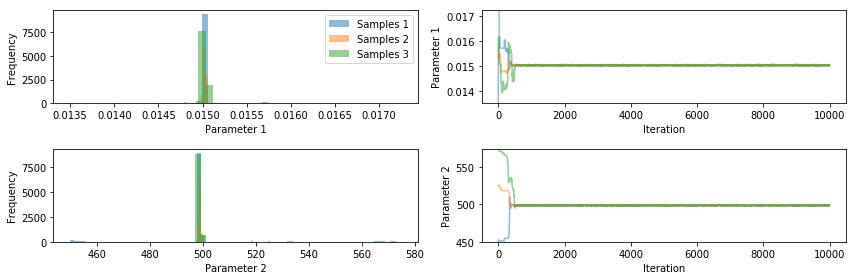

In [14]:
import pints.plot
pints.plot.trace(chains)
plt.show()

Based on this plot, it looks like the three chains become very similar after about 1000 iterations.
To be safe, we throw away the first 2000 samples and continue our analysis with the first chain.

In [15]:
chain = chains[0]
chain = chain[2000:]

We can also look for autocorrelation in the chains, using the [autocorrelation()](http://pints.readthedocs.io/en/latest/diagnostic_plots.html#pints.plot.autocorrelation) method. If everything went well, the samples in the chain should be relatively independent, so the autocorrelation should get quite low when the `lag` on the x-axis increases.

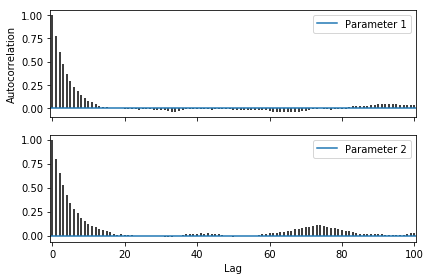

In [16]:
pints.plot.autocorrelation(chain)
plt.show()

Now we can inspect the inferred distribution by plotting histograms:

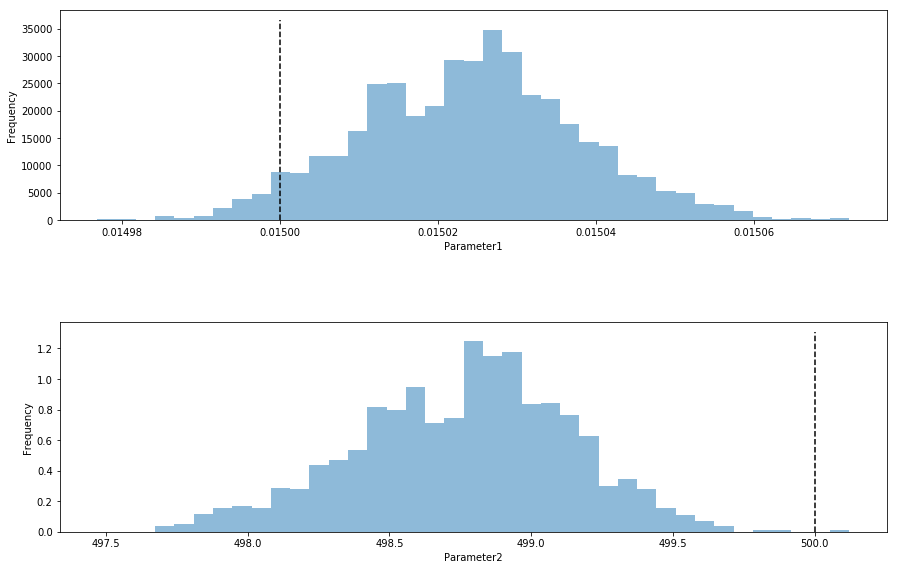

In [17]:
fig, axes = pints.plot.histogram([chain], ref_parameters=true_parameters)

# Show where the sample standard deviation of the generated noise is:
noise_sample_std = np.std(values - org_values)
#axes[-1].axvline(noise_sample_std, color='orange', label='Sample standard deviation of noise')
#axes[-1].legend()

fig.set_size_inches(14, 9)
plt.show()

Here we've analysed each parameter in isolation, but we can also look at correlations between parameters we found using the [pairwise()](http://pints.readthedocs.io/en/latest/diagnostic_plots.html#pints.plot.pairwise) plot.

To speed things up, we'll first apply some _thinning_ to the chain:

In [18]:
thinned_chain = chain[::10]

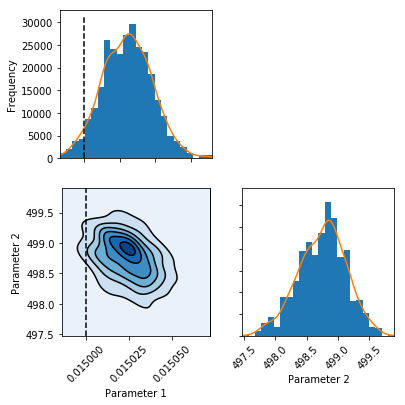

In [19]:
pints.plot.pairwise(thinned_chain, kde=True, ref_parameters=true_parameters)
plt.show()

Finally, we can look at the bit that really matters: The model predictions made from models with the parameters we found (a _posterior predictive check_). Thes can be plotted using the [series()](http://pints.readthedocs.io/en/latest/diagnostic_plots.html#pints.plot.series) method.

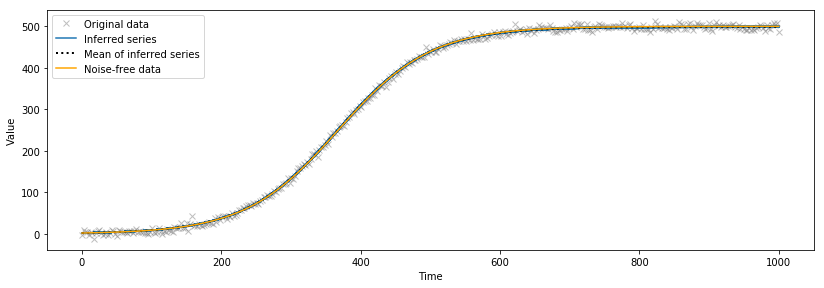

In [20]:
fig, axes = pints.plot.series(chain, problem)

# Customise the plot, and add the original, noise-free data
fig.set_size_inches(12,4.5)
plt.plot(times, org_values, c='orange', label='Noise-free data')
plt.legend()
plt.show()

-1239.7604357029354
[1.50597965e-02 4.97366584e+02]
-1237.436746580168


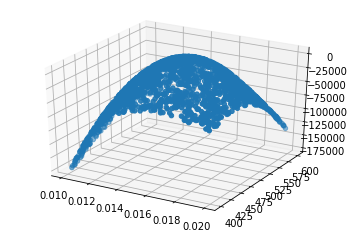

In [21]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 

input_parameters = log_prior.sample(2000)
x = [p[0] for p in input_parameters]
y = [p[1] for p in input_parameters]
input_parameters[:5]

likelihoods = np.apply_along_axis(log_likelihood, 1, input_parameters)
likelihoods[:5]

print(max(likelihoods))
idx = list(likelihoods).index(max(likelihoods))
print(input_parameters[idx])
print(log_likelihood([0.015, 500]))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, list(likelihoods))
plt.show()

In [22]:
print(input_parameters[:5])

[[1.12257514e-02 4.68056789e+02]
 [1.24127477e-02 4.14456081e+02]
 [1.49876293e-02 4.18723805e+02]
 [1.45788013e-02 4.55300959e+02]
 [1.60576112e-02 5.20042207e+02]]


In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(input_parameters, likelihoods, test_size=0.3, random_state=0)

emu = pints.MultiLayerNN(log_likelihood, X_train, y_train, 
                          input_scaler=MinMaxScaler(), output_scaler=StandardScaler())
#emu.set_parameters(layers=6, neurons=64, hidden_activation='relu', activation='tanh', learning_rate=0.00001)
emu.set_parameters(layers=6, neurons=64, hidden_activation='relu', activation='linear', learning_rate=0.0001)
hist = emu.fit(epochs=1000, batch_size=32, X_val=X_valid, y_val=y_valid, verbose=0)
#emu.summary()

In [ ]:
emu([0.015, 500])

In [ ]:
log_likelihood([0.015, 500])

In [ ]:
# summarize history for loss
print(hist.history.keys())
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Learning curve')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()

In [ ]:
# summarize history for loss
print(hist.history.keys())
plt.plot(hist.history['mean_absolute_error'])
plt.plot(hist.history['val_mean_absolute_error'])
plt.title('Learning curve')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()

In [ ]:
test_splits = 20 # number of splits along each axis
r_grid, k_grid, test_data = pints.generate_grid(bounds.lower(), 
                                                  bounds.upper(), 
                                                  test_splits)

model_prediction = pints.predict_grid(log_likelihood, test_data)

plt.figure(figsize = (10, 5))
ax = pints.plot.surface(r_grid, k_grid, model_prediction, title = "True log-likelihood",
                     x_label = "growth rate (r)",
                     y_label = "carrying capacity (k)")

In [ ]:
emu_prediction = pints.predict_grid(emu, test_data)

plt.figure(figsize = (10, 5))
ax = pints.plot.surface(r_grid, 
             k_grid, 
             emu_prediction, 
             title = "Multi-layer NN emulator log-likelihood",
             x_label = "growth rate (r)",
             y_label = "carrying capacity (k)")

In [ ]:
chain = chains[0]
emu_prediction = np.apply_along_axis(emu, 1, chain).flatten()
model_prediction = np.apply_along_axis(log_likelihood, 1, chain).flatten()
diffs = np.abs(model_prediction - emu_prediction)

iters = np.linspace(0, 10000, len(chain))
plt.figure(figsize=(10, 5))
plt.title("Emulator and model absolute differences along a chain of MCMC")
plt.xlabel("Number of iterations")
plt.ylabel("Likelihood")
plt.plot(iters, diffs, color = "Black")
plt.show()

diffs[-1]

In [ ]:
print(emu_prediction)

In [ ]:
log_posterior_emu = pints.LogPosterior(emu, log_prior)

In [ ]:
chains_emu = pints.mcmc_sample(log_posterior_emu, 3, xs)

In [ ]:
pints.plot.trace(chains_emu)
plt.show()

In [ ]:
pints.plot.trace(chains)
plt.show()

In [ ]:
chain_emu = chains_emu[0]
chain_emu = chain_emu[2000:]
chain = chains[0]
chain = chain[2000:]

In [ ]:
fig, axes = pints.plot.histogram([chain_emu, chain], ref_parameters=true_parameters, sample_names=["Emulator", "MCMC"])
fig.set_size_inches(14, 9)
plt.show()

In [ ]:
thinned_chain_emu = chain_emu[::10]
pints.plot.pairwise(thinned_chain_emu, kde=True, ref_parameters=true_parameters)
plt.show()

In [ ]:
pints.plot.pairwise(thinned_chain, kde=True, ref_parameters=true_parameters)
plt.show()

In [ ]:
emu_prediction = np.apply_along_axis(emu, 1, chain_emu).flatten()
model_prediction = np.apply_along_axis(log_likelihood, 1, chain).flatten()
diffs = np.abs(model_prediction - emu_prediction)

iters = np.linspace(0, 10000, len(chain_emu))
plt.figure(figsize=(10, 5))
plt.title("Emulator and model absolute differences along a chain of MCMC")
plt.xlabel("Number of iterations")
plt.ylabel("Likelihood")
plt.plot(iters, diffs, color = "Black")
plt.show()

diffs[-1]

In [ ]:
chain_emu

In [ ]:
# Create grid
x = [p[0] for p in input_parameters]
y = [p[1] for p in input_parameters]
xmin, xmax = np.min(x), np.max(x)
ymin, ymax = np.min(y), np.max(y)
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
params = [list(n) for n in zip(xx, yy)]
ll = np.apply_along_axis(log_likelihood, 1, params)
plt.contourf(xx, yy, ll, cmap='Blues', extent=[xmin, xmax, ymin, ymax])
plt.contour(xx, yy, ll, colors='k')
plt.show()

In [ ]:
fig, ax = plt.subplots()                   

# Show density 
#ax.imshow(np.rot90(ll), cmap=plt.cm.Blues, extent=[xmin, xmax, ymin, ymax])                                                                     

# Plot chain_emu
x = [p[0] for p in chain_emu]
y = [p[1] for p in chain_emu]
xmin, xmax = np.min(x), np.max(x)
ymin, ymax = np.min(y), np.max(y)
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]

idx = diffs.argsort()
x_sorted = np.array(x)[idx]
y_sorted = np.array(y)[idx]
diffs_sorted = diffs[idx]

# Add contour lines
ax.contourf(xx, yy, ll, cmap='Greys', extent=[xmin, xmax, ymin, ymax])
plt.contour(xx, yy, ll, colors='w')

# Plot chain_emu
#ax.plot(x, y, 'k.', markersize=2)    
ax.set_xlim([xmin, xmax])                                                                           
ax.set_ylim([ymin, ymax])

ax.scatter(x_sorted, y_sorted, c=diffs_sorted, s=80, edgecolor='k', cmap="RdYlGn_r")
#fig.colorbar(ax)
plt.show()

In [ ]:
# Choose starting points for 3 mcmc chains
x0s = [
    np.array(true_parameters) * 0.9,
    np.array(true_parameters) * 1.05, #1.1
    np.array(true_parameters) * 1.15,
]
# Choose a covariance matrix for the proposal step
sigma0 = np.abs(true_parameters) * 5e-3

# Create mcmc routine
mcmc = pints.MCMCController(emu, 3, x0s, sigma0=sigma0, method=pints.EmulatedMetropolisMCMC, f=log_posterior)

# Add stopping criterion
mcmc.set_max_iterations(30000)

# Disable logging mode
#mcmc.set_log_to_screen(False)

# Run!
print('Running...')
emulated_chains = mcmc.run()
print('Done!')

# Show traces and histograms
pints.plot.trace(emulated_chains)

# Discard warm up
emulated_chains_thinned = emulated_chains[:, 10000:, :]

# Check convergence using rhat criterion
print('R-hat:')
print(pints.rhat_all_params(emulated_chains_thinned))

# Look at distribution in chain 0
pints.plot.pairwise(emulated_chains_thinned[0])

# Show graphs
plt.show()

In [ ]:
# Choose starting points for 3 mcmc chains
x0s = [
    np.array(true_parameters) * 0.9,
    np.array(true_parameters) * 1.05, #1.1
    np.array(true_parameters) * 1.15,
]
# Choose a covariance matrix for the proposal step
sigma0 = np.abs(true_parameters) * 5e-3

# Create mcmc routine
mcmc = pints.MCMCController(emu, 3, x0s, sigma0=sigma0, method=pints.EmulatedACMCMC, f=log_posterior)

# Add stopping criterion
mcmc.set_max_iterations(30000)

# Disable logging mode
#mcmc.set_log_to_screen(False)

# Run!
print('Running...')
emulated_chains = mcmc.run()
print('Done!')

# Show traces and histograms
pints.plot.trace(emulated_chains)

# Discard warm up
emulated_chains_thinned = emulated_chains[:, 10000:, :]

# Check convergence using rhat criterion
print('R-hat:')
print(pints.rhat_all_params(emulated_chains_thinned))

# Look at distribution in chain 0
pints.plot.pairwise(emulated_chains_thinned[0])

# Show graphs
plt.show()

In [ ]:
# Choose starting points for 3 mcmc chains
x0s = [
    np.array(true_parameters) * 0.9,
    np.array(true_parameters) * 1.05, #1.1
    np.array(true_parameters) * 1.15,
]
# Choose a covariance matrix for the proposal step
sigma0 = np.abs(true_parameters) * 1e-4

# Create mcmc routine
mcmc = pints.MCMCController(log_posterior, 3, x0s, sigma0=sigma0, method=pints.MetropolisRandomWalkMCMC)

# Add stopping criterion
mcmc.set_max_iterations(30000)

# Disable logging mode
#mcmc.set_log_to_screen(False)

# Run!
print('Running...')
metropolis_chains = mcmc.run()
print('Done!')

# Show traces and histograms
pints.plot.trace(metropolis_chains)

# Discard warm up
metropolis_chains_thinned = metropolis_chains[:, 10000:, :]

# Check convergence using rhat criterion
print('R-hat:')
print(pints.rhat_all_params(metropolis_chains_thinned))

# Look at distribution in chain 0
pints.plot.pairwise(metropolis_chains_thinned[0])

# Show graphs
plt.show()

In [ ]:
metropolis_chains.shape

In [ ]:
metropolis_chains[0][:10]

In [ ]:
emulated_chains[0][:10]

In [ ]:
class RescaledModel(pints.ForwardModel):
    def __init__(self):
        self.base_model = pints.toy.LogisticModel()
    
    def simulate(self, parameters, times):
        # Run a simulation with the given parameters for the
        # given times and return the simulated values
        r, k = parameters
        r = r / 50
        k = k * 500
        return self.base_model.simulate([r, k], times)
    
    def simulateS1(self, parameters, times):
        # Run a simulation with the given parameters for the
        # given times and return the simulated values
        r, k = parameters
        r = r / 50
        k = k * 500
        return self.base_model.simulateS1([r, k], times)
    
    def n_parameters(self):
        # Return the dimension of the parameter vector
        return 2

model = pints.toy.LogisticModel()

# Create an object with links to the model and time series
problem = pints.SingleOutputProblem(model, times, values)

# Select a score function
score = pints.SumOfSquaresError(problem)

# Perform an optimization
x0 = [0.01, 450]
opt = pints.OptimisationController(
    score,
    x0,
    method=pints.GradientDescent
)

opt.optimiser().set_learning_rate(1e-10)
opt.set_max_iterations(100)

found_parameters, found_value = opt.run()

# Rescale parameters
found_parameters = list(found_parameters)

# Show score of true solution
print('Score at true solution: ')
print(score(true_parameters))

# Compare parameters with original
print('Found solution:          True parameters:' )
for k, x in enumerate(found_parameters):
    print(pints.strfloat(x) + '    ' + pints.strfloat(true_parameters[k]))

In [ ]:
class RescaledModel(pints.ForwardModel):
    def __init__(self):
        self.base_model = pints.toy.LogisticModel()
    
    def simulate(self, parameters, times):
        # Run a simulation with the given parameters for the
        # given times and return the simulated values
        r, k = parameters
        r = r / 50
        k = k * 500
        return self.base_model.simulate([r, k], times)
    
    def simulateS1(self, parameters, times):
        # Run a simulation with the given parameters for the
        # given times and return the simulated values
        r, k = parameters
        r = r / 50
        k = k * 500
        return self.base_model.simulateS1([r, k], times)
    
    def n_parameters(self):
        # Return the dimension of the parameter vector
        return 2

model = RescaledModel()

# Create an object with links to the model and time series
problem = pints.SingleOutputProblem(model, times, values)

# Select a score function
score = pints.SumOfSquaresError(problem)

# Perform an optimization
x0 = [1, 1]
opt = pints.OptimisationController(
    score,
    x0,
    method=pints.GradientDescent
)

opt.optimiser().set_learning_rate(1e-10)
opt.set_max_iterations(100)

found_parameters, found_value = opt.run()

# Rescale parameters
found_parameters = list(found_parameters)
found_parameters[0] = found_parameters[0] / 50
found_parameters[1] = found_parameters[1] * 500

# Show score of true solution
print('Score at true solution: ')
print(score(true_parameters))

# Compare parameters with original
print('Found solution:          True parameters:' )
for k, x in enumerate(found_parameters):
    print(pints.strfloat(x) + '    ' + pints.strfloat(true_parameters[k]))